# Credit Card Default Analysis - Part 4: Clustering

By Heidi Nguyen


<a id="top"></a>

# Table of Contents

- [Abstract](#ABS)

- [Business Understanding 1](#BU1) 

- [Data Understanding 1](#DU1)

- [Data Understanding 2](#DU2)

- [Modeling and Evaluation 1](#MODEL1)

    - [Baseline Classification Performance - Random Forest (RF)](#BRF)
    
    - [KMeans](#KM)
    
    - [Agglomerative Clustering](#HAC)
    
    - [DBSCAN](#DSB)
    
- [Modeling and Evaluation 2](#MODEL2)

- [Modeling and Evaluation 3](#MODEL3)

- [Modeling and Evaluation 4](#MODEL4)     

- [Deployment](#DEP)         

- [Exceptional Work: Kmeans Clustering Validity with Centroids and Spectral Clustering](#EXP)

- [Reference](#ref)


<a id="ABS"></a>

# Abstract: 

In previous weeks we have imputed values and made new variables using the 'pandas.cut' function to define how to make a single attribute discrete. In this Lab, we'll instead use clustering to convert one or more features into discrete, categorical features (integers). Then we will use those features to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed. [2]

We will investigate simple clustering methods for making the clusters discrete: kmeans, hierarchical agglomerative clustering (HAC), and DBSCAN. We will then investigate what kind of model and its best parameters we can use to predict these classifications of our dataset. We will be evaluating the output of these methods based on their accuracy, precision, recall, and F-measure. We will compare these methods using full data random forest model as the baseline classification performance for accuracy and ROC for overall performance.

We will be using the cleaned credit default data set.

 <a href="#top">Back to top</a>

<div id='BU1'/>
# 1. Business Understanding 1: 

We used a credit card dataset from Kaggle. This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. As Erin El Issa stated, "Debt is a way of life for Americans, with overall U.S. household debt increasing by 11% in the past decade. Today, the average household with credit card debt has balances totaling 16,883, and the average household with any kind of debt owes 137,063, including mortgages. It's time to take action.

The purpose of the dataset is to identification and weight factors affecting risk of default. We will strives to create a predictive model by looking into all 25 attributes and 30000 instances, distribution level for categorical variables use ranking algorithm to get best variables that are highly correlated. How does the probability of default payment vary by categories of different demographic variables? Which variables are the strongest predictors of default payment by evaluating the relationship between:
    * Default and Education 
    * Default and Gender
    * Default and Marriage
    * Default and Age 
    * Default and Credit Limit 
    * Default and payment behaviors 
The information we will be gaining in this analysis will be useful to predict the most likely credit card defaulters based on transactional data.

We will measure the effectiveness of our algorithms of the prediction using accuracy, AUC, recall, precision, and f-measure tests as below. We will also use StratifiedKFold cross-validation to train and test the model. 

 <a href="#top">Back to top</a> 

## Evaluation metrics selection [2], [23], [24]

We will use all the metrics as our evaluation metrics of choice.

1 - Accuracy (AC) is the proportion of the total number of predictions that were correct. From a confusion matrix, we can obtain the accuracy of the model by adding the number of instances that were correctly predicted, meaning predicted True and were actually True, predicted False were actually False. Then we divide it by the total number of instances. 

<br/>
<br/>
<center> Confusion matrix: </center>

|Item |	Predicted:0| 	Predicted:1|
                     | :-|:-:| :-:| 
|Actual: 0 - negative| 	a| 	b|
|Actual: 1 - positive|  c|	d|

<center>
a or TN is the number of correct predictions that an instance is negative <br/> 
b or FP is the number of incorrect predictions that an instance is positive <br/> 
c or FN is the number of incorrect of predictions that an instance negative <br/> 
d or TP is the number of correct predictions that an instance is positive.<br/> 
</center>

<br/> 
<center> $AC = \frac{a + d}{a + b + c + d} = \frac{TN+TP}{TN+FN+FP+TP}$ </center>

    Because our data is imbalanced and the costs of falsely predicting positive is markedly higher than incorrectly predicting false negative, predictive accuracy is not enough to measure the performance of a model. 
    We want to use accuracy as the base metric to quickly evaluate the models and its parameters combination. We want to classify default classification correctly. An accuracy better than an accuracy of the all-positive (all zeros) models is desired. 
<br/> 

2 -  Recall, also known as True Positive Rate (TPR), tells how often an actual True instance is predicted to be True. So, Recall is taking the number of True instances that are predicted correctly and dividing it by the total number of instances that are actually True. 

    Depending on the business case, a proper measure of the metrics needs to take into account the cost of being wrong. To wrongly classify someone as non default("0") could lead to large losses for the credit card company, whereas, incorrectly classifying someone as default ("1") may mean the company loses money on unnecessary intervention and may cause customer dissatisfaction. 
    With these scenarios, we are going to assume the cost of defaulting is more than the cost of losing a potential customer. This means that the false positives (FP) are not as costly as false negatives FN). Furthermore, this means that the recall measurement should be maximized while minimizing the impact of precision. 

<br/> 
<center>$recall (TPR) = \frac{d}{c + d} = \frac{TP}{TP + FN}$</center>
<br/> 

    We want the FN to be minimized in our predictive models, while still accurately labeling them as TP. However, the cost of improving recall could cause precision to be worse. 

3 - Precision (P) is the proportion of the predicted positive cases that were correct, the accuracy of the predicted positives. From a confusion matrix, we can obtain the precision of the model by taking the number of instances that were predicted to be True and were actually True, then divide this by the total number of instances that were predicted to be True.  

<center>$precision = \frac{d}{b + d} = \frac{TP}{TP + FP}$</center>

     The total of TP and FP is equal to all the predicted positives. Precision can start to decrease as the model loosens the criteria to increase the TP. TP might increase, but FP might increase as well. 
    Recall and precision are competing in nature, therefore, all being kept the same, improving one will be at the expense of the other. 
    As explained in above, we consider FN to be more costly; recall is considered more important and reducing precision is an acceptable trade-off for our models. We can use ROC to decide if the trade-off is well worth it. 

4 - The F-measure is a weighted average of the precision and recall. The F measure is calculated by the product of the precision and recall divided by the sum of the precision and recall. The F measure is scored between [0,1], 1 is the best value and 0 is the lowest. Beta ($\beta$) is the relative importance weighting of precision vs. recall, and is usually set to 1.

<br/> 
<center>$ F-measure = \frac{(1+\beta^{2}) {*} recall {*} precision}{\beta^{2} {*}recall {*}precision}$</center>
<br/> 

    Since the F-value metric is one measure that combines the trade-offs of precision and recall, we will use F-measure output, a single number, to decide how good of a classifier in the presence of rare classes. The F-measure will also be used in comparing our 2 classifiers. 

    **ROC Curves and AUC scores are good measures for our imbalanced data and the main goal for learning from our imbalanced dataset is to improve the recall without sacrifying the precision too much. 


<a href="#top">Back to top</a>

<div id='DU1'/>

# 2. Data Understanding 1: Data Meaning and Type of Data

## Raw Data Content:

Dataset Information:<br/>
This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. Dataset downloaded at: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

There are 25 variables. See below 'Data Type Image' for more detail.  


 <a href="#top">Back to top</a>

<div id='DM'/> 

## Data Meaning and Type of Data:

All data verification and data cleaning are given in Lab 1, MiniLab 1, and Lab 2. 

 <a href="#top">Back to top</a>

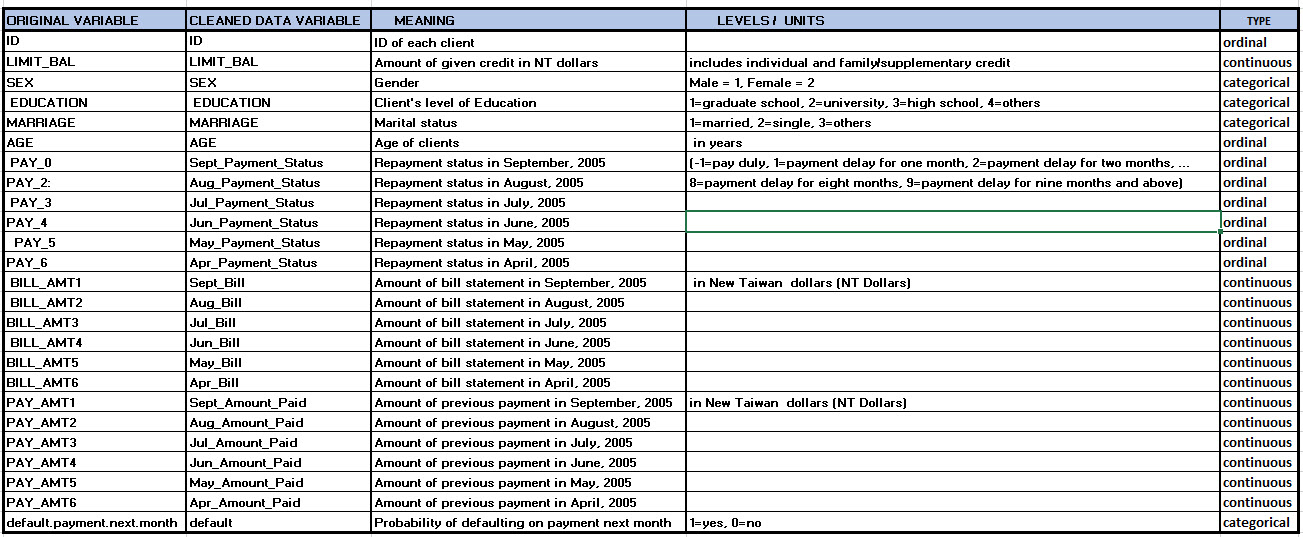

In [500]:
#Data Type Image.
from IPython.display import Image
Image(filename='/Volumes/NO NAME/Data Science/2017-0829 MSDS 7331 Data Mining/Unit 5b - Mini Lab/Data Meaning Table.jpg')

In [1]:
#Libraries 

# generals 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from collections import Counter
import time

#sklearn - for classification 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

# for interactive tool 
from ipywidgets import widgets as wd

%matplotlib inline


<div id='DQ'/> 

## Verify Data Quality: 
The below data verification and data cleaning are given in Lab 1. 

In Lab 1, we found that there was minimal amount of missing data that are categorized as known in the data set. There were some invalid data that were not classified in the data description. We also observed that some of those invalid data were actually valid, but were missing from the original data description. We made the changes to include these data values in the data set. As for those missing and unknown data, we grouped them into the unknown groups or others group that available in those attributes. <br/>
There were no obvious outliers in our dataset. There are no duplicated rows in the dataset. 

 <a href="#top">Back to top</a>

In [2]:
# read in the cleaned credit card csv file from Lab 1, and save it as a dataframe - df
df = pd.read_csv('/Volumes/NO NAME/Data Science/2017-0829 MSDS 7331 Data Mining/Unit 3 - Lab 1/cleaned_credit_default.csv')
# look at the data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
Unnamed: 0             30000 non-null int64
ID                     30000 non-null int64
LIMIT_BAL              30000 non-null float64
SEX                    30000 non-null int64
EDUCATION              30000 non-null int64
MARRIAGE               30000 non-null int64
AGE                    30000 non-null int64
Sept_Payment_Status    30000 non-null int64
Aug_Payment_Status     30000 non-null int64
Jul_Payment_Status     30000 non-null int64
Jun_Payment_Status     30000 non-null int64
May_Payment_Status     30000 non-null int64
Apr_Payment_Status     30000 non-null int64
Sept_Bill              30000 non-null float64
Aug_Bill               30000 non-null float64
Jul_Bill               30000 non-null float64
Jun_Bill               30000 non-null float64
May_Bill               30000 non-null float64
Apr_Bill               30000 non-null float64
Sept_Amount_Paid       30000 non-null flo

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Sept_Payment_Status,Aug_Payment_Status,Jul_Payment_Status,...,Jun_Bill,May_Bill,Apr_Bill,Sept_Amount_Paid,Aug_Amount_Paid,Jul_Amount_Paid,Jun_Amount_Paid,May_Amount_Paid,Apr_Amount_Paid,default
0,0,1,20000.0,2,2,1,24,2,2,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,1,2,120000.0,2,2,2,26,-1,2,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,2,3,90000.0,2,2,2,34,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,3,4,50000.0,2,2,1,37,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,4,5,50000.0,1,2,1,57,-1,0,-1,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Proper variable representations: all the variables already have the proper types due to the data processing and cleaning that were done in Lab 1. <br/> 
 There are 30000 entries and 25 columns. We can see that the data is saved as an integer or as a float. There are no missing fields in any of the variables. <br/>

In [3]:
from __future__ import print_function

# creating new dataframe. Keeping original seperate.
df_copy = df.copy()

# Remove the first index attribute which is not useful for us
df_copy.drop(df_copy.columns[[0, 1]], axis=1, inplace = True) 

# Remove attributes that just arent useful for us 
if 'ID' in df_copy:
    del df_copy['ID'] 

# look at the data 
df_copy.info()
df_copy.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL              30000 non-null float64
SEX                    30000 non-null int64
EDUCATION              30000 non-null int64
MARRIAGE               30000 non-null int64
AGE                    30000 non-null int64
Sept_Payment_Status    30000 non-null int64
Aug_Payment_Status     30000 non-null int64
Jul_Payment_Status     30000 non-null int64
Jun_Payment_Status     30000 non-null int64
May_Payment_Status     30000 non-null int64
Apr_Payment_Status     30000 non-null int64
Sept_Bill              30000 non-null float64
Aug_Bill               30000 non-null float64
Jul_Bill               30000 non-null float64
Jun_Bill               30000 non-null float64
May_Bill               30000 non-null float64
Apr_Bill               30000 non-null float64
Sept_Amount_Paid       30000 non-null float64
Aug_Amount_Paid        30000 non-null float64
Jul_Amount_Paid        30000 non-null

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Sept_Payment_Status,Aug_Payment_Status,Jul_Payment_Status,Jun_Payment_Status,May_Payment_Status,...,Jun_Bill,May_Bill,Apr_Bill,Sept_Amount_Paid,Aug_Amount_Paid,Jul_Amount_Paid,Jun_Amount_Paid,May_Amount_Paid,Apr_Amount_Paid,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


<div id='OHC'/>

## Additional Data Processing: One hot encoding of categorical variables and adding new variables 

All one hot encodings of categorical variables were done in Lab 2. 

 <a href="#top">Back to top</a>

Now let's look a little further at each of the categorical variables. Those are 'MARRIAGE', 'EDUCATION, 'SEX', and 'default' status.

In [4]:
# NOTE: calling describe when not all the data is categorical will cause the 
# categorical variables to be removed
df_copy[['SEX','EDUCATION','MARRIAGE']].describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
SEX,30000.0,1.603733,0.489129,1.0,1.0,2.0,2.0,2.0
EDUCATION,30000.0,1.842267,0.744494,1.0,1.0,2.0,2.0,4.0
MARRIAGE,30000.0,1.557267,0.521405,1.0,1.0,2.0,2.0,3.0


In [5]:
#check each for data frequency and possible invalid data of ordinal and categorical variables
print (dict(Counter(df_copy.SEX))) 
print (dict(Counter(df_copy.EDUCATION)))
print (dict(Counter(df_copy.MARRIAGE)))
print (dict(Counter(df_copy.default))) 

{1: 11888, 2: 18112}
{1: 10585, 2: 14030, 3: 4917, 4: 468}
{1: 13659, 2: 15964, 3: 377}
{0: 23364, 1: 6636}


Because the Sex and default attributes are already binary, there is no need to encode it using OneHotEncoding. We can just convert Female to be 0, while Male is still 1. 
Also, notice that our data is an imbalance, with 23364 data with 0-no default vs. 6636 data with 1-default. 

In [6]:
# replace the current Sex atribute with something slightly more intuitive and readable
df_copy['IsMale'] = df_copy.SEX== 1
df_copy.IsMale = df_copy.IsMale.astype(np.int)

# Now let's clean up the dataset and remove 'SEX' from the raw data set 
if 'SEX' in df_copy:
    del df_copy['SEX'] # if 'SEX' column still exists, delete it (as we created an IsMale column)
    
# Rearrange the columns 
df_copy = df_copy[['default', 'EDUCATION', 'MARRIAGE','IsMale','LIMIT_BAL','AGE',
       'Sept_Payment_Status','Aug_Payment_Status',
       'Jul_Payment_Status', 'Jun_Payment_Status', 'May_Payment_Status',
       'Apr_Payment_Status', 'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 'Sept_Amount_Paid',
       'Aug_Amount_Paid', 'Jul_Amount_Paid', 'Jun_Amount_Paid',
       'May_Amount_Paid', 'Apr_Amount_Paid']]
# Look at the first few lines of df_copy: 
df_copy.head()

,default,EDUCATION,MARRIAGE,IsMale,LIMIT_BAL,AGE,Sept_Payment_Status,Aug_Payment_Status,Jul_Payment_Status,Jun_Payment_Status,...,Jul_Bill,Jun_Bill,May_Bill,Apr_Bill,Sept_Amount_Paid,Aug_Amount_Paid,Jul_Amount_Paid,Jun_Amount_Paid,May_Amount_Paid,Apr_Amount_Paid
0,1,2,1,0,20000.0,24,2,2,-1,-1,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,1,2,2,0,120000.0,26,-1,2,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,0,2,2,0,90000.0,34,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,0,2,1,0,50000.0,37,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,0,2,1,1,50000.0,57,-1,0,-1,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


Adding a new variable "Total_Month_Late", the total number of months past due as of Sept. This is the total count of months with payment status > 0

In [7]:
# creating another dataframe for adding variable and one hot coding. 
df_copy1 = df_copy.copy()

# Finally, let's create a new variable based on the monthly payment status. 
# Notice that this new column did not exist before this line of code--we use the pandas 
# This the total number of months past due (payment status > 0)
df_imputed = df_copy1[['Apr_Payment_Status','May_Payment_Status','Jun_Payment_Status','Jul_Payment_Status','Aug_Payment_Status','Sept_Payment_Status']]
df_imputed["Total_Month_Late"] = df_imputed[df_imputed > 0].count(axis=1) 

# putting the total months of late payment status to df_copy  
df_copy1["Total_Month_Late"] = df_imputed["Total_Month_Late"].astype(np.int64)

# check for types: 
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
default                30000 non-null int64
EDUCATION              30000 non-null int64
MARRIAGE               30000 non-null int64
IsMale                 30000 non-null int64
LIMIT_BAL              30000 non-null float64
AGE                    30000 non-null int64
Sept_Payment_Status    30000 non-null int64
Aug_Payment_Status     30000 non-null int64
Jul_Payment_Status     30000 non-null int64
Jun_Payment_Status     30000 non-null int64
May_Payment_Status     30000 non-null int64
Apr_Payment_Status     30000 non-null int64
Sept_Bill              30000 non-null float64
Aug_Bill               30000 non-null float64
Jul_Bill               30000 non-null float64
Jun_Bill               30000 non-null float64
May_Bill               30000 non-null float64
Apr_Bill               30000 non-null float64
Sept_Amount_Paid       30000 non-null float64
Aug_Amount_Paid        30000 non-null f

/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
# Rearrange the columns 
df_copy1 = df_copy1[['default', 'EDUCATION', 'MARRIAGE','IsMale','LIMIT_BAL','AGE',
       'Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status',
       'Jul_Payment_Status', 'Jun_Payment_Status', 'May_Payment_Status',
       'Apr_Payment_Status', 'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 'Sept_Amount_Paid',
       'Aug_Amount_Paid', 'Jul_Amount_Paid', 'Jun_Amount_Paid',
       'May_Amount_Paid', 'Apr_Amount_Paid']]
# Look at the first few lines of df_copy: 
df_copy1.head()

,default,EDUCATION,MARRIAGE,IsMale,LIMIT_BAL,AGE,Total_Month_Late,Sept_Payment_Status,Aug_Payment_Status,Jul_Payment_Status,...,Jul_Bill,Jun_Bill,May_Bill,Apr_Bill,Sept_Amount_Paid,Aug_Amount_Paid,Jul_Amount_Paid,Jun_Amount_Paid,May_Amount_Paid,Apr_Amount_Paid
0,1,2,1,0,20000.0,24,2,2,2,-1,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,1,2,2,0,120000.0,26,2,-1,2,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,0,2,2,0,90000.0,34,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,0,2,1,0,50000.0,37,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,0,2,1,1,50000.0,57,0,-1,0,-1,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


<div id='FDM'/> 

## Final Data Meaning and Type of Data

Based on the output above, you can see we have 30,000 entries and 25 columns.<br/> 

**New Variable:**<br/> 

    SEX was converted to isMale dummy variable
    Total_Month_Late is the total of months of late repayment status from Apr to Sept
    
**Other variable notes:**<br/> 

    EDUCATION - Education (1 = graduate school; 2 = university; 3 = high school; 4 = others): Undergraduate degree (University) is the most common education level at 46.8%. The majority of observations (82.1%) are from individuals with an undergraduate degree (University) or better.

    MARRIAGE - (1 = married; 2 = single; 3 = others): Single makes up the largest group at 53.2%, then Married at 45.5%, and lastly an Others group of 1.3%
    
    AGE - ranges are 20 to 80 years old. Seventy-two percent of the observations fall in to the first two categories "21-30" and "31-40."

    Bill Amount (Sept_Bill - Apr_Bill) - The amount of the credit card bill in Taiwan Dollar for the months April 2005 to September2015. The bill amounts across the months are highly correlated.

    Pay History (Sept_Payment_Status - Apr_Payment_Status) - About a fifth of the observations are zeros each month. The 3rd quartile for each month is zero meaning, most observations are zero or less. One month delays seem to be far more absent in months Aug_Payment_Status to Apr_Payment_Status, with May_Payment_Status and Jun_Payment_Status not having any at all and seems rather odd. Only Sept_Payment_Status of 1 seems to fit as one would expect.  

    Payment records (Sept_Amount_Paid - Ape_Amount_Paid) - Is the records of the payment toward the credit card that month. About a fifth of the observations are zeros each month. The 3rd quartile for each month is zero meaning, most observations are zero or less. One month delays seem to be far more absent in months Aug_Payment_Status to Apr_Payment_Status, with May_Payment_Status and Jun_Payment_Status not having any at all and seems rather odd. Only Sept_Payment_Status of 1 seems to fit as one would expect.
   

**Summary Table:**

|Attribute|Data Type|Description|
| :------ |-------: | :---------|
|default|               int64| 0 is not default, 1 is default. 22.12% of the obeservations were considered in default in October 2005, the data set is an imbalance set. 
|EDUCATION_1|           int64|dummy variable created from EDUCATION, 1 = graduate school; 2 = university; 3 = high school; 4 = others
|MARRIAGE_1|            int64| dummy variable created from MARRIAGE, 1 for 'married'; 2 for 'single', 3 for 'Others' 
|IsMale|                int64| (1 = male; 0 = female): Females are the majority gender at 60.4%.
|LIMIT_BAL|             float64| customer's credit limit in NT. 
|AGE|                   int64| customer's age, ranges are 20 to 80 years old. 
|Total_Month_Late|   int64| the total of months of late repayment status from Apr to Sept
|Sept_Payment_Status|   int64| repayment status in September, 2005
|Aug_Payment_Status|    int64| repayment status in Aug, 2005. (-2= pay minimum, -1=pay duly, 1 = 1 month delay, 2 = 2 months delay, so on. 
|Jul_Payment_Status|    int64| repayment status in Jul, 2005.  (-2= pay minimum, -1=pay duly, 1 = 1 month delay, 2 = 2 months delay, so on. 
|Jun_Payment_Status|    int64| repayment status in Jun, 2005.  (-2= pay minimum, -1=pay duly, 1 = 1 month delay, 2 = 2 months delay, so on. 
|May_Payment_Status|    int64| repayment status in May, 2005.  (-2= pay minimum, -1=pay duly, 1 = 1 month delay, 2 = 2 months delay, so on. 
|Apr_Payment_Status|    int64| repayment status in Apr, 2005.  (-2= pay minimum, -1=pay duly, 1 = 1 month delay, 2 = 2 months delay, so on. 
|Sept_Bill|             float64| Sept 2005 billing amount (NT dollar)
|Aug_Bill|              float64| Aug 2005 billing amount (NT dollar)
|Jul_Bill|              float64| Jul 2005 billing amount (NT dollar)
|Jun_Bill|              float64| Jun 2005 billing amount (NT dollar)
|May_Bill|              float64| May 2005 billing amount (NT dollar)
|Apr_Bill|              float64| Apr 2005 billing amount (NT dollar)
|Sept_Amount_Paid|      float64| amount of previous payment in Sept 2005 (NT dollar)
|Aug_Amount_Paid|       float64| amount of previous payment in Aug 2005 (NT dollar)
|Jul_Amount_Paid|       float64| amount of previous payment in Jul 2005 (NT dollar)
|Jun_Amount_Paid|       float64| amount of previous payment in Jun 2005 (NT dollar)
|May_Amount_Paid|       float64| amount of previous payment in May 2005 (NT dollar)
|Apr_Amount_Paid|       float64| amount of previous payment in Apr 2005 (NT dollar)
Table1. Final Data Set 

<a href='#top'> Back to Top </a>


<div id='DU2'/>
# 3. Data Understanding 2: Data Visualization

All the data visualization were done in Lab 1, MiniLab 1, and Lab 2. 


 <a href="#top">Back to top</a>

In [9]:
#check the ratio of default / not default 
float(len(df_copy1[df_copy1.default==1]))/len(df_copy1)*100.0 # yes = 1, no = 0

22.12

Visualizing the imbalance with a histogram plot: 

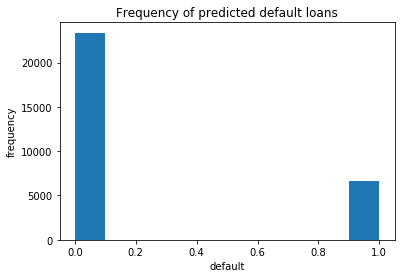

In [10]:
#histogram plot for frequency 
data=df_copy1['default']

plt.hist(data)
plt.xlabel('default')
plt.ylabel('frequency')
plt.title("Frequency of predicted default loans")
plt.show()

There are more data that have no default status.  The dataset is an imbalance set with very large class imbalance.  

Below are some statistics of the all the attributes grouped by default status: 

In [11]:
#group by default status
grouped_default = df_copy1.groupby(df_copy1['default']).describe().transpose()
#look at some statistic of each group
grouped_default 

default                                0              1
AGE                 count   23364.000000    6636.000000
                    mean       35.417266      35.725738
                    std         9.077355       9.693438
                    min        21.000000      21.000000
                    25%        28.000000      28.000000
                    50%        34.000000      34.000000
                    75%        41.000000      42.000000
                    max        79.000000      75.000000
Apr_Amount_Paid     count   23364.000000    6636.000000
                    mean     5719.371769    3441.482068
                    std     18792.950473   13464.005894
                    min         0.000000       0.000000
                    25%       300.000000       0.000000
                    50%      1706.000000    1000.000000
                    75%      4545.000000    2974.500000
                    max    528666.000000  345293.000000
Apr_Bill            count   23364.000000    6636.000000
                    mean    39042.268704   38271.435503
                    std     59547.015717   59579.674268
                    min   -209051.000000 -339603.000000
                    25%      1265.500000    1150.000000
                    50%     16679.000000   18028.500000
                    75%     49842.500000   47424.000000
                    max    961664.000000  514975.000000
Apr_Payment_Status  count   23364.000000    6636.000000
                    mean       -0.405624       0.112116
                    std         1.005930       1.485757
                    min        -2.000000      -2.000000
                    25%        -1.000000      -1.000000
                    50%         0.000000       0.000000
...                                  ...            ...
Sept_Amount_Paid    std     18014.508990    9544.252427
                    min         0.000000       0.000000
                    25%      1163.750000       0.000000
                    50%      2459.500000    1636.000000
                    75%      5606.250000    3478.250000
                    max    873552.000000  300000.000000
Sept_Bill           count   23364.000000    6636.000000
                    mean    51994.227273   48509.162297
                    std     73577.606694   73782.067220
                    min   -165580.000000   -6676.000000
                    25%      3677.250000    2987.750000
                    50%     23119.500000   20185.000000
                    75%     69027.000000   59626.500000
                    max    964511.000000  613860.000000
Sept_Payment_Status count   23364.000000    6636.000000
                    mean       -0.211222       0.668174
                    std         0.952464       1.383252
                    min        -2.000000      -2.000000
                    25%        -1.000000       0.000000
                    50%         0.000000       1.000000
                    75%         0.000000       2.000000
                    max         8.000000       8.000000
Total_Month_Late    count   23364.000000    6636.000000
                    mean        0.504194       1.996082
                    std         1.150428       2.128144
                    min         0.000000       0.000000
                    25%         0.000000       0.000000
                    50%         0.000000       1.000000
                    75%         0.000000       3.250000
                    max         6.000000       6.000000

[192 rows x 2 columns]

Compare the means of these attribute by default (1) vs no default (0) status, age of the default group and not default group are similar, around 35 years of age. First, this makes sense for the no default group since 70% of the population of the data has age from 20 to 40 and the data is imbalance with almost 80 with no default status. 

The mean of Apr_Bill bill of the default group is much lower that of the not default. The mean of Sept_Bill bill of the default group is also lower that of the not default. 

The means of all the monthly payment status are negative (no delay) for the no default group, but is positive (with delay) for the default group. The mean of Total_Month_Late status is much lower (less delay) for the no default group, but is almost 2 (2 months with delay payment) for the default group. This means that the default status is highly correlated to the monthly payment status and its history. 

 <a href="#top">Back to top</a>

**Heat Map of all correlation of all the attributes:**

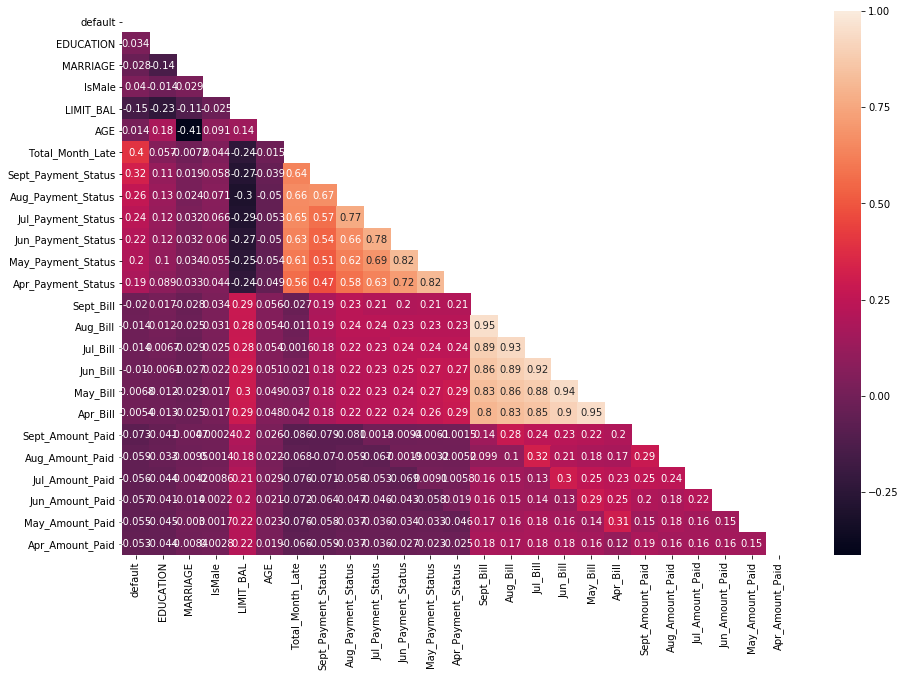

In [12]:
import matplotlib.pylab as plt
import seaborn as sns
plt.figure(figsize=(15,10))
#sns.heatmap(df_copy.corr(), annot =True)

# trying to mask the upper part
mask = np.zeros_like(df_copy1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_copy1.corr(), mask=mask,annot =True )

Heatmap without displaying the correlation ratio

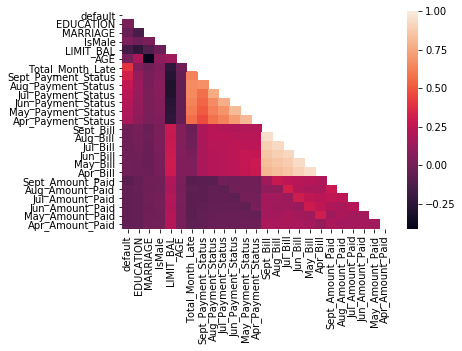

In [13]:
# also use a mask for the upper part as in the above
corr = df_copy1.corr()
sns.heatmap(corr, mask=mask, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values) 




From the correlation maps, the likelihood of defaulting on a loan is mostly correlated to the payment status of the loan from April to September of 2005. It's also interesting to know that their correlation increases each month. This explains the reason the new variable 'Total_Month_Late', counting the total number of months past due from Apr to Sept, has the highest correlation. This makes sense as the delinquency bubble moving through the correlations between Apr to Sept. The more late monthly payments one has, increases the chances of defaulting on the loan eventually. The correlation decreases as customers caught up and cured out of delinquency. 

There seems to be no correlation between probability of loan default and how much the client has been paying, how much the bill has been or any of the other demographics like age, marital status or education. This correlation map also shows that credit limit may not have a strong linear correlation with default status. 

Monthly bill amount (Apr_Bill -- Sept_Bill), indicating the amount billed monthly, has high multicollinearity. 

There appears to be many variables highly correlated to each other. AGE and MARRIAGE are highly correlated to one another. For this dataset, it probably makes sense to try and cluster AGE and MARRIAGE together. 
It probably also makes sense to try and cluster monthly bill amount and monthly bill amount together because they have similar information and can likely be combined. 

Monthly repayment status (Apr_Payment_Status -- Sept_Payment_Status) and credit limit (LIMIT_BAL) are strongly negatively correlated. The total number of months with late repayment from Apr to Sept (Total_Month_Late) and credit limit (LIMIT_BAL) are also strongly negatively correlated. 

Monthly bill amount (Apr_Bill -- Sept_Bill) and credit limit (LIMIT_BAL) also have strong positive correlated.

EDUCATION and credit limit (LIMIT_BAL) are also strongly negatively correlated. 


<a href='#top'>Back to top</a>


**We use pandas_profiling's Profile Report to find all statistically correlated variables and inspecting data. [39]**

In [14]:
# We can install pandas-profiling library to anaconda: $ conda install -c conda-forge pandas-profiling 
import pandas_profiling
profile = pandas_profiling.ProfileReport(df_copy1)
#profile.to_file(outputfile=".\\myoutputfile.html")
profile

/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/pandas_profiling/base.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/heidinguyen/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/heidinguyen/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/heidinguyen/anaconda2/lib/python2.7/sit

Number of variables,25
Number of observations,30000
Total Missing (%),0.0%
Total size in memory,5.7 MiB
Average record size in memory,200.0 B
Numeric,20
Categorical,0
Date,0
Text (Unique),0
Rejected,5
Distinct count,56


This report reconfirms that monthly bill amount (Apr_Bill -- Sept_Bill) has high multicollinearity. 
Payment status is normally distributed while all other continuous and ordinal variables (LIMIT_BAL, AGE, Total_Month_Late, monthly bill amount, and monthly payment amount variables), are highly right skewed. 

Note that the warning of duplicat rows is not valid here. This is because we removed 'ID' from the data set and that caused some of the rows to be duplicated without the uniquely ID. 

### Feature weights (Normalized)

Let's start by performing 10 fold cross validation and using the raw features and new feature Total_Month_Late in a Random Forest classifier to get the weights and important features. This is the scaled weight features. 

Note that we don't have to normalize with Random Forest because accuracy and other metric results do not change with or without normalization). But for consistency, we will normalize them throughout this lab.

In [15]:
%%time

# Let's start with a simple classifier and ten fold cross validation, calculating accuracy to start.
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

# make a copy of the data frame for training for Modeling and Evaluation 1
df_copy_base = df_copy1.copy() 

# get the predictor values and raw data 
y = df_copy_base['default'].values # get the predictor values
X = df_copy_base[['IsMale','LIMIT_BAL','AGE', 'EDUCATION', 'MARRIAGE', 'Total_Month_Late', 
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else except 'Total_Month_Late' in the raw data to predict!

y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. 
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 or 1 so that we will always get the same output the first time we make the split. We want reproducible results.


CPU times: user 23.4 ms, sys: 13.6 ms, total: 37.1 ms
Wall time: 36.4 ms


[ 0.01220863  0.05858256  0.06626466  0.01993447  0.01411399  0.05258946
  0.07620979  0.03483057  0.02512684  0.01576986  0.01729445  0.01592293
  0.06056329  0.05445422  0.05205594  0.05117301  0.05020199  0.05083273
  0.04871781  0.04712536  0.04473008  0.04300236  0.04280037  0.04549462]


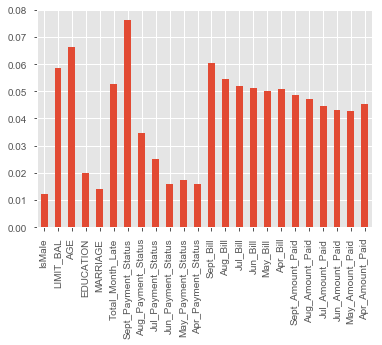

In [549]:
# # Important Attributes - RF Model
columns = ['IsMale','LIMIT_BAL','AGE', 'EDUCATION', 'MARRIAGE','Total_Month_Late',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']

clf = RandomForestClassifier(n_estimators=150,random_state=1)

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train], y[train])
    y_hat[test] = clf.predict(X[test]) # y_pred is y_hat[test] 

print(clf.feature_importances_) # call .cross_val_score() to get this .feature_importances_()
weights = pd.Series(clf.feature_importances_,index=columns) # rf_task1.feature_importances_[:,]
plt.figure(figsize=(6,4))
weights.plot(kind='bar')


Overall, the top important features including history of monthly payment status 'Total_Month_Late', monthly bill amount, monthly payment amount and monthly payment status. The more recent the months, the higher the weights.
This confirms the correlations in the above heat maps, which show the likelihood of defaulting on a loan is mostly correlated to the payment status of the loan from April to September of 2005 and that their correlation increases each month. This makes sense as the delinquency bubble moving through the correlations between Apr to Sept. The correlation decreases as customers caught up and cured out of delinquency. 

The similar weight pattern of monthly bill amount and monthly payment amount (among the groups, highest Sept_Bill corresponds with the highest Sept_Amount_Paid, the second highest Aug_Bill correspons with the second highest Aug_Amount_Paid, and so on) recognized the relationship of these 2 sets of features. 

You can see that we also did not normalize our weights for the random forest feature importance graphs. this is because random forest models do not need to be normalized. Since the data is being sorted into a collection of trees, a normalization would result in the same output, meaning random forest models are resistant to transformations of the data. 

 <a href="#top">Back to top</a>

<div id='MODEL1'/>
# 4. Modeling and Evaluation 1: Train and Adjust Parameters

We will investigate simple clustering methods for making the clusters discrete: Kmeans, hierarchical agglomerative clustering (HAC), and DBSCAN. We will then adjust the parameters to find the best parameters of each model. We will apply these best parameters to find the best clustering for each model based on theirs classifications metrics value results. We will be evaluating the output of these methods based on their accuracy, precision, recall, and F-measure. 

   **Process for each clustering method** 
    * Choose a subset of features from the dataset to cluster upon. Below are our possible sets. 
    * Cluster the features assuming according to a given algorithm
    * Replace the features with their discrete cluster labels as a form of discretization
    * Perform classification using the new feature from the dataset

It probably makes sense to make the 'EDUCATION', 'MARRIAGE', and 'IsMale' variables into a single discrete variable representing clusters of individual information. 
We will make the 'LIMIT_BAL' and 'AGE' into a single discrete variable representing clusters of limit balance. 
We will make the 'Total_Month_Late' and all the monthly payment status into a single discrete variable representing clusters of payment status group.  

It is unclear exactly where to make the classes discrete and how many levels we should make, so we will try a few different parameterizations to investigate this. 
If the evaluation metrics for the 'EDUCATION', 'MARRIAGE', and 'IsMale' group and 'LIMIT_BAL' and 'AGE' are not as good, we will try to stack the above cluster groups and cluster the. For this dataset, it probably makes sense to try and cluster monthly bill amount and monthly payment amount together because they have similar information and can likely be combined. 

Again, we will need to try different parameterizations (numbers of cluster and the algorithm for clustering). 

For all our models, we will use random state of 1 to keep the same random test/train splits, since setting a random_state to integer to generate data from the same seed each time. This allows us to have a consistent apple-to-apple comparison when comparing the performance between models. [44] 

 <a href="#top">Back to top</a>

## Training and testing split method [15], [16], [43]: 

From our analysis in Lab 2, our model selection task if more beneficial with Stratified 10-Fold Cross Validation. 
We chose StratifiedKFold over StratifiedShuffleSplit for the main reason to address the imbalanced binary response classes. Almost 80% of the data is a false response for default classification. 
In StratifiedKFold, data don't overlap in folds and it will always be different in each fold. And in StratifiedShuffleSplit it can be repetitive every time it splits and that there is a high chance that our test result 
will be bias, with mostly 0 default classification. 
However, StratifiedKFold can be a problem if the data set if small, preventing the effectiveness of randomization. 
With 30,000 data, the size of our data set is relatively large and it can benefit more from the Stratified 10-Fold Cross Validation than from the Stratified Shuffle Split. Note that sample size can also have an effect on the suitability of the model. Smaller sample sizes can easily result in a model with high bias with low variance due to the lack of equally distributed and representative samples. Large sample sizes provide a better scenario to ensure bias is minimized. 

For our approach here again, we will be using a Stratified 10-Fold Cross Validation for our analysis. 
10 folds comprises in creating 10 subsamples to produce a more significant number of samples. We can then separate one of the subsamples for testing and the remaining subsamples for training, do this for every possible combination of testing/training folds and average the results. This is known as cross-validation. 
Doing 10-fold cross-validation is like doing a (not random) split k times, and then averaging. A small sample might not benefit from 10-fold cross-validation, but since our data set is relatively large, our data does benefit from this cross-validation. 

With this very unbalanced design, if we use normal randomized groups, we will likely end up building models with few (or even none) data points from the positive class. When we are building a model that is trained on data that have very few positives, the model won't be able to effectively predict the rare group. The stratified cross-validation allows for randomization while making sure that the split unbalanced datasets have equally represented classes. The bottom line is, Stratification minimizes sample selection bias and ensures certain segments of the population are not overrepresented or underrepresented. Stratification rearranges the data to ensure each fold is a good representation of a whole. Even though, a random split is a quicker way of estimating, but might be more prone to sampling bias than k-fold cross-validation.
For future study, we can try to combine stratification and random split is an attempt to have an effective and efficient sampling strategy that preserves label distribution.

Stratified 10-Fold Cross Validation will not only provide us with a thorough method of splitting, training, and testing our models against our data set but also ensures our model maintains a similar level of accuracy as it is being developed.

By using 10 folds cross-validation, the dataset is split randomly into 10 equal parts. Of these 10 parts, 9 of them will be used for training. The final part will be used for testing the data after it is trained. This means that 90% of the data will be used for training and 10% will be used for testing. Since we are using cross-validation, this process will occur 10 times since for our k-folds cross validation k=10. This allows all observations to be used for both training and testing in separate instances. Since in this case we are stratifying, the folds will also take into account the proportions of our classification labels. In our process, the data will be rearranged 10 times and it is mostly appropriate for us to use in our analysis due to the characteristic of our data set.

To test model prediction accuracy, the binary response of the dataset will use stratified k-fold for cross validation. This will also address the imbalanced binary response. Almost 80% of the data is a false response. Stratified will ensure each fold will have the same amount in each response, so one model will not have a high representation of false. The large size of our data set helps to achieve more reliable average accuracy and measure metrics. 

Note that the stratified sampling may also be designed to equally distribute some features the next training and testing sets. For example, if each sample represent one individual, and one feature is age, it is sometimes useful to have the same age distribution in both the training and testing sets. Another note is that accuracy score may improve by increasing the number of stratified k fold splits. The theory being that the more folds - to certain degree, the higher the accuracy score. However, the more folds you generate, the more models to be train, the more computationally intense will be needed. Also, we must be careful with increasing folds, because when the number of folds increased, so does error rate. We prefer that our accuracy increase outweighs the increased of false negatives and false positives.

 <a href="#top">Back to top</a>

<div id='BRF'/>
## Baseline Classification Performance - Random Forest (RF)

Let's start by performing 10 fold cross validation and using the raw features in a Random Forest classifier. Let's get the average accuracy of classifying whether someone defaults or not.

 <a href="#top">Back to top</a>

In [360]:
%%time

# Let's start with a simple classifier and ten fold cross validation, calculating accuracy to start.
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

# make a copy of the data frame for training for Modeling and Evaluation 1
df_copy_base = df_copy1.copy() 

y = df_copy_base['default'].values # get the predictor values
X = df_copy_base[['IsMale','LIMIT_BAL','AGE', 'EDUCATION', 'MARRIAGE',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else except 'Total_Month_Late' in the raw data to predict!

y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
print (cv)
print (cv.get_n_splits(X,y)) # should be 10 here


StratifiedKFold(n_splits=10, random_state=1, shuffle=False)
10
CPU times: user 23.1 ms, sys: 15.8 ms, total: 38.9 ms
Wall time: 37.2 ms


**Use Grid Search CV to find the best n_estimators and other parameters for Random Forest**

In [29]:
%%time
# get up a function for Grid Search CV. [14] - [17]
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification

def grid_searcher(X, y, model, params, cv_object):
    clf = GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(X, y)
    return clf 


CPU times: user 35.5 ms, sys: 57.3 ms, total: 92.8 ms
Wall time: 129 ms


/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/heidinguyen/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [30]:
%%time
# RF with the raw features in the dataset
model = RandomForestClassifier() 
params = { 
    'n_estimators': [10, 50,150],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 30, 50]}

# call the function:
rfc_clf = grid_searcher(X, y, model, params,10) # n_splits=10, can use: cv.get_n_splits(X3,y3)

#print(clf.grid_scores_ )
print("The best estimator: ",rfc_clf.best_estimator_)
print("The best accuracy score is: ", rfc_clf.best_score_*100)
print("The best parameters of model is: ",rfc_clf.best_params_)


The best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The best accuracy score is:  82.0266666667
The best parameters of model is:  {'n_estimators': 150, 'max_depth': 10}
CPU times: user 8.55 s, sys: 400 ms, total: 8.95 s
Wall time: 4min 3s


Grid search reveals:

The best accuracy score is 82%.

Best n_estimators is 150. A higher n_estimators should produce better accuracy, however, at certain point, the time efficiency may be too excessive for a very large value of n_estimators. If the data set is large, our regular computer may not be able to handle the task. A higher n_estimators may take too long to generate result and the output may not be significantly different. Best max_depth is 10. This is also reasonable since our data is bias and is relatively small.

Therefore, for the purpose of this lab, we will use the higher max_depth=10 and n_estimators=150 for further analysis. Others parameters are recommended as default.


**Baseline Random Forest (RF) Classification Performance with n_estimators=150 and max_depth=10** 

<a href='#top'>Back to top</a>

In [366]:
# set up arrays to store data
rf_accuracy_task1_anova = [] 
rf_conf_task1_anova = [] 
rf_recall_task1_anova = [] 
rf_precision_task1_anova = [] 
rf_fmeasure_task1_anova = [] 
rf_auc_task1_anova = []  

In [362]:
%%time
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# get a handle to the classifier object, which defines the type
rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=None) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    rf_task1.fit(X[train], y[train])
    y_pred_proba = rf_task1.predict_proba(X[test])[:, 1]
    fpr_rf_task1, tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = rf_task1.predict(X[test]) # y_pred is y_hat[test] 
    
       # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    rf_accuracy_task1_anova.append(acc)
    rf_conf_task1_anova.append([conf])
    rf_recall_task1_anova.append(recall)
    rf_precision_task1_anova.append(precision)
    rf_fmeasure_task1_anova.append(f)
    rf_auc_task1_anova.append(auc_score)  

# with std 
acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
# print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

# metrics
acc = accuracy_score(y[test], y_hat[test]) 
auc = roc_auc_score(y[test], y_pred_proba) 

print("-----------------------------------") 
print("RF - Baseline Classification Report") 
print("-----------------------------------") 
print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
print ("mean acc", np.mean(km_accuracy_task1_anova), "+-", np.std(km_accuracy_task1_anova))
print ("mean auc", np.mean(km_auc_task1_anova)) 

print ('Base RF, accuracy score: {0:.4f}%'.format(acc*100)) # instance acc score 
print(mt.confusion_matrix(y,y_hat))# confusion matrix  
print("AUC: {0:.4f}%" .format(auc*100))  
print(classification_report(y[test], y_hat[test])) 


-----------------------------------
RF - Baseline Classification Report
-----------------------------------
Average accuracy +/- std:  82.0269539541 +- 1.07106396435
mean acc 0.820336150619 +- 0.0101357753916
mean auc 0.778998634405
Base RF, accuracy score: 82.6609%
[[22226  1138]
 [ 4259  2377]]
AUC: 80.0017%
             precision    recall  f1-score   support

          0       0.84      0.96      0.90      2336
          1       0.72      0.35      0.47       663

avg / total       0.81      0.83      0.80      2999

CPU times: user 3min 28s, sys: 3.28 s, total: 3min 31s
Wall time: 1min 15s


The baseline performance with RF for all the raw data is 82.03% +- 1.01% average accuracy, mean AUC 77.89%.
The executing time is 1min 15s for RF. 

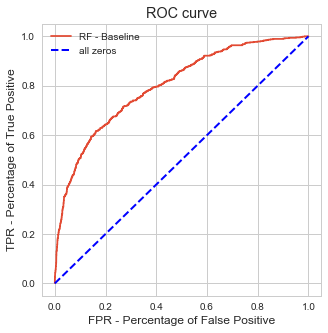

In [363]:
# ROC for RF Baseline
plt.figure(figsize=(5,5))
plt.plot(fpr_rf_task1, tpr_rf_task1, label='RF - Baseline')

## Draw the diagonal line 
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='all zeros') # diagonal line

##Title, label, and legend 
plt.xlabel('FPR - Percentage of False Positive')
plt.ylabel('TPR - Percentage of True Positive')
plt.title('ROC curve')
plt.legend(loc="upper left")
plt.show()


<div id='KM' />
## KMeans

"The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields." [40] 

Our initialization strategy is varying k-means++. k-means++ selects a point with probability proportional to the square of its distance to the nearest preceding centroid. This means, if we pick the farthest point, we often get points that are at the edges of their true clusters, but if we choose randomly as described, then you're more likely to get one near the center of the true cluster. [45]

Since we don't really know beforehand how many clusters our data contains, we will choose the first k-means++ randomly as 8.



 <a href="#top">Back to top</a>

### We will start by using kmeans clustering on 'EDUCATION' and 'LIMIT_BAL' together.**

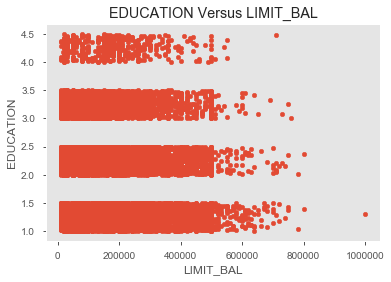

In [16]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X2 = df_copy[['EDUCATION','LIMIT_BAL']].values

plt.scatter(X2[:, 1], X2[:, 0]+np.random.random(X2[:, 1].shape)/2, 
             s=20)
plt.xlabel('LIMIT_BAL'), plt.ylabel('EDUCATION') # 1 for 'married'; 2 for 'single'; 3 for 'Others'
plt.grid()
plt.title('EDUCATION Versus LIMIT_BAL')
plt.show()


We can see that among graduate school graduates (Education =1), the points are more dense while 'Others' group (Education = 4) is the least dense. Higher credit limit is distributed more among those with graduate school degree (EDUCATION = 1), next is among those with college degree (EDUCATION = 2). However, the range of credit limit of all the education class are very similar (below 600,000 NT dollars). Notice also a few outliers among all the 4 levels of education. 

<a href="#top">Back to top</a>

We randomly picked n_cluster = 8 here.

In [364]:
%%time
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X2 = df_copy1[['EDUCATION','LIMIT_BAL']].values

cls = KMeans(n_clusters=8, #  initialization with n_clusters = 8
             init='k-means++', # number of clusters
             random_state=1) 
cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['IsMale', 'MARRIAGE', 'AGE', 
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!

X = np.column_stack((X,pd.get_dummies(newfeature)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
print (cv)
print (cv.get_n_splits(X,y)) # should be 10 here


StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
10
CPU times: user 629 ms, sys: 49.3 ms, total: 678 ms
Wall time: 381 ms


In [368]:
%%time
# get a handle to the classifier object, which defines the type
km_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    km_rf_task1.fit(X[train], y[train])
    y_pred_proba = km_rf_task1.predict_proba(X[test])[:, 1]
    km_fpr_rf_task1, km_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task1.predict(X[test]) # y_pred is y_hat[test] 

#metrics   
acc_mt = mt.accuracy_score(y, y_hat)
recall = mt.recall_score(y, y_hat)
precision = mt.precision_score(y, y_hat)
f = mt.f1_score(y, y_hat)
mt_auc = mt.roc_auc_score(y, y_hat) 

# km_accuracy_task1_anova = [] 
# km_conf_task1_anova = [] 
# km_recall_task1_anova = [] 
# km_precision_task1_anova = [] 
# km_fmeasure_task1_anova = [] 
# km_auc_task1_anova = []  

# with std 
acc_std = cross_val_score(km_rf_task1,X,y=y,cv=cv)
# print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

# metrics 
acc = accuracy_score(y[test], y_hat[test]) # we will use this for the comparison
auc = roc_auc_score(y[test], y_pred_proba) 

print("-----------------------------------") 
print("RF - Baseline Classification Report") 
print("-----------------------------------") 
print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
# print("Accuracy: %.4f" % accuracy_score(y[test], y_hat[test])) 
print ('KM1 - RF, accuracy score: {0:.4f}%'.format(acc*100)) # instance acc score 
# print("Metrics Accuracy: %.4f" % mt.accuracy_score(y, y_hat)) # .format(acc*100)) 
print(mt.confusion_matrix(y,y_hat))# confusion matrix  
# print("AUC: %.4f" % roc_auc_score(y[test], y_pred_proba))
print("AUC: {0:.4f}%" .format(auc*100))  
print(classification_report(y[test], y_hat[test])) 

-----------------------------------
RF - Baseline Classification Report
-----------------------------------
Average accuracy +/- std:  81.9635828371 +- 0.921330996284
KM1 - RF, accuracy score: 82.3274%
[[22221  1143]
 [ 4268  2368]]
AUC: 79.8453%
             precision    recall  f1-score   support

          0       0.84      0.96      0.89      2336
          1       0.70      0.35      0.46       663

avg / total       0.81      0.82      0.80      2999

CPU times: user 4min 1s, sys: 4.31 s, total: 4min 5s
Wall time: 1min 31s


Note that we randomly picked n_cluster = 8 here.
So it seems that the average accuracy and the deviation of the folds have stayed about the same, 82.05 +- 1.08 average accuracy vs. 82.03% +- 1.07% average accuracy of the full Random Forest model. 
Overall recall, precision, F-score and AUC are slightly lower than those of Random Forest (RF), recall 82% vs. RF 83%, AUC, precision and F-measure are the same as RF, and AUC 80%.

#### Find the best n_clusters using for 'EDUCATION' and 'LIMIT' set of attributes: 



    * Selecting the number of clusters with silhouette analysis on KMeans clustering:

        Silhoutte is a method of measuring consistency within a cluster of data. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. From the above plot, Eucledian distance (value ~0.6) is a better suited proximity measure than the cosine similarity (value <0.0). [49] 

 <a href="#top">Back to top</a>

For our data, a sample of more than 15000 took a very long time and the result was all -1. It was impractical for this data set to use. Below is an example of 15000. Since we could not use the entire set of data, we will use this as a guide to find the range of n_clusters for the KMeans n_cluster 'for' loop iteration. 

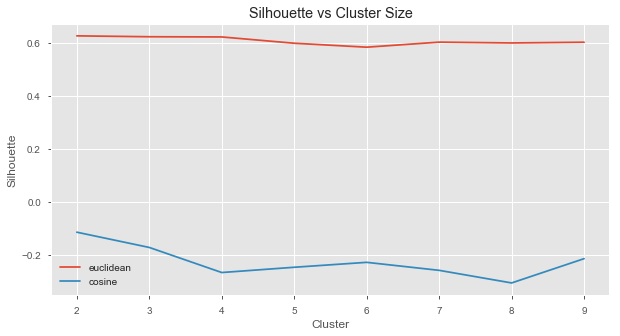

CPU times: user 1min 46s, sys: 30.2 s, total: 2min 16s
Wall time: 2min 9s


In [23]:
%%time

# do it for the k-means
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

X2 = df_copy1[['LIMIT_BAL','EDUCATION']].values[:15000]

seuclid = []
scosine = []  

k = range(2,10)
for n_fare in k:  
    kmeans_model = KMeans(n_clusters=n_fare, init="k-means++").fit(X2)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(X2, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(X2, labels, metric='cosine'))
#     print (metrics.silhouette_score(X2, labels, metric='euclidean'))
#     print (metrics.silhouette_score(X2, labels, metric='cosine'))
    
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show() 

For a sample of 15000 data, we can see that cluster 2 has the highest silhouette score. 
Next, we will run the Kmeans iteration for n_clusters in range (2,10) to find the number of cluster that produce the best accuracy, AUC, and other evaluation metrics. 

In [34]:
%%time 

X2 = df_copy1[['EDUCATION','LIMIT_BAL']].values

params = []
for n_fare in range(2,10):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X2)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append 
        y = df_copy1['default']
        X = df_copy1[['IsMale', 'MARRIAGE','AGE',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
    
        X = np.column_stack((X,pd.get_dummies(newfeature_fare)))

        # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
    
        # get a handle to the classifier object, which defines the type
        km_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            km_rf_task1.fit(X[train], y[train])
            y_pred_proba = km_rf_task1.predict_proba(X[test])[:, 1]
            km_fpr_rf_task1, km_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = km_rf_task1.predict(X[test]) # y_pred is y_hat[test] 

        # with std 
        acc_std = cross_val_score(km_rf_task1,X,y=y,cv=cv)
        # print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

#         acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

#         print ("Clusters",n_fare, "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("=============" )
        print ("Clusters",n_fare)
  
        # metrics
        acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 

#         print("-----------------------------------") 
#         print("RF - Baseline Classification Report") 
#         print("-----------------------------------") 
        print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
        # print("Accuracy: %.4f" % accuracy_score(y[test], y_hat[test])) 
        print ('KM1 - RF, accuracy score: {0:.4f}%'.format(acc*100)) # instance acc score 
        # print("Metrics Accuracy: %.4f" % mt.accuracy_score(y, y_hat)) # .format(acc*100)) 
        # print(mt.confusion_matrix(y,y_hat))# confusion matrix  
        # print("AUC: %.4f" % roc_auc_score(y[test], y_pred_proba))
        print("AUC: {0:.4f}%" .format(auc*100))  
        # print(classification_report(y[test], y_hat[test])) 


Clusters 2
Average accuracy +/- std:  81.9769461708 +- 1.00170987275
KM1 - RF, accuracy score: 82.3941%
AUC: 79.5314%
Clusters 3
Average accuracy +/- std:  81.990271726 +- 1.00052766153
KM1 - RF, accuracy score: 82.4942%
AUC: 79.6310%
Clusters 4
Average accuracy +/- std:  82.0769439574 +- 1.03012582913
KM1 - RF, accuracy score: 82.3608%
AUC: 79.6546%
Clusters 5
Average accuracy +/- std:  82.0402617323 +- 0.980972058857
KM1 - RF, accuracy score: 82.3941%
AUC: 79.5704%
Clusters 6
Average accuracy +/- std:  82.0269561726 +- 1.06777259016
KM1 - RF, accuracy score: 82.3274%
AUC: 79.8619%
Clusters 7
Average accuracy +/- std:  82.0036083967 +- 1.03267483921
KM1 - RF, accuracy score: 82.6942%
AUC: 79.7480%
Clusters 8
Average accuracy +/- std:  82.01028284 +- 1.02155053686
KM1 - RF, accuracy score: 82.3608%
AUC: 79.8314%
Clusters 9
Average accuracy +/- std:  82.08695618 +- 1.05106438808
KM1 - RF, accuracy score: 82.4275%
AUC: 79.5931%
CPU times: user 26min 52s, sys: 20.5 s, total: 27min 13s
Wal

So it seems that the accuracy and AUC are fairly stagnant. But accuracy has a tight standard deviation. For our objective, when accuracy is close, we want to pick the parameter that give the best AUC. 
It seems that about the best we can do with this clustering is with n_cluster = 6, with accuracy and deviation is 82.02 +- 1.07, AUC is 79.86%. Executing time is 9min 14s. 

Let's now try the same with the next clusters. 

### Kmeans Clustering with 'AGE', 'IsMale', and 'MARRIAGE' Group

It also might make sense to 'MARRIAGE', 'AGE', and 'IsMale' variables into a single discrete variable representing clusters of individual information. Again, we will need to try different parameterizations (numbers of cluster and the algorithm for clustering)

 <a href="#top">Back to top</a>

**Plots of 'AGE' vs. 'IsMale' and 'AGE' vs. 'MARRIAGE'**

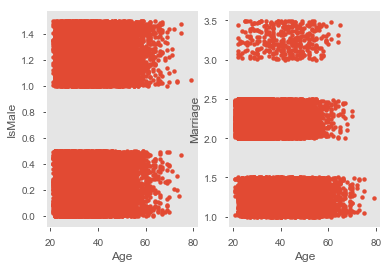

In [36]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

X3 = df_copy1[['AGE', 'IsMale', 'MARRIAGE']]

plt.figure()
plt.subplot(1,2,1)
X3=X3.values
# plt.scatter(X3[:, 0], X3[:, 1]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.scatter(X3[:, 0], X3[:, 1]+np.random.random(X3[:, 1].shape)/2, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('IsMale')
plt.grid()

plt.subplot(1,2,2)
# plt.scatter(X3[:, 0], X3[:, 2]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.scatter(X3[:, 0], X3[:, 2]+np.random.random(X3[:, 1].shape)/2, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('Marriage')
plt.grid()


Age vs IsMale: for both males(=1) and females(=0), the age ranges from 20- 60 years old are more populated and both sexes have about equal representation in our dataset.

Age vs Marriage: the "Married" (=1) group has more density in the age ranging from 20- 70 yrs od while 'Single' (=2) group is mostly between 20- 55yrs od age. The 'Others'(=3) group has very sparse data and ranges from age 20- 50 yrs old.


Again, we will pick n_cluster = 8 randomly.

In [37]:
%%time
X3 = df_copy1[['IsMale', 'MARRIAGE','AGE']].values

cls = KMeans(n_clusters=8, init='k-means++',random_state=1) #  initialization
cls.fit(X3)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['EDUCATION','LIMIT_BAL',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
X = np.column_stack((X,pd.get_dummies(newfeature)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=1 so that we will always get the same random train/test split from the same seed.

# get a handle to the classifier object, which defines the type
km_rf_task2 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    km_rf_task2.fit(X[train], y[train])
    y_pred_proba = km_rf_task2.predict_proba(X[test])[:, 1]
    km_fpr_rf_task2, km_tpr_rf_task2, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task2.predict(X[test]) # y_pred is y_hat[test]

# with std 
acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
# print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

# metrics
acc = accuracy_score(y[test], y_hat[test]) 
auc = roc_auc_score(y[test], y_pred_proba) 

print("-----------------------------------") 
print("RF - Baseline Classification Report") 
print("-----------------------------------") 
print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
# print("Accuracy: %.4f" % accuracy_score(y[test], y_hat[test])) 
print ('KM2 - RF, accuracy score: {0:.4f}%'.format(acc*100)) # instance acc score 
# print("Metrics Accuracy: %.4f" % mt.accuracy_score(y, y_hat)) # .format(acc*100)) 
print(mt.confusion_matrix(y,y_hat))# confusion matrix  
# print("AUC: %.4f" % roc_auc_score(y[test], y_pred_proba))
print("AUC: {0:.4f}%" .format(auc*100))  
print(classification_report(y[test], y_hat[test])) 

-----------------------------------
RF - Baseline Classification Report
-----------------------------------
Average accuracy +/- std:  81.9769450593 +- 1.05587307198
KM2 - RF, accuracy score: 82.5942%
[[22233  1131]
 [ 4268  2368]]
AUC: 80.0797%
             precision    recall  f1-score   support

          0       0.84      0.96      0.90      2336
          1       0.71      0.35      0.47       663

avg / total       0.81      0.83      0.80      2999

CPU times: user 4min 18s, sys: 4.83 s, total: 4min 23s
Wall time: 1min 41s


This discretization does not help to increase the accuracy or AUC on average, the deviation from the mean of accuracy also looks stagnant. AUC is slightly better here. We will do more comparison next when we find the best n_cluster for this group. In our opinion, it may not make sense to compare this result with the X2 group ('LIMIT_BAL", "ECUDATION") at this point. 

<a href="#top">Back to top</a>

**Selecting the number of clusters with silhouette analysis on KMeans clustering:**

For 'IsMale', 'MARRIAGE', and 'AGE' clustering, a sample of more than 10000 took a very long time. It was impractical for this data set to use the full data set. Below is an example of 10000. Since we could not use the entire set of data, we will use this as a guide to find the range for the KMeans n_cluster 'for' loop iteration. 

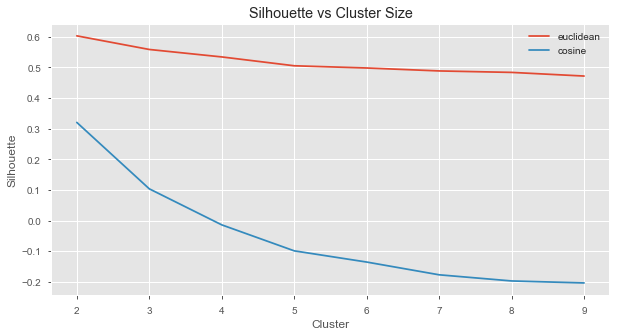

CPU times: user 48.3 s, sys: 12.4 s, total: 1min
Wall time: 56.2 s


In [50]:
%%time

# do it for the k-means
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

X3 = df_copy1[['AGE', 'IsMale', 'MARRIAGE']].values[:10000]

seuclid = []
scosine = []  

k = range(2,10)
for n_fare in k:  
    kmeans_model = KMeans(n_clusters=n_fare, init="k-means++").fit(X3)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(X3, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(X3, labels, metric='cosine'))
    
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show() 

For a sample of 10000 data, we can see that cluster 2 has the highest silhouette score and the trend is downward trend. Next, we will run the Kmeans iteration for n_clusters in range (2,10) to find the number of cluster that produce the best accuracy, AUC, and other evaluation metrics.

Next, we will run fit Kmeans with n_clusters running from 2 to 10. 

 <a href="#top">Back to top</a>

In [51]:
%%time

X3 = df_copy1[['IsMale', 'MARRIAGE','AGE']].values

params = []
for n_fare in range(2,10):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X3)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append 
        y = df_copy1['default']
        X = df_copy1[['EDUCATION','LIMIT_BAL',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!

        X = np.column_stack((X,pd.get_dummies(newfeature_fare)))

        # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=1 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
    
        # get a handle to the classifier object, which defines the type
        km_rf_task2 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            km_rf_task2.fit(X[train], y[train])
            y_pred_proba = km_rf_task2.predict_proba(X[test])[:, 1]
#             km_fpr_rf_task2, km_tpr_rf_task2, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = km_rf_task2.predict(X[test]) # y_pred is y_hat[test]

        # with std 
        acc_std = cross_val_score(km_rf_task2,X,y=y,cv=cv)
        # print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

#         acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

#         print ("Clusters",n_fare, "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("=============" )
        print ("Clusters",n_fare)
        
        # metrics
        acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 

        print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
        print("AUC: {0:.4f}%" .format(auc*100))  


Clusters 2
Average accuracy +/- std:  82.0036206141 +- 1.08398820192
AUC: 80.1286%
Clusters 3
Average accuracy +/- std:  82.0602717311 +- 1.01244720622
AUC: 79.9126%
Clusters 4
Average accuracy +/- std:  82.0169595063 +- 1.09421078302
AUC: 79.9683%
Clusters 5
Average accuracy +/- std:  81.9636217204 +- 1.09750322155
AUC: 79.9230%
Clusters 6
Average accuracy +/- std:  82.0102772819 +- 1.05755536846
AUC: 79.8542%
Clusters 7
Average accuracy +/- std:  82.0069439515 +- 1.0313600986
AUC: 79.9645%
Clusters 8
Average accuracy +/- std:  82.0036106174 +- 1.0075490204
AUC: 80.0797%
Clusters 9
Average accuracy +/- std:  82.043603953 +- 1.00820071003
AUC: 79.9548%
CPU times: user 27min 23s, sys: 21.8 s, total: 27min 45s
Wall time: 9min 29s


So it seems that the accuracy and AUC are fairly stagnant. But accuracy has a tight standard deviation. 
This discretization does not help to increase the accuracy or AUC on average. The deviation from the mean also does not seem to be significantly different than of the above discretization. Executing time is also similar to that of the X2 ('LIMIT_BAL','EDUCATION') with its best n_cluster = 6. 
It seems that about the best we can do with this clustering is with n_cluster = 8, with accuracy and deviation is 82.00 +- 1.01, AUC is 80.07%. 

Let try with the newly added attribute Total_Month_Late and all monthly payment status. 

### Cluster of Total_Month_Late and all monthly payment status attributes

**Selecting the number of clusters with silhouette analysis on KMeans clustering:**

For Total_Month_Late and monthly payment status clustering, a sample of more than 10000 took a very long time. It was impractical for this data set to use the full data set. Below is an example of 10000. Since we could not use the entire set of data, we will use this as a guide to find the range of n_cluster for the KMeans n_cluster 'for' loop iteration.

 <a href="#top">Back to top</a>

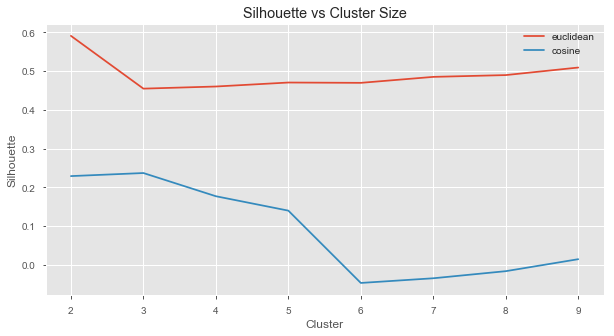

CPU times: user 1min 5s, sys: 16.6 s, total: 1min 21s
Wall time: 1min 19s


In [52]:
%%time

# do it for the k-means
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

X4 = df_copy1[['Total_Month_Late','Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status']].values[:10000]

seuclid = []
scosine = []  

k = range(2,10)
for n_fare in k:  
    kmeans_model = KMeans(n_clusters=n_fare, init="k-means++").fit(X4)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(X4, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(X4, labels, metric='cosine'))
    
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show() 

For a sample of 10000 data, we can see that cluster 2 and 3 have the highest silhouette score and the trend is downward trend. Next, we will run the Kmeans iteration for n_clusters in range (2,10) to find the number of cluster that produce the best accuracy, AUC, and other evaluation metrics.

In [54]:
%%time

# We will try to find the best n_clusters of this cluster. 
X4 = df_copy1[['Total_Month_Late','Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status']].values

params = []
for n_fare in range(2,10):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X3)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append 
        y = df_copy1['default']
        X = df_copy1[['EDUCATION','LIMIT_BAL', 'IsMale', 'MARRIAGE','AGE', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
        X = np.column_stack((X,pd.get_dummies(newfeature_fare)))

        # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
    
        # get a handle to the classifier object, which defines the type
        km_rf_task3 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            km_rf_task3.fit(X[train], y[train])
            y_pred_proba = km_rf_task3.predict_proba(X[test])[:, 1]
#              km_fpr_rf_task3, km_tpr_rf_task, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = km_rf_task3.predict(X[test]) # y_pred is y_hat[test]

        # with std 
        acc_std = cross_val_score(km_rf_task3,X,y=y,cv=cv)
        # print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

#         acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

#         print ("Clusters",n_fare, "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("=============" )
        print ("Clusters",n_fare)
    
        # metrics
#         acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 

        print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
        print("AUC: {0:.4f}%" .format(auc*100))  


Clusters 2
Average accuracy +/- std:  78.9633881307 +- 0.566380363858
AUC: 74.8231%
Clusters 3
Average accuracy +/- std:  78.9134470163 +- 0.634601510181
AUC: 74.9432%
Clusters 4
Average accuracy +/- std:  78.810083673 +- 0.560649810544
AUC: 75.1498%
Clusters 5
Average accuracy +/- std:  78.8467670133 +- 0.616910337189
AUC: 75.0558%
Clusters 6
Average accuracy +/- std:  78.8100725582 +- 0.467100083142
AUC: 75.0192%
Clusters 7
Average accuracy +/- std:  78.78338478 +- 0.466686975444
AUC: 74.8743%
Clusters 8
Average accuracy +/- std:  78.90009701 +- 0.509946476256
AUC: 74.8108%
Clusters 9
Average accuracy +/- std:  78.8400547856 +- 0.405010280065
AUC: 74.9247%
CPU times: user 31min 22s, sys: 34.2 s, total: 31min 56s
Wall time: 11min 58s


Again, this discretization does not help to increase the accuracy on average, but it is helping in the lowering of the deviation from the mean. It seems that about the best we can do with this clustering is with n_cluster = 4, with accuracy and deviation is 78.81 +- 0.56, AUC is 75.15%. 
Next, we can try to stack X2 or X3 clustering together with this clustering to see if the performance is better. 

<a href="#top">Back to top</a>

### Kmeans with Combined X2 ('EDUCATION', 'LIMIT_BAL') and X3 ('AGE', 'IsMale', 'MARRIAGE') clusterings

As we found in the above, the best n_cluster for X2('EDUCATION', 'LIMIT_BAL') is 6 and for X3 ('AGE', 'IsMale', 'MARRIAGE') is 8, for this combined Kmean clustering, we will iterate 'for' loops with n_cluster runs from 4 to 10 for each loop. This range of (4,10) should be sufficient and also to help reducing the executing time of the 'for' loop. 

 <a href="#top">Back to top</a>

In [61]:
%%time 

X2 = df_copy1[['EDUCATION','LIMIT_BAL']]
X3 = df_copy1[['AGE','IsMale','MARRIAGE']]

params = []
for n_fare in range(4,10):
    for n_fam in range(4,10):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X2)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X3)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

         # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.

        # get a handle to the classifier object, which defines the type
        km_rf_task12 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            km_rf_task12.fit(X[train], y[train])
            y_pred_proba = km_rf_task12.predict_proba(X[test])[:, 1]
            y_hat[test] = km_rf_task12.predict(X[test]) # y_pred is y_hat[test]
            
        # with std 
        acc_std = cross_val_score(km_rf_task12,X,y=y,cv=cv)
        # print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

        # acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

        # metrics
        acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 
#         print ("=============" )
        print ("Clusters",n_fare,n_fam, "Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )
        

Clusters 4 4 Average accuracy =  82.01362395 +- 1.07392096944 AUC =  79.5599792868
Clusters 4 5 Average accuracy =  81.9069383852 +- 1.03349215893 AUC =  79.3418381578
Clusters 4 6 Average accuracy =  81.986973946 +- 1.13008465641 AUC =  79.73889569
Clusters 4 7 Average accuracy =  81.9969461708 +- 1.0310543084 AUC =  79.6891141862
Clusters 4 8 Average accuracy =  81.9769295023 +- 0.990864353684 AUC =  79.4915700738
Clusters 4 9 Average accuracy =  81.9902728345 +- 1.03380894611 AUC =  79.5231435567
Clusters 5 4 Average accuracy =  81.9736228341 +- 1.06703927922 AUC =  79.5828684477
Clusters 5 5 Average accuracy =  81.9836106145 +- 1.01936536233 AUC =  79.5938126304
Clusters 5 6 Average accuracy =  81.9869339467 +- 1.00671688476 AUC =  79.6805589992
Clusters 5 7 Average accuracy =  81.9369661648 +- 1.10638492479 AUC =  79.5696644042
Clusters 5 8 Average accuracy =  81.9869539504 +- 1.05393797773 AUC =  79.7571682783
Clusters 5 9 Average accuracy =  81.946916166 +- 0.938709460504 AUC = 

Again, this combination discretization does not help to increase the accuracy on average, standard deviation also does not improve. It seems that about the best we can do with this clustering is with n_cluster = 6 for X2 and n_cluster = 6 for X3, with accuracy and deviation is 82.03 +- 1.06, AUC is 79.93%. 

### Kmeans with Combined X2 ('EDUCATION', 'LIMIT_BAL') and X4 ('Total_Month_Late', monthly payment status) clusterings

As we found in the above, the best n_cluster for X2('EDUCATION', 'LIMIT_BAL') is 6 and for X4 ('Total_Month_Late', monthly payment status) is 4, for this combined Kmean clustering, we will iterate 'for' loops with n_cluster runs from 4 to 10 for X2 loop and n_cluster runs from 2 to 6 for X4 loop. These ranges should be sufficient and also to help reducing the executing time of the 'for' loop.

<a href="#top">Back to top</a>

In [63]:
%%time 

# Finding the best n_clusters pair for X2 and X4
X2 = df_copy1[['EDUCATION','LIMIT_BAL']]
X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

params = []
for n_fare in range(4,10):
    for n_fam in range(2,6):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X2)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X4)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['IsMale','MARRIAGE', 'AGE',
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

         # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        km_rf_task13 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            km_rf_task13.fit(X[train], y[train])
            y_pred_proba = km_rf_task13.predict_proba(X[test])[:, 1]
            km_fpr_rf_task13, km_tpr_rf_task13, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = km_rf_task13.predict(X[test]) # y_pred is y_hat[test]
            
        # with std 
        acc_std = cross_val_score(km_rf_task13,X,y=y,cv=cv)
        # print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

        # acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

        # metrics
        acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 
#         print ("=============" )
        print ("Clusters",n_fare,n_fam, "Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )
        
#         print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
#         print("AUC: {0:.4f}%" .format(auc*100))  


Clusters 4 2 Average accuracy =  79.8902626593 +- 1.02237246152 AUC =  76.4232602946
Clusters 4 3 Average accuracy =  80.4901827208 +- 0.759127338702 AUC =  77.2371007149
Clusters 4 4 Average accuracy =  80.0468782393 +- 0.826725230653 AUC =  77.0995720469
Clusters 4 5 Average accuracy =  80.2868649267 +- 0.827621992839 AUC =  76.9426085766
Clusters 5 2 Average accuracy =  79.88358155 +- 1.03567422354 AUC =  76.4342367611
Clusters 5 3 Average accuracy =  80.5201827245 +- 0.767311394761 AUC =  77.0398148722
Clusters 5 4 Average accuracy =  80.1035526863 +- 0.859406789255 AUC =  77.0754561045
Clusters 5 5 Average accuracy =  80.2235304774 +- 0.850292199417 AUC =  76.8244501436
Clusters 6 2 Average accuracy =  79.8736171041 +- 1.12434730265 AUC =  76.940219581
Clusters 6 3 Average accuracy =  80.5201905041 +- 0.780769484176 AUC =  77.5174525817
Clusters 6 4 Average accuracy =  80.1002249097 +- 0.859469294693 AUC =  77.0375227277
Clusters 6 5 Average accuracy =  80.2268860315 +- 0.89856022

This seems to give worse accuracy and worse standard deviation than X4 clustering only. AUC is also not better that of X4 clustering only. Compare to X2 clustering only, the accuracy and AUC are much worse, but the standard deviation is better. 
It seems that about the best we can do with this clustering is with n_cluster = 6 for X2 and n_cluster = 3 for X4, with accuracy and deviation is 80.52 +- 0.78, AUC is 77.52%. 

<a href="#top">Back to top</a>

### Kmeans with Combined X3 ('IsMale', 'MARRIAGE', 'AGE') and X4 ('Total_Month_Late', monthly payment status) clusterings

As we found in the above, the best n_cluster for X3('IsMale', 'MARRIAGE', 'AGE') is 3 and for X4 ('Total_Month_Late', monthly payment status) is 4, for this combined Kmean clustering, we will iterate 'for' loops with n_cluster runs from 4 to 10 for X3 loop and n_cluster runs from 2 to 6 for X4 loop. These ranges should be sufficient and also to help reducing the executing time of the 'for' loop.

<a href="#top">Back to top</a>


In [64]:
%%time 

# find best n_clusters for X3 and X4 combination
X3 = df_copy1[['IsMale','MARRIAGE', 'AGE']]
X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

params = []
for n_fare in range(4,10):
    for n_fam in range(2,6):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X3)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X4)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['EDUCATION', 'LIMIT_BAL', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

         # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        km_rf_task23 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            km_rf_task23.fit(X[train], y[train])
            y_pred_proba = km_rf_task23.predict_proba(X[test])[:, 1]
            y_hat[test] = km_rf_task23.predict(X[test]) # y_pred is y_hat[test] 

        # with std 
        acc_std = cross_val_score(km_rf_task23,X,y=y,cv=cv)
        # print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

        # acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

        # metrics
        acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 
#         print ("=============" )
        print ("Clusters",n_fare,n_fam, "Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )
        
#         print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
#         print("AUC: {0:.4f}%" .format(auc*100))  
        

Clusters 4 2 Average accuracy =  79.940298226 +- 1.12431586881 AUC =  77.3875751565
Clusters 4 3 Average accuracy =  80.4835338289 +- 0.762047503632 AUC =  77.4887523503
Clusters 4 4 Average accuracy =  80.0302682337 +- 1.00494748954 AUC =  77.3133225893
Clusters 4 5 Average accuracy =  80.2502160311 +- 0.893574808728 AUC =  77.3273660096
Clusters 5 2 Average accuracy =  79.9703015626 +- 1.16463118067 AUC =  77.1270777805
Clusters 5 3 Average accuracy =  80.4635138274 +- 0.730591906592 AUC =  77.4577599744
Clusters 5 4 Average accuracy =  80.0868938 +- 0.943712274101 AUC =  77.4724490692
Clusters 5 5 Average accuracy =  80.2368726937 +- 0.890457647306 AUC =  76.9702111614
Clusters 6 2 Average accuracy =  79.9236293304 +- 1.13172474708 AUC =  77.002172049
Clusters 6 3 Average accuracy =  80.4435127152 +- 0.714087036858 AUC =  77.3171643526
Clusters 6 4 Average accuracy =  80.1002093541 +- 0.817970416154 AUC =  77.4735467158
Clusters 6 5 Average accuracy =  80.2635260322 +- 0.90768215892

This seems to give worse accuracy and worse standard deviation than X3 clustering only. AUC is also not better that of X3 clustering only. Compare to X4 clustering only, the accuracy and AUC are better, but the standard deviation is worse. 
It seems that about the best we can do with this clustering is with n_cluster = 4 for X3 and n_cluster = 3 for X4, with accuracy and deviation is 80.48 +- 0.76, AUC is 77.49%. 


The best we can do with these new discretization methods is with individual X2 and individual X3 clustering. Best accuracy is around 82% and AUC is around 80%. All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable. 

Based on this result, we will only perform clustering on X2, X3, and X4 separately for the next clustering algorithms. 

Now, let's also try to replace features using some slightly different clustering algorithms and see what works best for classification.

 <a href="#top">Back to top</a>

<div id='HAC' />
## Agglomerative Clustering (Ward, Complete, Average) 

"The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach." [41] 

We will look at all links of ward','complete', and 'average'. As for n_clusters, similar to our initialization strategy of varying k-means++ in KMeans, since we don't really know beforehand how many clusters our data contains, we will choose the first n_clusters randomly as 8. 

<a href="#top">Back to top</a>

### Hierarchical Agglomerative Clustering (HAC) on X2 ( 'LIMIT_BAL','EDUCATION' )

Based on our silhouette score analysis and findings with Kmeans above, we will run HAC with the n_cluster range for X2 as (4,10). Link will be 'ward', 'complete', and 'average'. 

In [370]:
%%time 

from sklearn.cluster import AgglomerativeClustering

X2 = df_copy[['LIMIT_BAL','EDUCATION']]

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(4,10):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['IsMale','MARRIAGE', 'AGE', 
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

                 # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        hac_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            hac_rf_task1.fit(X[train], y[train])
            y_pred_proba = hac_rf_task1.predict_proba(X[test])[:, 1]
            hac_fpr_rf_task1, hac_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = hac_rf_task1.predict(X[test]) # y_pred is y_hat[test] 
            
            
        acc_std = cross_val_score(hac_rf_task1,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

                # metrics
#         acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 
#
#         print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("C=",n_fam,link,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )


C= 4 ward Average accuracy =  82.1136139623 +- 1.02447793853 AUC =  79.7078387467
C= 5 ward Average accuracy =  82.0436072882 +- 1.03017785222 AUC =  79.7578139528
C= 6 ward Average accuracy =  81.9869428363 +- 1.02123133623 AUC =  79.5128127647
C= 7 ward Average accuracy =  82.0602717297 +- 1.03318965758 AUC =  79.4458563193
C= 8 ward Average accuracy =  82.0136017271 +- 0.991682465219 AUC =  79.6044662596
C= 9 ward Average accuracy =  82.0102628385 +- 0.986139680479 AUC =  79.6122466373
C= 4 complete Average accuracy =  82.0635872867 +- 0.932149071882 AUC =  79.2451484018
C= 5 complete Average accuracy =  82.0435828408 +- 0.91729292653 AUC =  79.2068599041
C= 6 complete Average accuracy =  81.9969417278 +- 0.994383825954 AUC =  79.7561029153
C= 7 complete Average accuracy =  82.0236217263 +- 1.07784863883 AUC =  79.8299035104
C= 8 complete Average accuracy =  81.9835950582 +- 0.993040192401 AUC =  79.6427224736
C= 9 complete Average accuracy =  81.9802872837 +- 1.03154513853 AUC =  7

Again, all fairly good performances using different types of linkage and different numbers of clusters with accuracies between 81- 82% accross all 3 methods. The overall accuracy and AUC is similar to that of KMeans methods for X2.
Based on our selection criteria of best AUC and accuracy, C= 6 with the average link gives the best average accuracy =  82.12 +- 1.00 and AUC = 79.86% for X2. 

### HAC on X3 ( 'IsMale','MARRIAGE', 'AGE')

Based on our silhouette score analysis and findings with Kmeans above for X3, we will run HAC with the n_cluster range for X2 as (4,10). Link will be 'ward', 'complete', and 'average'. 

 <a href="#top">Back to top</a>

In [66]:
%%time 

from sklearn.cluster import AgglomerativeClustering
X3 = df_copy[['IsMale','MARRIAGE', 'AGE']]

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(4,10):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X3)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['LIMIT_BAL','EDUCATION',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

                 # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=1 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        hac_rf_task2 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            hac_rf_task2.fit(X[train], y[train])
            y_pred_proba = hac_rf_task2.predict_proba(X[test])[:, 1]
            hac_fpr_rf_task2, hac_tpr_rf_task2, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = hac_rf_task2.predict(X[test]) # y_pred is y_hat[test] 
            
            
        acc_std = cross_val_score(hac_rf_task2,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

                # metrics
#         acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 
#
#         print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("C=",n_fam,link,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )


C= 4 ward Average accuracy =  81.9435972804 +- 0.994448786013 AUC =  79.9760519329
C= 5 ward Average accuracy =  82.0235939497 +- 0.997512444197 AUC =  80.0368099031
C= 6 ward Average accuracy =  82.0269572789 +- 1.11157346649 AUC =  79.823963305
C= 7 ward Average accuracy =  82.0235961741 +- 0.975613761269 AUC =  79.9032198496
C= 8 ward Average accuracy =  82.0402506197 +- 0.958029175607 AUC =  80.0198932313
C= 9 ward Average accuracy =  82.0336272889 +- 1.07654681066 AUC =  79.9158750697
C= 4 complete Average accuracy =  82.0336139519 +- 1.06024244519 AUC =  79.9334051323
C= 5 complete Average accuracy =  82.0002895023 +- 1.0755617723 AUC =  79.9880291948
C= 6 complete Average accuracy =  82.0269328426 +- 0.983378271184 AUC =  80.0019111965
C= 7 complete Average accuracy =  82.0469328426 +- 0.9871384493 AUC =  79.8850118288
C= 8 complete Average accuracy =  82.0336183948 +- 1.06077242703 AUC =  79.9612014195
C= 9 complete Average accuracy =  82.070283956 +- 1.05843813984 AUC =  79.95

Again, all fairly good performances using different types of linkage and different number of clusters. However, 
the overall accuracy and AUC are similar to that of KMeans methods for X3.
Based on our criteria of best AUC, C= 7 with average link gives the best average accuracy =  82.12 +- 1.00 and AUC =  79.87%.

### HAC on X4 ( 'Total_Month_Late', all montly payment status attributes)

Based on our silhouette score analysis and findings with Kmeans above for X4, we will run HAC with the n_cluster range for X2 as (2,6). Link will be 'ward', 'complete', and 'average'. 

 <a href="#top">Back to top</a>

In [68]:
%%time 

from sklearn.cluster import AgglomerativeClustering
X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(2,6):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X4)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['LIMIT_BAL','EDUCATION', 'IsMale','MARRIAGE', 'AGE',          
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

                 # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        hac_rf_task3 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            hac_rf_task3.fit(X[train], y[train])
            y_pred_proba = hac_rf_task3.predict_proba(X[test])[:, 1]
            hac_fpr_rf_task3, hac_tpr_rf_task3, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = hac_rf_task3.predict(X[test]) # y_pred is y_hat[test] 
            
            
        acc_std = cross_val_score(hac_rf_task3,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

                # metrics
#         acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 
#
#         print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("C=",n_fam,link,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )
#C= 4 and ward link gives the best average accuracy =  80.52 +- 0.84 and AUC =  77.2%. 

C= 2 ward Average accuracy =  80.1168071319 +- 0.640136481803 AUC =  76.034112275
C= 3 ward Average accuracy =  80.1334893593 +- 0.685104368157 AUC =  76.6562196533
C= 4 ward Average accuracy =  80.1634793567 +- 0.622395215842 AUC =  77.4601166863
C= 5 ward Average accuracy =  80.5168771693 +- 0.83937936915 AUC =  77.1969397612
C= 2 complete Average accuracy =  78.9567559096 +- 0.563649387504 AUC =  74.9959968181
C= 3 complete Average accuracy =  80.1401549137 +- 0.815230808886 AUC =  76.5040018905
C= 4 complete Average accuracy =  80.0268048993 +- 0.692758364235 AUC =  76.5037759045
C= 5 complete Average accuracy =  79.9768071163 +- 0.742994589045 AUC =  76.7580748053
C= 2 average Average accuracy =  78.9100836833 +- 0.562854827225 AUC =  75.1711360255
C= 3 average Average accuracy =  78.7834136711 +- 0.551449174996 AUC =  74.9474098122
C= 4 average Average accuracy =  80.1201526893 +- 0.686499741799 AUC =  76.4726866774
C= 5 average Average accuracy =  80.1368082448 +- 0.66882738193 

Again, all fairly good performances using different types of linkage and different numbers of clusters. However, 
the overall accuracy and AUC are similar to that of KMeans methods for X4.
Based on our selection criteria of best AUC and accuracy, C= 4 and ward link gives the best average accuracy =  80.52 +- 0.84 and AUC =  77.20%. 

It seems that about the best we can do with these new discretization methods is with individual X2 and X3 clusterings. Best accuracy is around 82% and AUC is around 80%. All the models are within one standard deviation of each other, so most clustering in this range is pretty reasonable. 

Now, let's also try to replace features using DBSCAN algorithms and see what works best for classification

 <a href="#top">Back to top</a>

<div id='DSB' />
## DBSCAN (Density-Based Spatial Clustering of Applications with Noise). [2], [42], [47], [50] 

There is no general way of choosing minPts. For epsilon, there are various aspects. It again boils down to choosing whatever works on this data set and this minPts and this distance function and this normalization. Our approach here is an trial and error approach. First we need to choose two parameters, a positive number epsilon and a natural number minPoints. For our dataset, since a low minPts means it will build more clusters from noise, so we choose a larger minPts to start with (40 and 50). We first fix minPts according to domain knowledge, then plot a k-distance graph (with k=minPts) and look for an elbow in this graph. If the plot is not as good, we adjust by increasing larger minPts. For our datasets, minPts of 300 to 1000 are sufficient. We then use the above k=minPts to find a positive number epsilon (eps). 
Since these minPts and eps are not exact values, we will perform iteration with range of eps and minPts to find the more accurate combination values. We do that by running for loops with all the combination of k=minPts and epsilon for different clusterings and observe AUC and accuracy to determine the best combination of minPts and eps of each clustering. [2,42,47] 


    In contrast to k-means, which assumes clusters are center-based, DBSCAN assumes contiguous clusters. Density-based approaches like DBSCAN model cluster data as high-density clumps of points based on how close together the points are. This method finds core samples of high density and expands clusters from them. It's good for data which contains clusters of similar density. DBSCAN works best on spatial data like gps coordinates. [50]

    - core point = a point that has more than a specified number of points (MinPts) within a specified radius (EPS)
    - Border point = a point with fewer than MinPts within Eps of it but at least one of those points is a core point.
    - Noise point = any point that is not a core point or a border point. There might be some vorder points within Eps of it but no core points.

    * Advantages of DBSCAN:
    1. Unlike K-means, DBSCAN does not require one to specify the number of clusters.
    2. DBSCAN can find even non-sphereical shaped clusters. It can even find a cluster completely surrounded by (but not connected    to) a different cluster.
    3. DBSCAN is robust to outliers because it has a notion of noise.
    4. DBSCAN requires just two parameters (minpts and epsilon) and is mostly insensitive to the ordering of the points in the database. 

    * Disadvantages of DBSCAN:
    1. DBSCAN is not entirely deterministic because border points that are reachable from more than one cluster can be part of either cluster, depending on the order the data are processed. 
    2. The quality of DBSCAN depends on the distance measure used in the function regionQuery(P,ε). Also referred to as the "Curse of dimensionality", it can be difficult to find an appropriate value for ε. 
    3. DBSCAN cannot cluster data sets well with large differences in densities, since the minPts-ε combination cannot then be chosen appropriately for all clusters.
    4. If the data and scale are not well understood, choosing a meaningful distance threshold ε can be difficult. MinPts is ussually set to 4 because it tends bo work well but it can vary.

 <a href="#top">Back to top</a>

### Finding eps and minPts for X2 ('LIMIT_BAL',  'EDUCATION') and X3 ('AGE', 'IsMale', and 'MARRIAGE' )

In [84]:
# # normalizing 
# df_sub = df_copy1[['LIMIT_BAL','EDUCATION','MARRIAGE', 'AGE','IsMale', 'default' ]]
# #df_sub.IsMale = df_sub.IsMale==1 

# df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
# df_normalized.default = df_sub.default 

# X2 = df_normalized[['LIMIT_BAL','EDUCATION']].values
# X3 = df_normalized[['AGE','IsMale','MARRIAGE']].values


First, we want to plot the data X2 ('LIMIT_BAL','EDUCATION') and X3 ('AGE','IsMale','MARRIAGE')

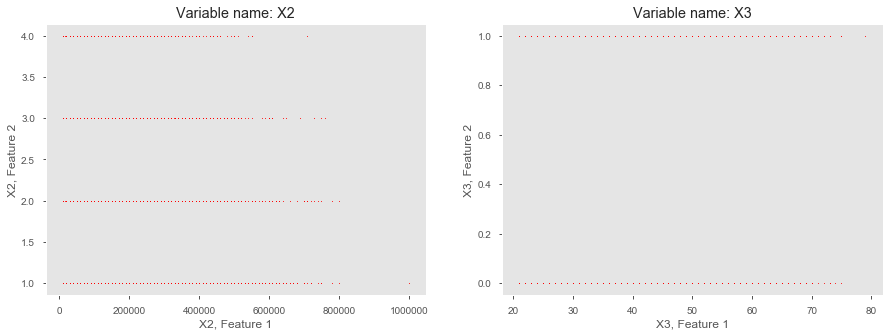

In [91]:
# plots of data 

X2 = df_copy1[['LIMIT_BAL','EDUCATION']].values
X3 = df_copy1[['AGE','IsMale','MARRIAGE']].values

# now plot each dataset
plt.figure(figsize=(15,5))
for i,X in enumerate([X2,X3]):
    plt.subplot(1,2,i+1)
    plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
    plt.title('Variable name: X{0}'.format(i+2))
    plt.xlabel('X{0}, Feature 1'.format(i+2))
    plt.ylabel('X{0}, Feature 2'.format(i+2))
    plt.grid()

plt.show()

This is another way of plotting X2 and X3.

For X2: we can see that among graduate school graduates (Education =1), the points are denser all the way to 800,000 while 'Others' group (Education = 4) tappers out starting around 500,000. Higher credit limit is distributed more among those with graduate school degree (EDUCATION = 1), next is among those with college degree (EDUCATION = 2). However, the range of credit limit of all the education class are very similar (below 600,000 NT dollars). Notice also a few outliers (but not invalid) among all the 4 levels of education.

For X3: this plot is only of Age vs IsMale. This plot does not give much detail, but we can see that for both males(=1) and females(=0), the age ranges from 20 - 70 years old are more populated and both sexes have about equal representation in our dataset. 

 <a href="#top">Back to top</a>

Let's investigate the value of MinPts and eps for the X2 and X3 datasets by graphing out the distances to the Nth nearest neighbors for each dataset (the variable names are X2_N and X3_N). Because our data are very dense, we want to start with a large number of N. We set X2_N = 100, X3_N = 50 to start with. Then, we will try changing the value to find a better graph. X4 will be investigated separately later. 

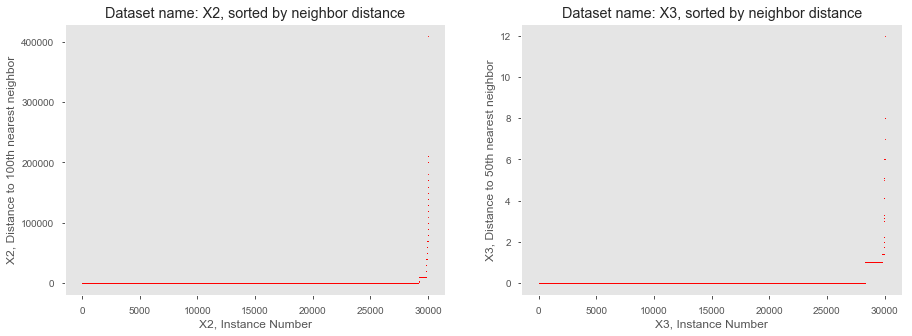

CPU times: user 11.7 s, sys: 202 ms, total: 11.9 s
Wall time: 12 s


In [92]:
%%time
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 100 
X3_N = 50 
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(X2, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(X3, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N2):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X3, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
plt.grid()

plt.show()

Looks like N needs to be very large to make the graph better. We will try with larger X2_N = 300 and X3_N = 300.

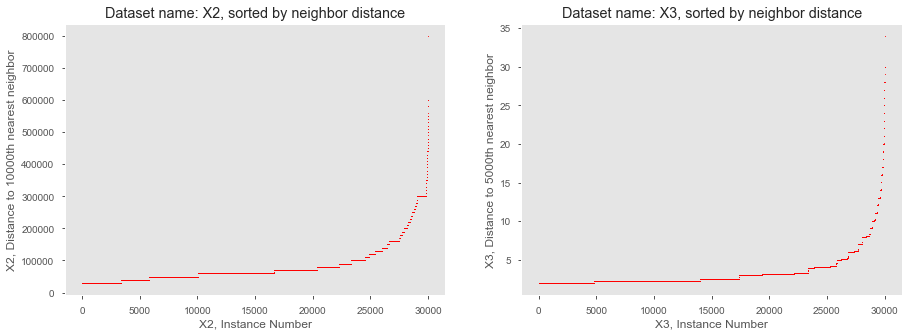

In [79]:
%%time
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 300 # 8
X3_N = 300 # 25
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(X2, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(X3, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N2):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X3, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
plt.grid()

plt.show()

Looking at the plots, we see that eps for X2 is around 100000, eps for X3 is around 2.5. 
Next, we will iterate X2 and X2 around selected eps and N. 

### DBSCAN for X2 ('LIMIT_BAL','EDUCATION') Attributes

A Large MinPts is a good guess because each cluster is very dense for X2. The We suspect it is a large number of points within each cluster. We will set the range for X2 as [100, 300, 500, 700] and eps = [50000, 70000, 100000] 

 <a href="#top">Back to top</a>

In [131]:
%%time 

from sklearn.cluster import DBSCAN

X2 = df_copy1[['LIMIT_BAL','EDUCATION']]

params = []
#for eps in [0.1, 0.125, 0.15]:
    #for mpts in range(40,50):
for eps in [50000, 70000, 100000]:
    for mpts in [100, 300, 500, 700]:
    
        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['IsMale','MARRIAGE', 'AGE', 
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

                         # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=1 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        dbs_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            dbs_rf_task1.fit(X[train], y[train])
            y_pred_proba = dbs_rf_task1.predict_proba(X[test])[:, 1]
            dbs_fpr_rf_task1, dbs_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = dbs_rf_task1.predict(X[test]) # y_pred is y_hat[test] 

        acc_std = cross_val_score(dbs_rf_task1,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        # metrics
        auc = roc_auc_score(y[test], y_pred_proba) 
        print (eps,mpts,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )

#         print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


50000 100 Average accuracy =  82.0069383941 +- 1.0205301133 AUC =  79.059613835
50000 300 Average accuracy =  82.0269350641 +- 1.00536134968 AUC =  79.1508476415
50000 500 Average accuracy =  82.0369472867 +- 1.05642124555 AUC =  79.1342538069
50000 700 Average accuracy =  81.9969706167 +- 1.09899707186 AUC =  79.1775139982
70000 100 Average accuracy =  82.0002850615 +- 1.06591020436 AUC =  79.0611634538
70000 300 Average accuracy =  81.9669395026 +- 1.02292243609 AUC =  79.0641335565
70000 500 Average accuracy =  81.9636017241 +- 1.00783684608 AUC =  79.0641335565
70000 700 Average accuracy =  81.9736106152 +- 1.0355650403 AUC =  79.0280403521
100000 100 Average accuracy =  82.0435872882 +- 0.958121213823 AUC =  78.9792273601
100000 300 Average accuracy =  82.0336061737 +- 1.00394781917 AUC =  79.1495562925
100000 500 Average accuracy =  82.006948393 +- 1.06405776899 AUC =  79.077563586
100000 700 Average accuracy =  82.0069417285 +- 1.04362674441 AUC =  79.0559334904
CPU times: user 

It seems that DBSCAN has good clusterings but does not help to increase accuracy or improving deviation and AUC. 
Again, the overall accuracy and AUC are similar to that of KMeans and Agglomerative Clustering methods. 
AUC and accuracy are stagnant various eps and mpts. AUC is very slight decreased as eps increased.
Based on our criteria of choosing the best AUC and accuracy, the best parameter is eps = 50000, mpts = 700, which gives the best average accuracy =  80.00 +- 1.09 and AUC =  79.17%.


### DBSCAN for X3 ('LIMIT_BAL','EDUCATION') Attributes

Again, a large MinPts is a good guess because each cluster is very dense for X3 as well. The We suspect it is a large number of points within each cluster. We will set the mpts for X3 as [100, 300, 500, 700] and eps as [2, 2.5, 3] 


<a href="#top">Back to top</a>

In [132]:
%%time 

from sklearn.cluster import DBSCAN

X3 = df_copy1[['IsMale','MARRIAGE', 'AGE']]

params = []
for eps in [2, 2.5, 3]:
    for mpts in [100, 300, 500, 700]:

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X3)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['LIMIT_BAL','EDUCATION',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

                         # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        dbs_rf_task2 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            dbs_rf_task2.fit(X[train], y[train])
            y_pred_proba = dbs_rf_task2.predict_proba(X[test])[:, 1]
            dbs_fpr_rf_task2, dbs_tpr_rf_task2, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = dbs_rf_task2.predict(X[test]) # y_pred is y_hat[test] 

        acc_std = cross_val_score(dbs_rf_task2,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        # metrics
        auc = roc_auc_score(y[test], y_pred_proba) 
        print (eps,mpts,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )

#         print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


2 100 Average accuracy =  81.9436117215 +- 1.05879358322 AUC =  79.9117750367
2 300 Average accuracy =  81.9869339482 +- 0.98843315461 AUC =  80.0514989979
2 500 Average accuracy =  82.0102650578 +- 1.00837783364 AUC =  80.0343240563
2 700 Average accuracy =  82.0802806237 +- 1.042306304 AUC =  80.0745172937
2.5 100 Average accuracy =  82.0836183993 +- 1.07227980758 AUC =  79.8569249881
2.5 300 Average accuracy =  82.0302761741 +- 1.01022667033 AUC =  80.0703526932
2.5 500 Average accuracy =  81.966955056 +- 1.08279239781 AUC =  79.8870779871
2.5 700 Average accuracy =  81.9936039493 +- 1.00772144577 AUC =  80.1644274675
3 100 Average accuracy =  82.0002861723 +- 1.09235399863 AUC =  79.9147774231
3 300 Average accuracy =  82.0302883945 +- 1.07429768229 AUC =  80.0063340668
3 500 Average accuracy =  82.0102795026 +- 1.04332204696 AUC =  80.0722251493
3 700 Average accuracy =  81.966955056 +- 1.08279239781 AUC =  79.8870779871
CPU times: user 40min 51s, sys: 47.5 s, total: 41min 39s
Wal

It seems that DBSCAN has good clusterings but does not help to increase accuracy or improving deviation and AUC. 
Again, the overall accuracy and AUC are similar to that of KMeans and Agglomerative Clustering methods.
AUC and accuracy are stagnant at various Eps and MinPts. Based on our criteria of choosing the best AUC and accuracy, the best parameter is eps = 2.5, mpts = 700, which gives the best average accuracy =  80.00 +- 1.01 and AUC =  80.16%.

### DBSCAN for X4 ('TOTAL_MONTH_LATE', all monthly payment status)

Again, a large MinPts is a good guess because each cluster is very dense for X4. We suspect it is a large number of points within each cluster. 

<a href="#top">Back to top</a>

#### Finding eps and minPts for X4

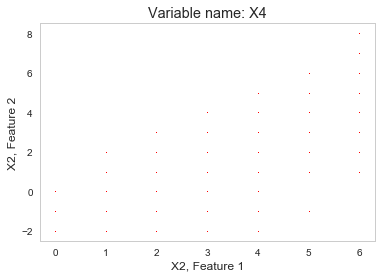

In [377]:
# plots of data 

X4 = df_copy1[['Total_Month_Late','Sept_Payment_Status', 'Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']].values

X = X4 
plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
plt.title('Variable name: X{0}'.format(i+2))
plt.xlabel('X{0}, Feature 1'.format(2))
plt.ylabel('X{0}, Feature 2'.format(2))
plt.grid()

plt.show()

This plot presents the 'Total_Month_Late' vs. 'Sept_Payment_Status'. This plot shows the distribution and continuity of the data. We can see that most of clients have good record paying record with total of months with late payment record (=0). Those with >0 total month with late payment (as of Sept) also have high density of being late on Sept and the recent months. 
It's also interesting to see that the correlation of 'Total_Month_Late' vs. 'Sept_Payment_Status' here. The more total late monthly payments one has, the higher the incurring 'Sept_Payment_Status'. This makes sense as the delinquency bubble moving through the correlations between Apr to Sept payment status. The more late monthly payments one has, increases the chances of defaulting on the loan the next month. The correlation decreases as customers caught up and cured out of delinquency. 

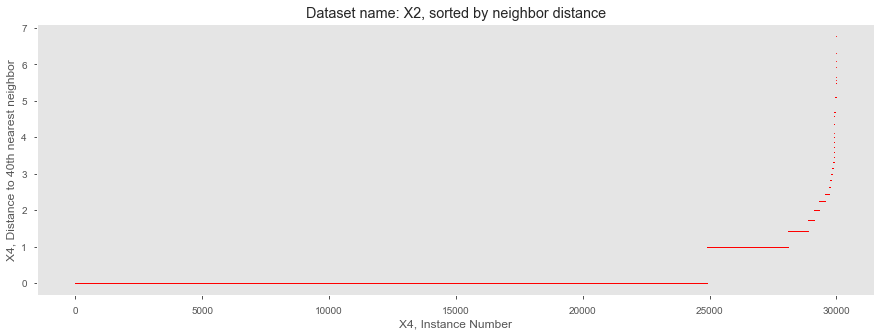

CPU times: user 8.4 s, sys: 76.2 ms, total: 8.47 s
Wall time: 8.51 s


In [97]:
%%time
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X4_N = 40 # 8
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X4_knn_graph = kneighbors_graph(X4, X4_N, mode='distance') # calculate distance to four nearest neighbors 
#X3_knn_graph = kneighbors_graph(X3, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N4 = X4_knn_graph.shape[0]
X4_4nn_distances = np.zeros((N4,1))
for i in range(N4):
    X4_4nn_distances[i] = X4_knn_graph[i,:].max()

X4_4nn_distances = np.sort(X4_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
plt.plot(range(N4), X4_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X4, Instance Number')
plt.ylabel('X4, Distance to {0}th nearest neighbor'.format(X4_N))
plt.grid()

plt.show()

We will try with larger N_4 = 300

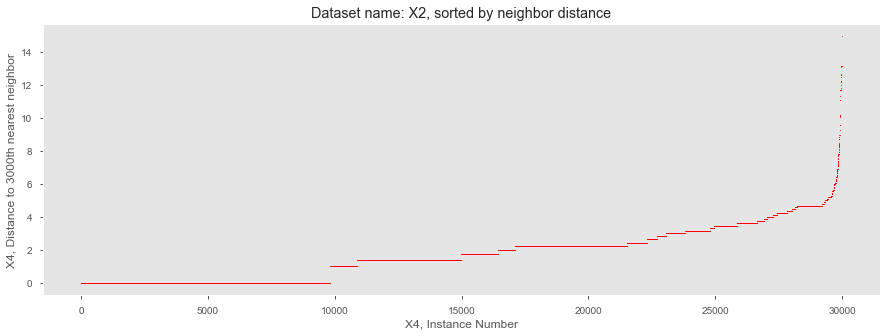

CPU times: user 1min 25s, sys: 3.55 s, total: 1min 28s
Wall time: 1min 30s


In [100]:
%%time
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X4_N = 300 # 8
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X4_knn_graph = kneighbors_graph(X4, X4_N, mode='distance') # calculate distance to four nearest neighbors 

N4 = X4_knn_graph.shape[0]
X4_4nn_distances = np.zeros((N4,1))
for i in range(N4):
    X4_4nn_distances[i] = X4_knn_graph[i,:].max()

X4_4nn_distances = np.sort(X4_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
plt.plot(range(N4), X4_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X4, Instance Number')
plt.ylabel('X4, Distance to {0}th nearest neighbor'.format(X4_N))
plt.grid()

plt.show()

This graph of N_4 = 300 is better. Looking at the plot, we see that eps is around 2.5

#### DBSCAN for X4 with mpts for X4 as [100, 300, 500, 700] and eps as [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]

In [134]:
%%time 

from sklearn.cluster import DBSCAN

X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

params = []
for eps in [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]:
    for mpts in [100, 300, 500, 700]:

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X4)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_copy1['default']
        X = df_copy1[['LIMIT_BAL','EDUCATION', 'IsMale','MARRIAGE', 'AGE',              
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

                         # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


        # get a handle to the classifier object, which defines the type
        dbs_rf_task3 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            dbs_rf_task3.fit(X[train], y[train])
            y_pred_proba = dbs_rf_task3.predict_proba(X[test])[:, 1]
            dbs_fpr_rf_task3, dbs_tpr_rf_task3, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = dbs_rf_task3.predict(X[test]) # y_pred is y_hat[test] 

        acc_std = cross_val_score(dbs_rf_task3,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        # metrics
        auc = roc_auc_score(y[test], y_pred_proba) 
        print (eps,mpts,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )

#         print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


2 100 Average accuracy =  79.8400871008 +- 0.486932196505 AUC =  76.5304099775
2 300 Average accuracy =  79.8467537719 +- 0.486373394836 AUC =  76.409604279
2 500 Average accuracy =  79.9334782245 +- 0.629297292372 AUC =  77.2205068803
2 700 Average accuracy =  79.9467860041 +- 0.519350395924 AUC =  77.135471549
2.5 100 Average accuracy =  78.9634192433 +- 0.576694525791 AUC =  75.0562705324
2.5 300 Average accuracy =  78.8500692311 +- 0.520147264309 AUC =  75.1460515713
2.5 500 Average accuracy =  78.8734170174 +- 0.542107201865 AUC =  75.2325073865
2.5 700 Average accuracy =  79.0100725819 +- 0.536001180843 AUC =  75.4494217339
3 100 Average accuracy =  78.9134070178 +- 0.53138406414 AUC =  74.8995007645
3 300 Average accuracy =  78.9300792389 +- 0.532502361106 AUC =  74.8697674539
3 500 Average accuracy =  78.8734314578 +- 0.533101336606 AUC =  74.7529649373
3 700 Average accuracy =  78.906751457 +- 0.474525471372 AUC =  74.9232938697
3.5 100 Average accuracy =  78.9700648022 +- 0.5

It seems that DBSCAN has good clusterings for this discretization X4 but does not help to increase accuracy or improving deviation and AUC. 
Again, the overall accuracy and AUC is similar to that of KMeans and Agglomerative Clustering methods for X4.
AUC and accuracy are stagnant at various eps and mpts. Based on our criteria of choosing the best AUC and accuracy, the best parameter is eps = 2, mpts = 500, which gives the best average accuracy =  79.93 +- 0.63 and AUC =  77.22%. 

DBSCAN has good clusterings for this dataset but it was not able to capture some of the nuances for the attributes. This is a spatial data, so it is expected that contiguous clustering helps discretize the data a bit. 
Even so, the center based clustering also tend to do well with best accuracy is around 80% and AUC is around 80%. X2 and X3 have better clusterings than X4. 


<div id='MODEL2'/>
# 5. Modeling and Evaluation 2: Evaluate and Compare

     * Process for each clustering method** 
        * Choose a subset of features from the dataset to cluster upon.  
        * Cluster the features assuming according to a given algorithm
        * Replace the features with their discrete cluster labels as a form of discretization
        * Perform classification using the new feature from the dataset

 <a href="#top">Back to top</a>

### Evaluate and Compare: [2, 47, 48, 50] 

**For RF classification:**


We use GridSearchCV to find the best parameters for RF (the detail explanation was done in lab 2). A Baseline RF classification performance is also done with the best RF parameter suggested by GridSearchCV. While accuracy will be one of the primary focuses, metrics related to the cost of estimating incorrectly will also be considered. These include recall, precision and F-Measure. Ignoring these metrics will result in an increased risk for the bank/credit institutions regardless of the accuracy. AUC is the overall metric that we will use to compare the performance. If all else are equal, recall is used next to evaluate the model. Higher recall means lower false negatives, which is preferred for the purpose of our investigation

**Find the best n_clusters for Kmeans**

Our initialization strategy is varying k-means++. k-means++ selects a point with probability proportional to the square of its distance to the nearest preceding centroid. This means, if we pick the farthest point, we often get points that are at the edges of their true clusters, but if we choose randomly as described, then you're more likely to get one near the center of the true cluster. Since we don't really know beforehand how many clusters our data contains, we choose the first k-means++ randomly as 8.

Then, through the use of the silhouette analysis and silhouette score, the best cluster number will be observed and applied for the next iteration to find the number of clusters that gives the best classification performance results.
The silhouette score is validation method of consistency within clusters of data. The score ranges from -1 to 1. Per scikit-learm documentation, the best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. [47], [48] 

The reason we cannot use the best observed silhouette and cluster number and apply it directly to the classification because our data set is large and that a sample of more than 10000 for any subset took a very long time and the result was all -1. It was impractical for this data set to use. Since we could not use the entire set of data, we can only use this analysis as a guide to find the range of n_clusters for the KMeans n_cluster 'for' loop iteration. 

We then attempt to find the best k for each clustering by running the algorithms around the best cluster numbers that is suggested by the silhouette score using 'for' loop. We then observe the results and the trend, if the result is upward with increased k, we will then try to run a higher range and so on, until we find the right range. Once we find that optimal range, we will run the algorithm around that range to find the best n_cluster. 

Among the cluster groups, we once we find the best n_cluster of each groups, we run the Kmeans and RF classification algorithms on each of these groups with its best n_cluster. This will be decided as the best cluster group of our data for Kmeans. 


**Find the best n_clusters and link for HAC**

Again, we use loop iteration with various n_cluster and all links ward, complete, and average. 
We use the knowledge of finding best n_cluster in Kmeans above to determine the range of n_cluster of each clustering group. 
We then attempt to find the best combination (n_cluster, link) for each clustering by running the HAC and RF classification algorithms with looping around the n_cluster range and links of ward, complete, and average


**Find the best eps and minPts For DBSCAN:**

There is no general way of choosing minPts. For epsilon, there are various aspects. It again boils down to choosing whatever works on this data set and this minPts and this distance function and this normalization. 

Since a low minPts means it will build more clusters from noise, so we choose a larger minPts to start with (40 and 50). We first fix minPts according to domain knowledge, then plot a k-distance graph (with k=minPts) and look for an elbow in this graph. If the plot is not as good, we adjust by increasing larger minPts. For our datasets, minPts of 300 to 1000 are sufficient. The KNN is a non-parametric method. Once we choose a minPTS, then we use it to determine epsilon, the k-distance corresponding to the area of the k-distance plot with a low slope. We then use the above k=minPts to find a positive number epsilon (eps). 
Since these minPts and eps are not exact values, we will perform iternation with range of eps and minPts to find the more accurate combination values. We do that by running for loops with all the combination of k=minPts and epsilon for different clusterings and observe AUC and accuracy to determine the best combination of minPts and eps of each clustering. 
We then run DBSCAN and RF algorithms and compare the results of each clustering with its best (minPts, eps) to find the best cluster.  


**Final Evaluation of Clustering and Classification:**

We first identify the best parameter for the Random Forest classification. For our data, the best n_estimator is 150 and max_height is 10. 
For each clustering method, we run a loop with various clustering parameters and various clusters, then feed the data into the RF model to get the evaluation metrics results. 
We then compare the result of each clustering to find the best cluster of each models. We compare the classification metrics and ROC between the clusterings of each of the methods (Kmeans, HAC, and DBSCAN) to find best cluster/model of each method. We then compare the best model each of the Kmeans, HAC, and DBSCAN models and the Baseline RF model to determine the best method and cluster. 


 <a href="#top">Back to top</a>

<div id='MODEL3'/>
# 6. Modeling and Evaluation 3: Visualize Results

 <a href="#top">Back to top</a>

In [339]:
%%time 
# Set up lists to store metrics results
# km - task 1
km_accuracy_task1_anova = [] 
km_conf_task1_anova = [] 
km_recall_task1_anova = [] 
km_precision_task1_anova = [] 
km_fmeasure_task1_anova = [] 
km_auc_task1_anova = []    

# km - Task 2
km_accuracy_task2_anova = [] 
km_conf_task2_anova = [] 
km_recall_task2_anova = [] 
km_precision_task2_anova = [] 
km_fmeasure_task2_anova = [] 
km_auc_task2_anova = []    

# km - Task 3
km_accuracy_task3_anova = [] 
km_conf_task3_anova = [] 
km_recall_task3_anova = [] 
km_precision_task3_anova = [] 
km_fmeasure_task3_anova = [] 
km_auc_task3_anova = []    

# km - Task 12 
km_accuracy_task12_anova = [] 
km_conf_task12_anova = [] 
km_recall_task12_anova = [] 
km_precision_task12_anova = [] 
km_fmeasure_task12_anova = [] 
km_auc_task12_anova = [] 

# km - Task 13 
km_accuracy_task13_anova = [] 
km_conf_task13_anova = [] 
km_recall_task13_anova = [] 
km_precision_task13_anova = [] 
km_fmeasure_task13_anova = [] 
km_auc_task13_anova = [] 

# km - Task 23 
km_accuracy_task23_anova = [] 
km_conf_task23_anova = [] 
km_recall_task23_anova = [] 
km_precision_task23_anova = [] 
km_fmeasure_task23_anova = [] 
km_auc_task23_anova = [] 

# hac - task 1
hac_accuracy_task1_anova = [] 
hac_conf_task1_anova = [] 
hac_recall_task1_anova = [] 
hac_precision_task1_anova = [] 
hac_fmeasure_task1_anova = [] 
hac_auc_task1_anova = []    

# hac - Task 2
hac_accuracy_task2_anova = [] 
hac_conf_task2_anova = [] 
hac_recall_task2_anova = [] 
hac_precision_task2_anova = [] 
hac_fmeasure_task2_anova = [] 
hac_auc_task2_anova = []    

# hac - Task 3
hac_accuracy_task3_anova = [] 
hac_conf_task3_anova = [] 
hac_recall_task3_anova = [] 
hac_precision_task3_anova = [] 
hac_fmeasure_task3_anova = [] 
hac_auc_task3_anova = []    

# dbscan - task 1
dbs_accuracy_task1_anova = [] 
dbs_conf_task1_anova = [] 
dbs_recall_task1_anova = [] 
dbs_precision_task1_anova = [] 
dbs_fmeasure_task1_anova = [] 
dbs_auc_task1_anova = []    

# dbscan  - Task 2
dbs_accuracy_task2_anova = [] 
dbs_conf_task2_anova = [] 
dbs_recall_task2_anova = [] 
dbs_precision_task2_anova = [] 
dbs_fmeasure_task2_anova = [] 
dbs_auc_task2_anova = []    

# dbscan  - Task 3
dbs_accuracy_task3_anova = [] 
dbs_conf_task3_anova = [] 
dbs_recall_task3_anova = [] 
dbs_precision_task3_anova = [] 
dbs_fmeasure_task3_anova = [] 
dbs_auc_task3_anova = []    



CPU times: user 137 µs, sys: 15 µs, total: 152 µs
Wall time: 146 µs


### Kmeans Results 

#### Performace of X2 clustering with best parameter n_cluster = 6

 <a href="#top">Back to top</a>

In [340]:
%%time
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X2 = df_copy1[['EDUCATION','LIMIT_BAL']].values

cls = KMeans(n_clusters=6, #  initialization with n_clusters = 8
             init='k-means++', # number of clusters
             random_state=1) 
cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['IsMale', 'MARRIAGE', 'AGE', 
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!

X = np.column_stack((X,pd.get_dummies(newfeature)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
print (cv)
print (cv.get_n_splits(X,y)) # should be 10 here

# get a handle to the classifier object, which defines the type
km_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    km_rf_task1.fit(X[train], y[train])
    y_pred_proba = km_rf_task1.predict_proba(X[test])[:, 1]
    km_fpr_rf_task1, km_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task1.predict(X[test]) # y_pred is y_hat[test] 

   # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    km_accuracy_task1_anova.append(acc)
    km_conf_task1_anova.append([conf])
    km_recall_task1_anova.append(recall)
    km_precision_task1_anova.append(precision)
    km_fmeasure_task1_anova.append(f)
    km_auc_task1_anova.append(auc_score)  

print ("acc", np.mean(km_accuracy_task1_anova), "+-", np.std(km_accuracy_task1_anova))
print ("auc", np.mean(km_auc_task1_anova)) 

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
10
acc 0.820336150619 +- 0.0101357753916
auc 0.778998634405
CPU times: user 1min 56s, sys: 1.97 s, total: 1min 58s
Wall time: 43.4 s


#### Performace of X3 clustering ['IsMale', 'MARRIAGE','AGE'] with best parameter n_cluster = 8

 <a href="#top">Back to top</a>

In [341]:
%%time

# kmeans with clusters 8 
X3 = df_copy1[['AGE', 'IsMale', 'MARRIAGE']].values

cls = KMeans(n_clusters=8, init='k-means++',random_state=1) #  initialization
cls.fit(X3)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['EDUCATION','LIMIT_BAL',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
X = np.column_stack((X,pd.get_dummies(newfeature)))

# acc = cross_val_score(clf,X,y=y,cv=cv)
# print ("Average accuracy (with kmeans for credit family)= ", acc.mean()*100, "+-", acc.std()*100)

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.

# get a handle to the classifier object, which defines the type
km_rf_task2 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat and get roc curve data
for train, test in cv.split(X,y):
    km_rf_task2.fit(X[train], y[train])
    y_pred_proba = km_rf_task2.predict_proba(X[test])[:, 1]
    km_fpr_rf_task2, km_tpr_rf_task2, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task2.predict(X[test]) # y_pred is y_hat[test] 

    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    km_accuracy_task2_anova.append(acc)
    km_conf_task2_anova.append([conf])
    km_recall_task2_anova.append(recall)
    km_precision_task2_anova.append(precision)
    km_fmeasure_task2_anova.append(f)
    km_auc_task2_anova.append(auc_score)  
    
print ("acc", np.mean(km_accuracy_task2_anova), "+-", np.std(km_accuracy_task2_anova))
print ("auc", np.mean(km_auc_task2_anova))

acc 0.820036106174 +- 0.010075490204
auc 0.780684500531
CPU times: user 1min 43s, sys: 1.64 s, total: 1min 45s
Wall time: 37.2 s


#### Performace of X4 clustering (‘Total_Month_Late’, all montly payment status) with best parameter n_cluster = 4

 <a href="#top">Back to top</a>

In [342]:
%%time

# kmeans with n_cluster = 18
X4 = df_copy1[['Total_Month_Late','Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status']].values

cls = KMeans(n_clusters=4, init='k-means++',random_state=1) #  initialization
cls.fit(X4)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['EDUCATION','LIMIT_BAL', 'IsMale', 'MARRIAGE','AGE', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
X = np.column_stack((X,pd.get_dummies(newfeature)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.

# get a handle to the classifier object, which defines the type
km_rf_task3 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat and get roc curve data
for train, test in cv.split(X,y):
    km_rf_task3.fit(X[train], y[train])
    y_pred_proba = km_rf_task3.predict_proba(X[test])[:, 1]
    km_fpr_rf_task3, km_tpr_rf_task3, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task3.predict(X[test]) # y_pred is y_hat[test] 
    
    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    km_accuracy_task3_anova.append(acc)
    km_conf_task3_anova.append([conf])
    km_recall_task3_anova.append(recall)
    km_precision_task3_anova.append(precision)
    km_fmeasure_task3_anova.append(f)
    km_auc_task3_anova.append(auc_score)  

print ("acc", np.mean(km_accuracy_task3_anova), "+-", np.std(km_accuracy_task3_anova))
print ("auc", np.mean(km_auc_task3_anova)) 

acc 0.8004689713 +- 0.00932787020653
auc 0.74930220688
CPU times: user 1min 41s, sys: 1.59 s, total: 1min 42s
Wall time: 36.3 s


#### Performace of  X2 and X3 clustering with best parameter n_clusters = 6 for X2 and 18 for X3

 <a href="#top">Back to top</a>

In [343]:
# get the first clustering ['EDUCATION','LIMIT_BAL']
cls_fare = KMeans(n_clusters=6, init='k-means++',random_state=1)
cls_fare.fit(X2)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering ['IsMale','MARRIAGE', 'AGE']
cls_fam = KMeans(n_clusters=18, init='k-means++',random_state=1)
cls_fam.fit(X3)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))


 # train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     

In [344]:
# get a handle to the classifier object, which defines the type
km_rf_task12 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    km_rf_task12.fit(X[train], y[train])
    y_pred_proba = km_rf_task12.predict_proba(X[test])[:, 1]
    km_fpr_rf_task12, km_tpr_rf_task12, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task12.predict(X[test]) # y_pred is y_hat[test]

    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    km_accuracy_task12_anova.append(acc)
    km_conf_task12_anova.append([conf])
    km_recall_task12_anova.append(recall)
    km_precision_task12_anova.append(precision)
    km_fmeasure_task12_anova.append(f)
    km_auc_task12_anova.append(auc_score)  
    

#### Performace of X2 and X4 clustering with best parameter n_clusters = 6 for X2 and 4 for X4

 <a href="#top">Back to top</a>

In [345]:
%%time 

X2 = df_copy1[['EDUCATION','LIMIT_BAL']]
X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

# get the first clustering ['EDUCATION','LIMIT_BAL']
cls_fare = KMeans(n_clusters=6, init='k-means++',random_state=1)
cls_fare.fit(X2)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering ['IsMale','MARRIAGE', 'AGE']
cls_fam = KMeans(n_clusters=4, init='k-means++',random_state=1)
cls_fam.fit(X4)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering


y = df_copy1['default']
X = df_copy1[['IsMale','MARRIAGE', 'AGE',
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!

X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))


 # train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
    
# get a handle to the classifier object, which defines the type
km_rf_task13 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    km_rf_task13.fit(X[train], y[train])
    y_pred_proba = km_rf_task13.predict_proba(X[test])[:, 1]
    km_fpr_rf_task13, km_tpr_rf_task13, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task13.predict(X[test]) # y_pred is y_hat[test]
    
    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    km_accuracy_task13_anova.append(acc)
    km_conf_task13_anova.append([conf])
    km_recall_task13_anova.append(recall)
    km_precision_task13_anova.append(precision)
    km_fmeasure_task13_anova.append(f)
    km_auc_task13_anova.append(auc_score)  

CPU times: user 2min 10s, sys: 2.45 s, total: 2min 12s
Wall time: 51.4 s


#### Performace of X3 and X4 clustering with best parameter n_clusters = 4 for X3 and 3 for X4

 <a href="#top">Back to top</a>

In [346]:
%%time 

X3 = df_copy1[['IsMale','MARRIAGE', 'AGE']]
X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

# get the first clustering ['EDUCATION','LIMIT_BAL']
cls_fare = KMeans(n_clusters=4, init='k-means++',random_state=1)
cls_fare.fit(X3)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering ['IsMale','MARRIAGE', 'AGE']
cls_fam = KMeans(n_clusters=3, init='k-means++',random_state=1)
cls_fam.fit(X4)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering


y = df_copy1['default']
X = df_copy1[['EDUCATION', 'LIMIT_BAL', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
 
X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))


 # train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
    
# get a handle to the classifier object, which defines the type
km_rf_task23 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    km_rf_task23.fit(X[train], y[train])
    y_pred_proba = km_rf_task23.predict_proba(X[test])[:, 1]
    km_fpr_rf_task23, km_tpr_rf_task23, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = km_rf_task23.predict(X[test]) # y_pred is y_hat[test]
    
    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    km_accuracy_task23_anova.append(acc)
    km_conf_task23_anova.append([conf])
    km_recall_task23_anova.append(recall)
    km_precision_task23_anova.append(precision)
    km_fmeasure_task23_anova.append(f)
    km_auc_task23_anova.append(auc_score)  


CPU times: user 1min 54s, sys: 2.22 s, total: 1min 56s
Wall time: 44.5 s


### Plot the result metrics of all Kmeans models

 <a href="#top">Back to top</a>


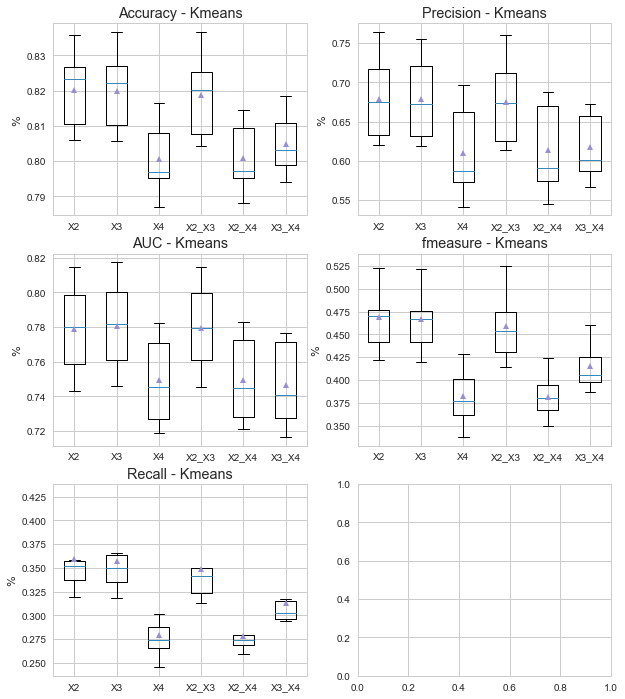

In [481]:
# result metrics of Kmeans 
acc_km = [km_accuracy_task1_anova, km_accuracy_task2_anova,km_accuracy_task3_anova, 
          km_accuracy_task12_anova,km_accuracy_task13_anova, km_accuracy_task23_anova]
auc_km = [km_auc_task1_anova, km_auc_task2_anova,km_auc_task3_anova, 
          km_auc_task12_anova,km_auc_task13_anova, km_auc_task23_anova]
recall_km = [km_recall_task1_anova, km_recall_task2_anova, km_recall_task3_anova, 
             km_recall_task12_anova, km_recall_task13_anova, km_recall_task23_anova]
precision_km = [km_precision_task1_anova, km_precision_task2_anova,km_precision_task3_anova,
               km_precision_task12_anova,km_precision_task13_anova, km_precision_task23_anova] 
f_km = [km_fmeasure_task1_anova, km_fmeasure_task2_anova, km_fmeasure_task3_anova, 
        km_fmeasure_task12_anova, km_fmeasure_task13_anova, km_fmeasure_task23_anova]

#plt.figure(figsize=(30,20))
fig, axes = plt.subplots(3, 2, sharey=False, sharex=False, figsize = (10,12))

axes[0,0].boxplot(acc_km, showmeans=True)
axes[0,0].set_title ('Accuracy - Kmeans')
axes[0,0].set_ylabel('%')
axes[0,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[1,0].boxplot(auc_km, showmeans=True)
axes[1,0].set_title('AUC - Kmeans')
axes[1,0].set_ylabel('%')
axes[1,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])


axes[2,0].boxplot(recall_km, showmeans=True)
axes[2,0].set_title('Recall - Kmeans')
axes[2,0].set_ylabel('%')
axes[2,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[0,1].boxplot(precision_km, showmeans=True)
axes[0,1].set_title('Precision - Kmeans')
axes[0,1].set_ylabel('%')
axes[0,1].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[1,1].boxplot(f_km, showmeans=True)
axes[1,1].set_title('fmeasure - Kmeans')
axes[1,1].set_ylabel('%')
axes[1,1].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

plt.show()
 

These plots show that X2 = ['EDUCATION','LIMIT_BAL'] and X3 = [Age, Marriage, and Sex] groups are the best performers all around, with the highest AUC, highest accuracy and highest recall. All the metrics values higher than those of the others cluster groups. 
We will look at the Kmeans [Age, Marriage, and Sex] and ['EDUCATION','LIMIT_BAL'] clusters for any insights. 

 <a href="#top">Back to top</a>

#### Visualizing Kmeans [Age, Marriage, and Sex] and ['EDUCATION','LIMIT_BAL'] clusters

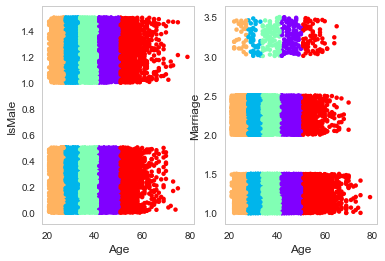

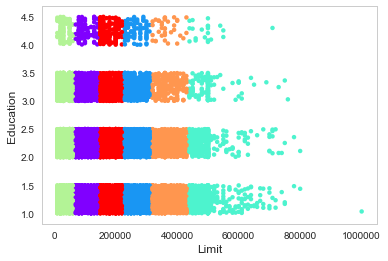

In [288]:
# normalizing 
# df_sub = df_imputed[['Survived','Age','Pclass','Sex']]
# df_sub.Sex = df_sub.Sex=='male' 

# df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
# df_normalized.Survived = df_sub.Survived

n_fare=6 # 
d_fam=8 # 

X2 = df_copy1[['EDUCATION','LIMIT_BAL']]
X3 = df_copy1[[ 'AGE','IsMale','MARRIAGE']]

cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare.fit(X2)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
cls_fam.fit(X3)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
X3=X3.values
plt.scatter(X3[:, 0], X3[:, 1]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('IsMale')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X3[:, 0], X3[:, 2]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('Marriage')
plt.grid()

X2=X2.values
plt.figure()
plt.scatter(X2[:, 1], X2[:, 0]+np.random.random(X2[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Limit'), plt.ylabel('Education')
plt.grid()


For X2: we can see that there are 6 clusters that discretized similar to the way we cut with q-cut. Education vs Limit Balance = Again clustering accross the 4 levels of education into 6 distinct clusters. 
For up to 300000 NT limit, it's denser for those with graduate school degree (EDUCATION = 1), those with college degree (EDUCATION = 2) and those with highschool degree (EDUCATION = 3), but much less dense for those in the 'Others' group (Education = 4). For higher limit, it's less dense for those with highschool degree (EDUCATION = 3) and those with 'Others' (Education = 4). 

For X3: Again, we can see that there are 5 clusters clearly (visually) that discretized similar to the way we cut with q-cut. 
    For Age vs IsMale, Both males and females have been clustered into 5 distinct clusters. There is clustering accross the levels (males and females are classified together). The age ranges from 20 - 70 years old are more populated and both sexes have about equal representation and clusters. There are very mimimal data > 70. 
    For Age vs Marriage, clustering accross the 3 levels of marriage into 5 distinct clusters. The densest clusters are from age 20-50. The "Married" (=1) and 'Single' (=2) groups have higher density than 'Others'(=3) in all the clusters. 
    
 <a href="#top">Back to top</a>

Next, we will use ROC to determine which cluster is the best performer with Kmeans methods.



### ROC for all Kmeans clusterings**

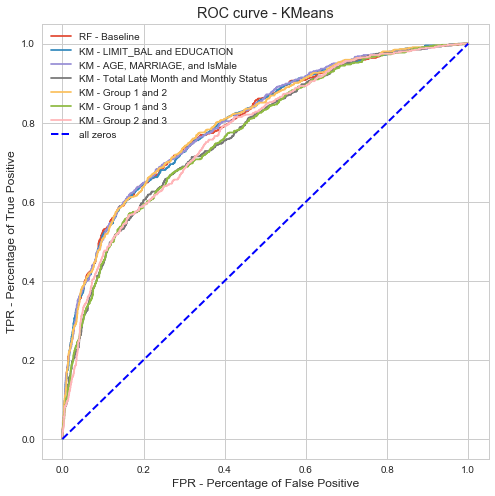

In [480]:
## adding ROC 
# ROC for RF Baseline, LIMIT_BAL and EDUCATION kmeans clusters. 
plt.figure(figsize=(8,8))
plt.plot(fpr_rf_task1, tpr_rf_task1, label='RF - Baseline')
plt.plot(km_fpr_rf_task1, km_tpr_rf_task1, label='KM - LIMIT_BAL and EDUCATION')
plt.plot(km_fpr_rf_task2, km_tpr_rf_task2, label='KM - AGE, MARRIAGE, and IsMale')
plt.plot(km_fpr_rf_task3, km_tpr_rf_task3, label='KM - Total Late Month and Monthly Status')
plt.plot(km_fpr_rf_task12, km_tpr_rf_task12, label='KM - Group 1 and 2')
plt.plot(km_fpr_rf_task13, km_tpr_rf_task13, label='KM - Group 1 and 3')
plt.plot(km_fpr_rf_task23, km_tpr_rf_task23, label='KM - Group 2 and 3')

## Draw the diagonal line 
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='all zeros') # diagonal line

##Title, label, and legend 
plt.xlabel('FPR - Percentage of False Positive')
plt.ylabel('TPR - Percentage of True Positive')
plt.title('ROC curve - KMeans')
plt.legend(loc="upper left")
plt.show()

# This discretization does not help to increase the accuracy or AUC on average. It neither help to lower the deviation from the mean. 
# Next, we will try to combine different clusterings.

We can see that clusters [Age, Marriage, and Sex] and the stack of [Age, Marriage, and Sex] and ['EDUCATION','LIMIT_BAL'] perform the best here. However, they do not perform significantly better than full model Random Forest.

 <a href="#top">Back to top</a>

### HAC Evaluation and Results

** HAC performance of X2 with the best parameters: C= 6 and average link**

In [348]:
%%time 

from sklearn.cluster import AgglomerativeClustering

X2 = df_copy[['LIMIT_BAL','EDUCATION']]

# params = []
# for link in ['ward', 'complete', 'average']:
#     for n_fam in range(4,10):

# append on the clustering
cls_fam = AgglomerativeClustering(n_clusters=6, linkage='average')
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['IsMale','MARRIAGE', 'AGE', 
'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
'Jun_Bill', 'May_Bill', 'Apr_Bill', 
'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


# get a handle to the classifier object, which defines the type
hac_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    hac_rf_task1.fit(X[train], y[train])
    y_pred_proba = hac_rf_task1.predict_proba(X[test])[:, 1]
    hac_fpr_rf_task1, hac_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = hac_rf_task1.predict(X[test]) # y_pred is y_hat[test] 
            
            
    #acc_std = cross_val_score(hac_rf_task1,X,y=y,cv=cv)
    #params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    hac_accuracy_task1_anova.append(acc)
    hac_conf_task1_anova.append([conf])
    hac_recall_task1_anova.append(recall)
    hac_precision_task1_anova.append(precision)
    hac_fmeasure_task1_anova.append(f)
    hac_auc_task1_anova.append(auc_score)  

print ("acc", np.mean(hac_accuracy_task1_anova), "+-", np.std(hac_accuracy_task1_anova))
print ("auc", np.mean(hac_auc_task1_anova)) 

acc 0.821236072948 +- 0.0100175135722
auc 0.78008908663
CPU times: user 3min 1s, sys: 35.5 s, total: 3min 36s
Wall time: 2min 43s


**HAC performance X3 with the best parameters: C= 7 and average link**

 <a href="#top">Back to top</a>

In [349]:
%%time 

from sklearn.cluster import AgglomerativeClustering
X3 = df_copy[['IsMale','MARRIAGE', 'AGE']]

# params = []
# for link in ['ward', 'complete', 'average']:
#     for n_fam in range(4,10):

# append on the clustering
cls_fam = AgglomerativeClustering(n_clusters=7, linkage='average')
cls_fam.fit(X3)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['LIMIT_BAL','EDUCATION',
'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
'Jun_Bill', 'May_Bill', 'Apr_Bill', 
'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=1 so that we will always get the same output the first time we make the split. We want reproducible results.


# get a handle to the classifier object, which defines the type
hac_rf_task2 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    hac_rf_task2.fit(X[train], y[train])
    y_pred_proba = hac_rf_task2.predict_proba(X[test])[:, 1]
    hac_fpr_rf_task2, hac_tpr_rf_task2, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = hac_rf_task2.predict(X[test]) # y_pred is y_hat[test] 
            
    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    hac_accuracy_task2_anova.append(acc)
    hac_conf_task2_anova.append([conf])
    hac_recall_task2_anova.append(recall)
    hac_precision_task2_anova.append(precision)
    hac_fmeasure_task2_anova.append(f)
    hac_auc_task2_anova.append(auc_score)  

print ("acc", np.mean(hac_accuracy_task2_anova), "+-", np.std(hac_accuracy_task2_anova))
print ("auc", np.mean(hac_auc_task2_anova)) 
    

acc 0.819736217256 +- 0.0107038603815
auc 0.780933765847
CPU times: user 2min 37s, sys: 24.4 s, total: 3min 1s
Wall time: 1min 50s


**HAC performance X4 with the best parameters: C= 4 and ward link **

<a href="#top">Back to top</a>

In [350]:
%%time 

from sklearn.cluster import AgglomerativeClustering
X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

# params = []
# for link in ['ward', 'complete', 'average']:
#     for n_fam in range(2,6):

# append on the clustering
cls_fam = AgglomerativeClustering(n_clusters=4, linkage='ward')
cls_fam.fit(X4)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['LIMIT_BAL','EDUCATION', 'IsMale','MARRIAGE', 'AGE',          
'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
'Jun_Bill', 'May_Bill', 'Apr_Bill', 
'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


# get a handle to the classifier object, which defines the type
hac_rf_task3 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    hac_rf_task3.fit(X[train], y[train])
    y_pred_proba = hac_rf_task3.predict_proba(X[test])[:, 1]
    hac_fpr_rf_task3, hac_tpr_rf_task3, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = hac_rf_task3.predict(X[test]) # y_pred is y_hat[test] 
            
    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    hac_accuracy_task3_anova.append(acc)
    hac_conf_task3_anova.append([conf])
    hac_recall_task3_anova.append(recall)
    hac_precision_task3_anova.append(precision)
    hac_fmeasure_task3_anova.append(f)
    hac_auc_task3_anova.append(auc_score) 
    
print ("acc", np.mean(hac_accuracy_task3_anova), "+-", np.std(hac_accuracy_task3_anova))
print ("auc", np.mean(hac_auc_task3_anova)) 


acc 0.801634793567 +- 0.00622395215842
auc 0.74954578583
CPU times: user 2min 10s, sys: 20 s, total: 2min 30s
Wall time: 1min 34s


### Plot the result metrics of all HAC models

 <a href="#top">Back to top</a>

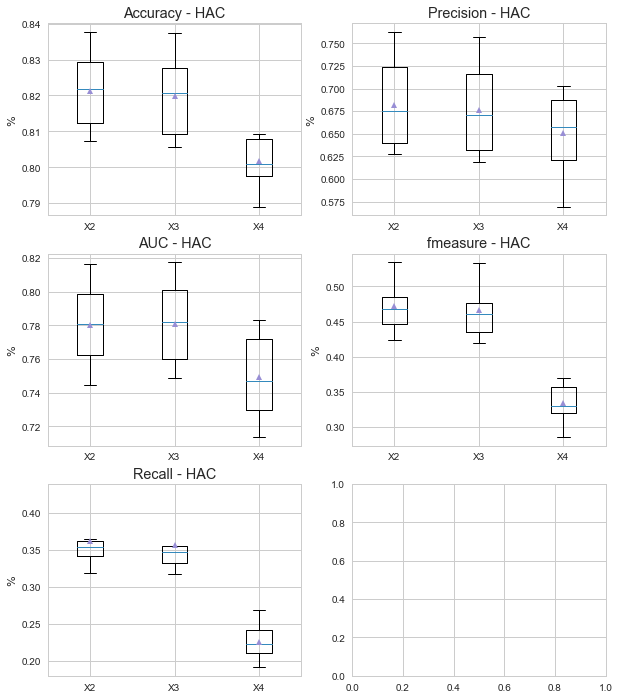

In [479]:
# metrics results of HAC model

acc_hac = [hac_accuracy_task1_anova, hac_accuracy_task2_anova, hac_accuracy_task3_anova]
auc_hac = [hac_auc_task1_anova, hac_auc_task2_anova, hac_auc_task3_anova] 
recall_hac = [hac_recall_task1_anova, hac_recall_task2_anova, hac_recall_task3_anova]
precision_hac = [hac_precision_task1_anova, hac_precision_task2_anova, hac_precision_task3_anova]
f_hac = [hac_fmeasure_task1_anova, hac_fmeasure_task2_anova, hac_fmeasure_task3_anova]

#plt.figure(figsize=(30,20))
fig, axes = plt.subplots(3, 2, sharey=False, sharex=False, figsize = (10,12))

axes[0,0].boxplot(acc_hac, showmeans=True)
axes[0,0].set_title ('Accuracy - HAC')
axes[0,0].set_ylabel('%')
axes[0,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[1,0].boxplot(auc_hac, showmeans=True)
axes[1,0].set_title('AUC - HAC')
axes[1,0].set_ylabel('%')
axes[1,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])


axes[2,0].boxplot(recall_hac, showmeans=True)
axes[2,0].set_title('Recall - HAC')
axes[2,0].set_ylabel('%')
axes[2,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[0,1].boxplot(precision_hac, showmeans=True)
axes[0,1].set_title('Precision - HAC')
axes[0,1].set_ylabel('%')
axes[0,1].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[1,1].boxplot(f_hac, showmeans=True)
axes[1,1].set_title('fmeasure - HAC')
axes[1,1].set_ylabel('%')
axes[1,1].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

plt.show()
 

These plots show that X2 = ['EDUCATION','LIMIT_BAL'] and X3 = [Age, Marriage, and Sex] groups are the best performers all around. All the metrics values higher than those of the other group. 
We will look at the HAC [Age, Marriage, and Sex] and ['EDUCATION','LIMIT_BAL'] clusters for any insights. 

 <a href="#top">Back to top</a>


#### Visualizing HAC [Age, Marriage, and Sex] and ['EDUCATION','LIMIT_BAL'] clusterings

CPU times: user 1min 24s, sys: 46.8 s, total: 2min 10s
Wall time: 2min 42s


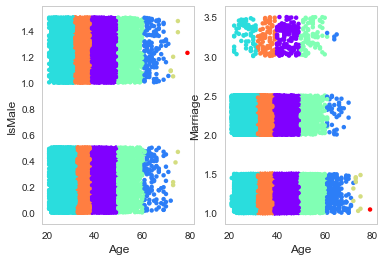

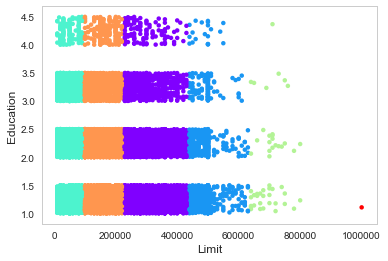

In [299]:
%%time 
# normalizing 
# df_sub = df_imputed[['Survived','Age','Pclass','Sex']]
# df_sub.Sex = df_sub.Sex=='male' 

# df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
# df_normalized.Survived = df_sub.Survived

# n_fare=6 # 
# d_fam=8 # 

X2 = df_copy1[['EDUCATION', 'LIMIT_BAL', ]]
X3 = df_copy1[[ 'AGE','IsMale','MARRIAGE']]


# cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare = AgglomerativeClustering(n_clusters=6, linkage='average')
cls_fare.fit(X2)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
# cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
cls_fam = AgglomerativeClustering(n_clusters=7, linkage='average')
cls_fam.fit(X3)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
X3=X3.values
plt.scatter(X3[:, 0], X3[:, 1]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('IsMale')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X3[:, 0], X3[:, 2]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('Marriage')
plt.grid()

X2=X2.values
plt.figure()
plt.scatter(X2[:, 1], X2[:, 0]+np.random.random(X2[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Limit'), plt.ylabel('Education')
plt.grid()


HAC is very similar to Kmeans. However, there are more clusters with HAC. It was able to dectect outliner here (red values). 

For X2: we can see that there are 7 clusters that discretized similar to the way we cut with q-cut. Education vs Limit Balance = Again clustering accross the 4 levels of education into 6 distinct clusters. 
For up to 300000 NT limit, it's denser for those with graduate school degree (EDUCATION = 1), those with college degree (EDUCATION = 2) and those with highschool degree (EDUCATION = 3), but much less dense for those in the 'Others' group (Education = 4). For higher limit, it's less dense for those with highschool degree (EDUCATION = 3) and those with 'Others' (Education = 4). 

For X3: Again, we can see that there are 7 clusters (visually) that discretized similar to the way we cut with q-cut. 
    For Age vs IsMale, Both males and females have been clustered into 7 distinct clusters. There is clustering accross the levels (males and females are classified together). The age ranges from 20 - 70 years old are more populated and both sexes have about equal representation and clusters. There are very mimimal data > 70. 
    For Age vs Marriage, clustering accross the 3 levels of marriage into 5 distinct clusters. The densest clusters are from age 20-50. The "Married" (=1) and 'Single' (=2) groups have higher density than 'Others'(=3) in all the clusters. 

Next, we will use ROC to determine which cluster is the best performer with Kmeans methods.

 <a href="#top">Back to top</a>

Next we will look at ROC of all HAC clusters.

### ROC for all HAC models

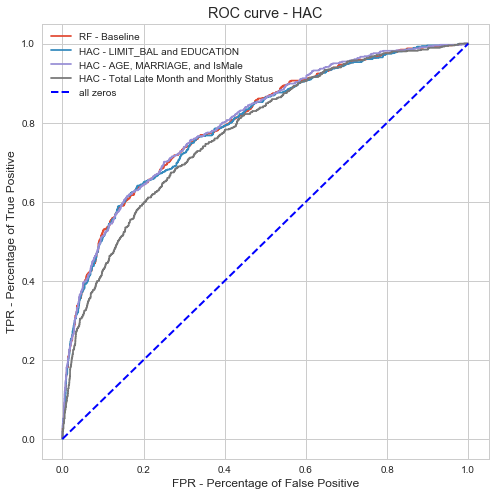

In [478]:
## adding ROC 
# ROC for RF Baseline, HAC clusters. 
plt.figure(figsize=(8,8))
plt.plot(fpr_rf_task1, tpr_rf_task1, label='RF - Baseline')
plt.plot(hac_fpr_rf_task1, hac_tpr_rf_task1, label='HAC - LIMIT_BAL and EDUCATION')
plt.plot(hac_fpr_rf_task2, hac_tpr_rf_task2, label='HAC - AGE, MARRIAGE, and IsMale')
plt.plot(hac_fpr_rf_task3, hac_tpr_rf_task3, label='HAC - Total Late Month and Monthly Status')
# plt.plot(hac_fpr_rf_task12, hac_tpr_rf_task12, label='HAC - Group 1 and 2')
# plt.plot(hac_fpr_rf_task13, hac_tpr_rf_task13, label='HAC - Group 1 and 3')
# plt.plot(hac_fpr_rf_task23, hac_tpr_rf_task23, label='HAC - Group 2 and 3')

## Draw the diagonal line 
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='all zeros') # diagonal line

##Title, label, and legend 
plt.xlabel('FPR - Percentage of False Positive')
plt.ylabel('TPR - Percentage of True Positive')
plt.title('ROC curve - HAC')
plt.legend(loc="upper left")
plt.show()

# This discretization does not help to increase the accuracy or AUC on average. It neither help to lower the deviation from the mean. 
# Next, we will try to combine different clusterings.

We can see that clusters [Age, Marriage, and Sex] and the stack of [Age, Marriage, and Sex]  and ['EDUCATION','LIMIT_BAL'] perform the best here. However, they do not perform significantly better than full model Random Forest. 

### DBSCAN Evaluation and Results

 <a href="#top">Back to top</a>

**DBSCAN performance of X2 with best parameters: eps = 50000, mpts = 700**

In [354]:
%%time 

from sklearn.cluster import DBSCAN

X2 = df_copy1[['LIMIT_BAL','EDUCATION']]

# params = []
#for eps in [0.1, 0.125, 0.15]:
    #for mpts in range(40,50):
# for eps in [100000, 125000, 150000]:
#     for mpts in [10000, 30000, 50000, 100000, 200000] :
    
# append on the clustering
cls_fam = DBSCAN(eps=50000, min_samples=700)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['IsMale','MARRIAGE', 'AGE', 
'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
'Jun_Bill', 'May_Bill', 'Apr_Bill', 
'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=1 so that we will always get the same output the first time we make the split. We want reproducible results.


# get a handle to the classifier object, which defines the type
dbs_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    dbs_rf_task1.fit(X[train], y[train])
    y_pred_proba = dbs_rf_task1.predict_proba(X[test])[:, 1]
    dbs_fpr_rf_task1, dbs_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = dbs_rf_task1.predict(X[test]) # y_pred is y_hat[test] 

    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    dbs_accuracy_task1_anova.append(acc)
    dbs_conf_task1_anova.append([conf])
    dbs_recall_task1_anova.append(recall)
    dbs_precision_task1_anova.append(precision)
    dbs_fmeasure_task1_anova.append(f)
    dbs_auc_task1_anova.append(auc_score)  

print ("acc", np.mean(dbs_accuracy_task1_anova), "+-", np.std(dbs_accuracy_task1_anova))
print ("auc", np.mean(dbs_auc_task1_anova)) 

#         acc_std = cross_val_score(dbs_rf_task1,X,y=y,cv=cv)
#         params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

#         # metrics
#         auc = roc_auc_score(y[test], y_pred_proba) 
#         print (eps,mpts,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )

#         print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

acc 0.819969706167 +- 0.0109899707186
auc 0.774316482014
CPU times: user 1min 43s, sys: 3.36 s, total: 1min 46s
Wall time: 41.7 s


**DBSCAN performance of X3 with best parameters: eps = 2.5, mpts = 700**

 <a href="#top">Back to top</a>

In [355]:
%%time 

from sklearn.cluster import DBSCAN

X3 = df_copy1[['IsMale','MARRIAGE', 'AGE']]

# params = []
# for eps in [2, 2.5, 3]:
#     for mpts in [100, 300, 500, 700]:

# append on the clustering
cls_fam = DBSCAN(eps=2.5, min_samples=700)
cls_fam.fit(X3)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['LIMIT_BAL','EDUCATION',
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status',              
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


# get a handle to the classifier object, which defines the type
dbs_rf_task2 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    dbs_rf_task2.fit(X[train], y[train])
    y_pred_proba = dbs_rf_task2.predict_proba(X[test])[:, 1]
    dbs_fpr_rf_task2, dbs_tpr_rf_task2, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = dbs_rf_task2.predict(X[test]) # y_pred is y_hat[test] 
    
    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    dbs_accuracy_task2_anova.append(acc)
    dbs_conf_task2_anova.append([conf])
    dbs_recall_task2_anova.append(recall)
    dbs_precision_task2_anova.append(precision)
    dbs_fmeasure_task2_anova.append(f)
    dbs_auc_task2_anova.append(auc_score) 

print ("acc", np.mean(dbs_accuracy_task2_anova), "+-", np.std(dbs_accuracy_task2_anova))
print ("auc", np.mean(dbs_auc_task2_anova)) 

#         acc_std = cross_val_score(dbs_rf_task2,X,y=y,cv=cv)
#         params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

#         # metrics
#         auc = roc_auc_score(y[test], y_pred_proba) 
#         print (eps,mpts,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )

#         print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


acc 0.819936039493 +- 0.0100772144577
auc 0.780554556595
CPU times: user 1min 42s, sys: 3.08 s, total: 1min 45s
Wall time: 41 s


**DBSCAN performance of X4 with best parameters: eps = 2, mpts = 500**

 <a href="#top">Back to top</a>

In [356]:
%%time 

from sklearn.cluster import DBSCAN

X4 = df_copy1[['Total_Month_Late', 'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status','Apr_Payment_Status']]

# params = []
# for eps in [2, 2.5, 3, 3.5, 4]:
#     for mpts in [100, 300, 500, 700]:

# append on the clustering
cls_fam = DBSCAN(eps=2, min_samples=500)
cls_fam.fit(X4)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['LIMIT_BAL','EDUCATION', 'IsMale','MARRIAGE', 'AGE',              
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=1) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.


# get a handle to the classifier object, which defines the type
dbs_rf_task3 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    dbs_rf_task3.fit(X[train], y[train])
    y_pred_proba = dbs_rf_task3.predict_proba(X[test])[:, 1]
    dbs_fpr_rf_task3, dbs_tpr_rf_task3, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = dbs_rf_task3.predict(X[test]) # y_pred is y_hat[test] 

    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

    # add metrics to metric lists 
    dbs_accuracy_task3_anova.append(acc)
    dbs_conf_task3_anova.append([conf])
    dbs_recall_task3_anova.append(recall)
    dbs_precision_task3_anova.append(precision)
    dbs_fmeasure_task3_anova.append(f)
    dbs_auc_task3_anova.append(auc_score) 

print ("acc", np.mean(dbs_accuracy_task3_anova), "+-", np.std(dbs_accuracy_task3_anova))
print ("auc", np.mean(dbs_auc_task3_anova)) 

#         acc_std = cross_val_score(dbs_rf_task3,X,y=y,cv=cv)
#         params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

#         # metrics
#         auc = roc_auc_score(y[test], y_pred_proba) 
#         print (eps,mpts,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )

# #         print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


acc 0.799334782245 +- 0.00629297292372
auc 0.74774383578
CPU times: user 1min 53s, sys: 3.75 s, total: 1min 57s
Wall time: 51.3 s


### Plot the result metrics of all DBSCAN models

 <a href="#top">Back to top</a>

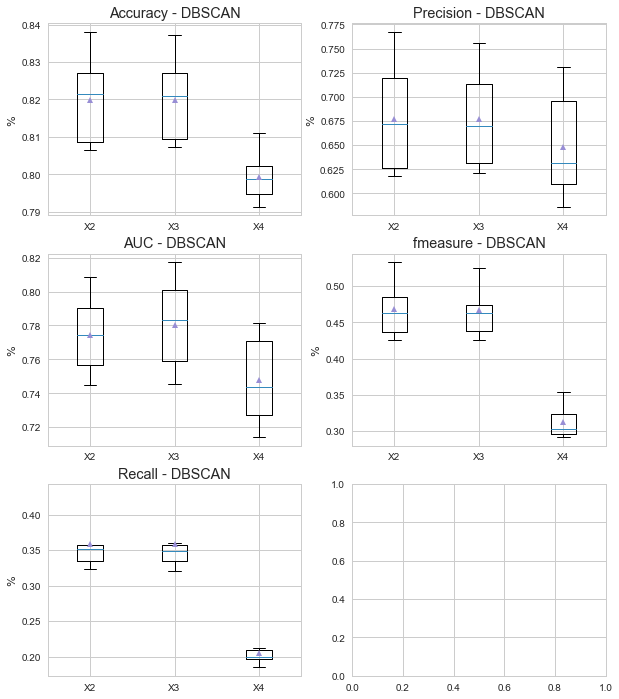

In [477]:
# metrics results of DBSCAN model

acc_dbs = [dbs_accuracy_task1_anova, dbs_accuracy_task2_anova, dbs_accuracy_task3_anova]
auc_dbs = [dbs_auc_task1_anova, dbs_auc_task2_anova, dbs_auc_task3_anova] 
recall_dbs = [dbs_recall_task1_anova, dbs_recall_task2_anova, dbs_recall_task3_anova]
precision_dbs = [dbs_precision_task1_anova, dbs_precision_task2_anova, dbs_precision_task3_anova]
f_dbs = [dbs_fmeasure_task1_anova, dbs_fmeasure_task2_anova, dbs_fmeasure_task3_anova]

#plt.figure(figsize=(30,20))
fig, axes = plt.subplots(3, 2, sharey=False, sharex=False, figsize = (10,12))

axes[0,0].boxplot(acc_dbs, showmeans=True)
axes[0,0].set_title ('Accuracy - DBSCAN')
axes[0,0].set_ylabel('%')
axes[0,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[1,0].boxplot(auc_dbs, showmeans=True)
axes[1,0].set_title('AUC - DBSCAN')
axes[1,0].set_ylabel('%')
axes[1,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])


axes[2,0].boxplot(recall_dbs, showmeans=True)
axes[2,0].set_title('Recall - DBSCAN')
axes[2,0].set_ylabel('%')
axes[2,0].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[0,1].boxplot(precision_dbs, showmeans=True)
axes[0,1].set_title('Precision - DBSCAN')
axes[0,1].set_ylabel('%')
axes[0,1].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

axes[1,1].boxplot(f_dbs, showmeans=True)
axes[1,1].set_title('fmeasure - DBSCAN')
axes[1,1].set_ylabel('%')
axes[1,1].set_xticklabels(['X2', 'X3', 'X4', 'X2_X3', 'X2_X4', 'X3_X4'])

plt.show()
 

These plots show that X2 = ['EDUCATION','LIMIT_BAL'] and X3 = [Age, Marriage, and Sex] groups are the best performers all around. All the metrics values higher than those of the other group. 


 <a href="#top">Back to top</a>
 
We will look at the DBSCAN [Age, Marriage, and Sex] and ['EDUCATION','LIMIT_BAL'] clusters for any insights. 


#### Visualizing DBSCAN [Age, Marriage, and Sex] and ['EDUCATION','LIMIT_BAL']


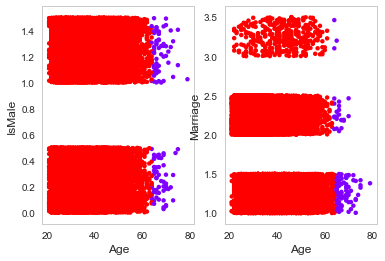

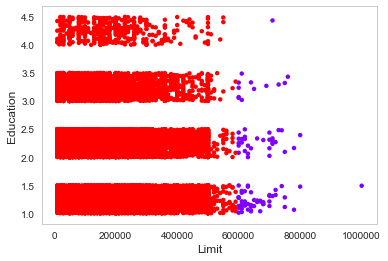

In [300]:
# normalizing 
# df_sub = df_imputed[['Survived','Age','Pclass','Sex']]
# df_sub.Sex = df_sub.Sex=='male' 

# df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
# df_normalized.Survived = df_sub.Survived

# n_fare=6 # 
# d_fam=8 # 

X2 = df_copy1[['EDUCATION', 'LIMIT_BAL']]
X3 = df_copy1[[ 'AGE','IsMale','MARRIAGE']]

# cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
# cls_fare = AgglomerativeClustering(n_clusters=6, linkage='average')
cls_fare = DBSCAN(eps=50000, min_samples=700)
cls_fare.fit(X2)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
# cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
# cls_fam = AgglomerativeClustering(n_clusters=7, linkage='average')
cls_fam = DBSCAN(eps=2.5, min_samples=700)
cls_fam.fit(X3)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
X3=X3.values
plt.scatter(X3[:, 0], X3[:, 1]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('IsMale')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X3[:, 0], X3[:, 2]+np.random.random(X3[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('Marriage')
plt.grid()

X2=X2.values
plt.figure()
plt.scatter(X2[:, 1], X2[:, 0]+np.random.random(X2[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Limit'), plt.ylabel('Education')
plt.grid()


There is much less clusters with DBSCAN method. This is expected. 

For X2: Education vs Limit Balance, again clustering accross the 4 levels of education into 2 distinct clusters. 
For up to 300000 NT limit, it's denser for those with graduate school degree (EDUCATION = 1), those with college degree (EDUCATION = 2) and those with highschool degree (EDUCATION = 3), but much less dense for those in the 'Others' group (Education = 4). For higher limit, it's less dense for those with highschool degree (EDUCATION = 3) and those with 'Others' (Education = 4). 

For X3: For Age vs IsMale, Both males and females have been clustered into 2 distinct clusters. There is clustering accross the levels (males and females are classified together). The age ranges from 20 - 70 years old are more populated and both sexes have about equal representation and clusters. There are very mimimal data > 70. 
    For Age vs Marriage, clustering accross the 3 levels of marriage into 2 distinct clusters. The densest clusters are from age 20-50. The "Married" (=1) and 'Single' (=2) groups have higher density than 'Others'(=3) in all the clusters. 


 <a href="#top">Back to top</a>
 
Next we will look at ROC of all DBSCAN clusters.


### ROC for all DBSCAN Models

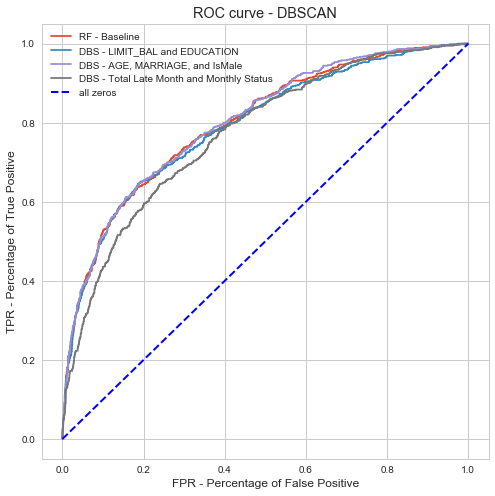

In [476]:
## adding ROC 
# ROC for RF Baseline, HAC clusters. 
plt.figure(figsize=(8,8))
plt.plot(fpr_rf_task1, tpr_rf_task1, label='RF - Baseline')
plt.plot(dbs_fpr_rf_task1, dbs_tpr_rf_task1, label='DBS - LIMIT_BAL and EDUCATION')
plt.plot(dbs_fpr_rf_task2, dbs_tpr_rf_task2, label='DBS - AGE, MARRIAGE, and IsMale')
plt.plot(dbs_fpr_rf_task3, dbs_tpr_rf_task3, label='DBS - Total Late Month and Monthly Status')
# plt.plot(hac_fpr_rf_task12, hac_tpr_rf_task12, label='HAC - Group 1 and 2')
# plt.plot(hac_fpr_rf_task13, hac_tpr_rf_task13, label='HAC - Group 1 and 3')
# plt.plot(hac_fpr_rf_task23, hac_tpr_rf_task23, label='HAC - Group 2 and 3')

## Draw the diagonal line 
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='all zeros') # diagonal line

##Title, label, and legend 
plt.xlabel('FPR - Percentage of False Positive')
plt.ylabel('TPR - Percentage of True Positive')
plt.title('ROC curve - DBSCAN')
plt.legend(loc="upper left")
plt.show()

# This discretization does not help to increase the accuracy or AUC on average. It neither help to lower the deviation from the mean. 
# Next, we will try to combine different clusterings.

We can see that clusters [Age, Marriage, and Sex]  and ['EDUCATION','LIMIT_BAL'] perform the best with this method. However, they do not perform significantly better than full model Random Forest. 


 <a href="#top">Back to top</a>

## Visualizing the best clusters and its best parameters of each of the models

Now lets take the best performers from each dataset and show the clustering that they found in the data.


Clustering Visualization for X2:

    * The best DBSCAN parameters are eps = 50000, mpts = 700
    * The best HAC parameters are C= 6 and average link 
    * The best Kmean parameters is n_cluster = 6


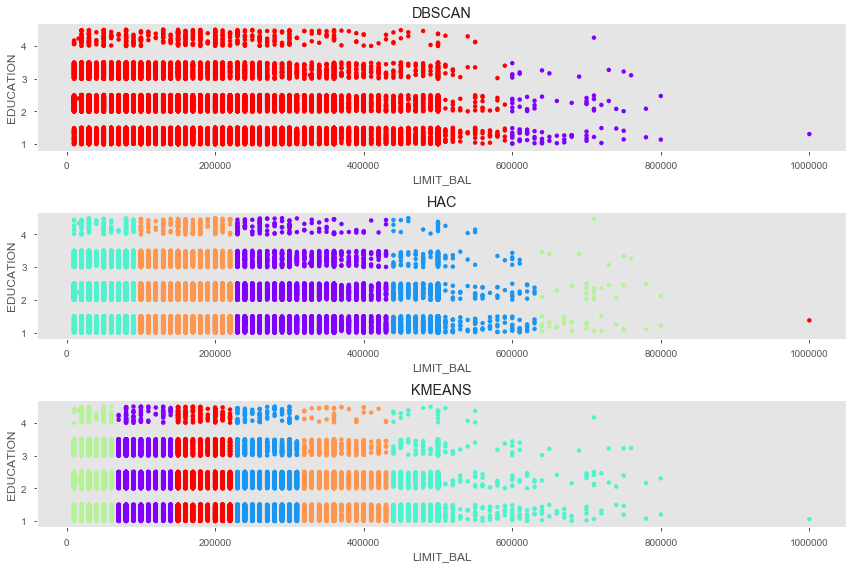

In [139]:
# for X2: 
# the best DBSCAN parameters are eps = 50000, mpts = 700
# the best HAC parameters are C= 6 and average link 
# the best Kmean parameters is n_cluster = 6

X2 = df_copy1[['LIMIT_BAL','EDUCATION']]
# data = X2

#cls = DBSCAN(eps=0.1, min_samples=6)
cls = DBSCAN(eps=50000, min_samples=700)
cls.fit(X2)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=6, linkage='average')
cls.fit(X2)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=6, random_state=1)
cls.fit(X2)
kmn_labels = cls.labels_

X2 = X2.values
fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,1, i+1) #subplot(nrows, ncols, plot_number)
#     plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)

    plt.xlabel('LIMIT_BAL'), plt.ylabel('EDUCATION')
    plt.grid()
    plt.title(title[i])
 
    
plt.tight_layout()
plt.show()

For the X2 parameter (Limit_Bal vs Education):
1. DBSCAN - Only has 2 clusters across all the levels of education. This is probably not optimal for our dataset.
2. HAC- A much better clustering job with 5 clusters and 1 outlier. Again the clusters are shared across the 4 levels of Education.
3. KMEANS - The best distinction between the clusters with 6 clusters that are shared across all Education levels.


 <a href="#top">Back to top</a>

Clustering Visualization for X3:

* The best DBSCAN parameters are eps = 2.5, mpts = 700
* The best HAC parameters are C= 7 and average link  
* The best Kmean parameters is n_cluster = 8 


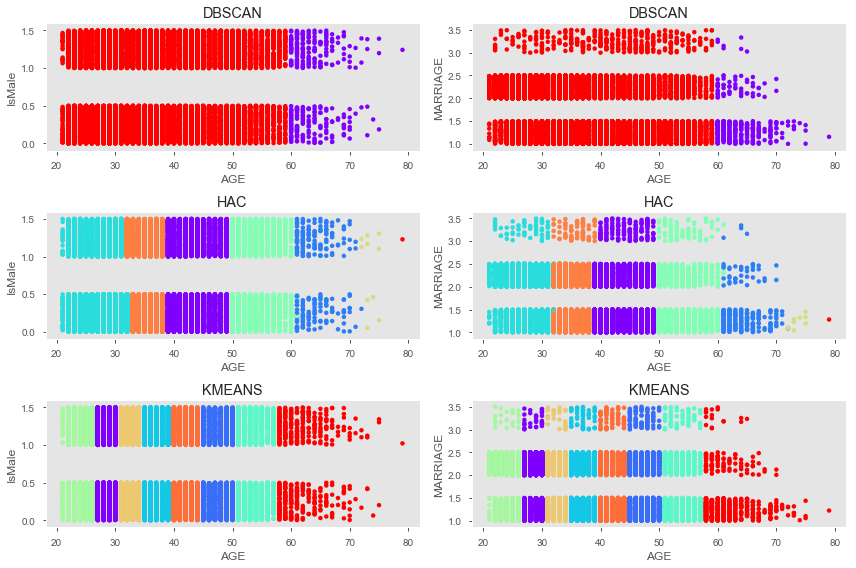

In [140]:
# normalizing 
# df_sub = df_imputed[['Survived','Age','Pclass','Sex']]
# df_sub.Sex = df_sub.Sex=='male' 

# df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
# df_normalized.Survived = df_sub.Survived

# for X3
X3 = df_copy1[[ 'AGE','IsMale','MARRIAGE']]
#data = X3

cls = DBSCAN(eps=2.5, min_samples=700)
cls.fit(X3)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=7, linkage='average')
cls.fit(X3)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=8, random_state=1)
cls.fit(X3)
kmn_labels = cls.labels_

X3 = X3.values
fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
#     X3=X3.values # X3=X3.values
#     plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.scatter(X3[:, 0], X3[:, 1]+np.random.random(X3[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('AGE'), plt.ylabel('IsMale')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
#     X3=X3.values
#     plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.scatter(X3[:, 0], X3[:, 2]+np.random.random(X3[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('AGE'), plt.ylabel('MARRIAGE')
    plt.grid()
    plt.title(title[i])
 
    
plt.tight_layout()
plt.show()

For the X3 parameter (Age, IsMale and Marriage):
1. DBSCAN - Age vs IsMale = Only 2 clusters were found here.
          - Age vs. Marriage = Also just 2 clusters
    Probably suboptimal because one would expect more separation across the levels of marriage and the different age ranges.
    Clearly, just the difference in customers ages should have more variation that we are seeing in this plot.
2. HAC- Age vs IsMale = A much better clustering job with 6 clusters and 1 outlier. Again the clusters are shared across
                        the between the males and females.
      - Age vs. Marriage = 5 clusters for the 'singles' and 'others' groups but 6 clusters (plus an outlier) for the 'married' 
                         group. The married group seems to have a much more variation than the other 2 groups. 
3. KMEANS - The best distinction between the clusters with 8 clusters that are shared across all IsMale and Marriage levels.

 <a href="#top">Back to top</a>

### Plot ROC of best Kmean, HAC, and DBSCAN models vs. Baseline RF. 

Both X2 and X3 have good results for all the Kmean, HAC, and DBSCAN models. So we will plot the ROC of both X2 and X3 for each models for comparison.

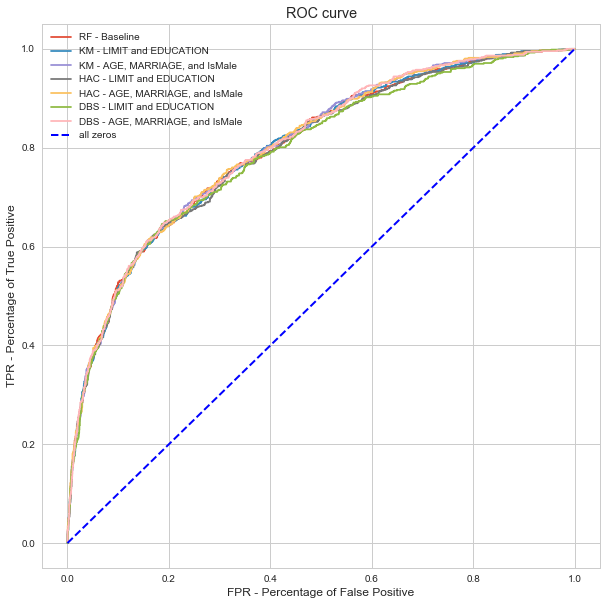

In [473]:
# adding ROC 
# ROC for RF Baseline, HAC clusters. 
plt.figure(figsize=(10,10))
plt.plot(fpr_rf_task1, tpr_rf_task1, label='RF - Baseline')
plt.plot(km_fpr_rf_task1, km_tpr_rf_task1, label='KM - LIMIT and EDUCATION') 
plt.plot(km_fpr_rf_task2, km_tpr_rf_task2, label='KM - AGE, MARRIAGE, and IsMale')
plt.plot(hac_fpr_rf_task1, hac_tpr_rf_task1, label='HAC - LIMIT and EDUCATION')
plt.plot(hac_fpr_rf_task2, hac_tpr_rf_task2, label='HAC - AGE, MARRIAGE, and IsMale')
plt.plot(dbs_fpr_rf_task1, dbs_tpr_rf_task1, label='DBS - LIMIT and EDUCATION') 
plt.plot(dbs_fpr_rf_task2, dbs_tpr_rf_task2, label='DBS - AGE, MARRIAGE, and IsMale') 


## Draw the diagonal line 
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='all zeros') # diagonal line

##Title, label, and legend 
plt.xlabel('FPR - Percentage of False Positive')
plt.ylabel('TPR - Percentage of True Positive')
plt.title('ROC curve')
plt.legend(loc="upper left")
plt.show()

# This discretization does not help to increase the accuracy or AUC on average. It neither help to lower the deviation from the mean. 
# Next, we will try to combine different clusterings.

Both X2 and X3 have good results for all the Kmean, HAC, and DBSCAN models. However, looking at the ROC of each of the method, X3 seems to perform slightly better with the highest AUC. X3 also give the highest recall in each of the model. Therefore, we choose X3 (AGE, MARRIGE, and IsMale) the best cluster group for each of the Kmean, HAC, and DBSCAN. 

 <a href="#top">Back to top</a>

<div id='MODEL4'/>
# 7. Modeling and Evaluation 4: Summarize the Ramifications 

 <a href="#top">Back to top</a>

### Results Summary:


   #### Base Line RF Result: 
    
        The baseline performance with RF (max_depth=10 and n_estimators=150): mean accuracy and deviation 82.03 +- 1.01%, an AUC 77.80. Executing time is 1min 15s. 


   #### Kmeans Best n_cluster Result: 
        For X2 ('LIMIT_BAL', 'EDUCATION'): best n_cluster = 6, mean accuracy and deviation 82.03 +- 1.01%, AUC 77.80%. Executing time is 43.4s

        For X3 ('AGE', 'IsMale', and 'MARRIAGE'): best n_cluster = 8, mean accuracy and deviation is 82.00 +- 1.00%, AUC is 78.06%. Executing time is 37.2s

        For X4 (‘Total_Month_Late’, all montly payment status):  best n_cluster = 4, mean accuracy and deviation is 80.04 +- 0.93, AUC is 74.93%. Executing time 36.3s.

   #### HAC Best n_cluster and link Result: 
        For X2 ('LIMIT_BAL', 'EDUCATION'): best C= 6 and 'average' link, average accuracy =  82.12 +- 1.00% and AUC =  78.00%. Executing time 2min 43s

        For X3 ('AGE', 'IsMale', and 'MARRIAGE'): best C= 7 and 'average' link, average accuracy = 81.97 +- 1.07% and AUC = 78.09%. Executing time 1min 50s. 

        For X4 ((‘Total_Month_Late’, all montly payment status): best C= 4 and 'ward' link, average accuracy = 80.16 +- 0.62% and AUC = 74.95%. Executing time 1min 34s

   #### DBSCAN Best eps and mpts Result: 
    
    For X2 ('LIMIT_BAL', 'EDUCATION'): best parameters eps = 50000, mpts = 700, average accuracy =  82.00 +- 1.09% and AUC =  77.43%. Executing time 41.7 s

    For X3 ('AGE', 'IsMale', and 'MARRIAGE'): best parameters eps = 2.5, mpts = 700, average accuracy 82.00 +- 01.00% and AUC =  78.06%. Executing time 41 s 

    For X4 ((‘Total_Month_Late’, all montly payment status): best parameter eps = 2, mpts = 500, average accuracy = 80.00 +- .62% and AUC = 74.77%. Executing time 51.3s


### Summary and Ramifications:  
    
    The RF model benchmark is the nice curve at the left. All the other models do not seem to give better metrics, as seen in accuracy and AUC results. The RF model benchmark data with the additional columns of the total late month status, 'Total_Month_Late', did worse in term of accuracy but better in term of deviation. Among all the clustering models, comparatively, the agglomeratice models did very slightly better than the kmeans and DBSCAN models. 
    
    Both X2 and X3 have good results for all the Kmean, HAC, and DBSCAN models. However, looking at the ROC of each of the method, X3 seems to perform slightly better with the highest AUC. X3 also give the highest recall in each of the model. Therefore, we choose X3 (AGE, MARRIGE, and IsMale) the best cluster group for each of the Kmean, HAC, and DBSCAN.

    As stated from the beginning, the negative prediction value is a highly important measure given the context of default prediction and that AUC is our ultimate comparing metrics. With this data set, we found that none of the cluster models did better than the Random Forest model. That means, no additional or hidden correlation was found with our clusterings. However, The Random Forest model is less efficient compared to clustering methods with executing time around 1min 15s. Kmeans is the most efficient with executing time around 36s - 43s. Next is HAC with executing time around 34s-50s. DBSCAN is very slightly slower around 41s-51.3s.   
    
    The RF benchmark had a high accuracy of 82%, this is expected as our data is imbalance with 79% all 0 default. The purpose of this study was to explore if clustering would improve prediction and the result show they do not. In the end, all of the clustering models did not add predictive value in the way we tested for this data set. This is expected because K-Means works best in datasets that have with clusters that are roughly equally-sized and shaped roughly regularly. So it works very well if you have the "farthest" heuristic and the right number of centroids. However, it does not work well on the unusual shape data. And k-means can only be applied when the data points lie in a Euclidean space, failing for more complex types of data. Another drawback of K-means is the requirement of choosing k, and the dependence of the output on the initial cluster configuration, which make it hard to identify the optimum parameters [46]. It's interesting to see that DBSCAN does well here, which is expected as DBSCAN is density-based that assumes contiguous clusters and works best spatial data and high density data like our data set. However, the task of determining eps and number of points (MinPts) is also tedious. 
    
    Overall, for large data set and spatial and high density like our data, DBSCAN is recommended as it offers good prediction and much better efficiency. 
    
 <a href="#top">Back to top</a>

<div id='DEP'/>
# 8. Deployment 

The goal of our classification models is to create a model that can be used to predict if a person is going to default the following month. The model will be able to identify key features to predict the possibility of default. 
A deployment of the model would examine key features and suggest which feature should be improved to reduce or prevent the possibility of default. 

It is difficult to measure the value of the model for this purpose. One way to measure the value is to implement the model to test in various credit card businesses. This is envisioned by customer service contacting prospective defaulters to offer help or whatever action to avoid the predicted outcome. At the point where the Credit Card company has fewer defaults and people have fewer defaults financial charges, then you have a valid comparison: old default rate versus new default rate.

With any analytic models, continued exploration of alternatives or a better model is desired. This analysis was oriented at exploring data clustering approaches using Scikit Learn to improving the analysis, with a goal of finding non-obvious relationships that would improve the predictions focused upon reducing false negatives and increase overall accuracy. What was discovered is that various unsupervised clustering algorithms did not find hidden relationships, and that Random Forest produced the best predictions. Based on measurement results, our suggestion is that Random Forest should be deployed into the field to predict default possibility.

One limitation in our analysis was with computation (including computing power and memory sizes). With a data set of 30,000 entries and 80/20 train/test split, the executing time has been much slower when using clustering which took up to 30 mins to execute. Mini-Batch Kmeans can be used to speed up the process time. Cluster algorithms cannot be ruled out from our study, although a more powerful computer may be recommended for better execution time.

Another drawback of creating a model for this purpose is that the data would need to be updated in a frequent basis to tune the model to current trends. A model that predicts credit card default would be popular two years ago may not be useful now, especially when the economy is in recession. A model that predicts credit limit may need to be updated more often, as credits are very easy to be obtained nowadays, especially in good economy. 

However, updates to the model would be determined by its overall impact to the customer and company. At some point the updates will not significantly improve the prediction at which time the company may decide to just keep it as-is and move the resource to more productive problems that need to be tackled. 

Another feature that may need to be added to improve the prediction of our classifications is adding a monthly credit score. 



 <a href="#top">Back to top</a>

<div id='EXP'/>

# 9. Exceptional Work: Kmeans Clustering Validity with Centroids and Spectral Clustering

In this section we will cluster our data using sklearn SpectralClustering.

 <a href="#top">Back to top</a>

## Clustering Validity with centroids

- Numerical values can be used to access various aspects of a cluster validity can be divided into:
   1. Internal criterion = when a clustering result is evaluated based on the data that was clustered itself. E.g. Dunn's Index,    Silhouette coefficient
   2. External criterion = clustering results are evaluated based on data that was not used for clustering, such as known class       labels and external benchmarks. E.g. Purity, Rand, F Measure.
   3. Cluster tendency = measure to what degree clusters exist in the data to be clustered, and may be performed as an initial         test, before attempting clustering. E.g. Hopkins statistics.


Estimated number of clusters: 2
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: 0.007
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.602


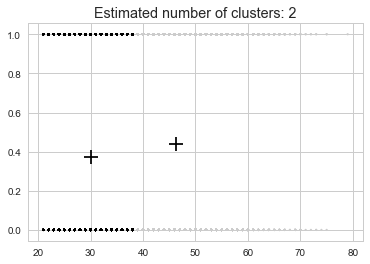

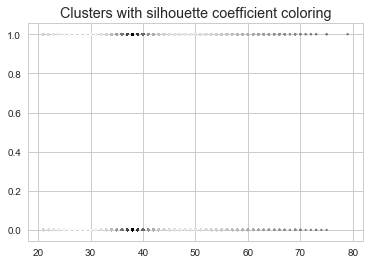

CPU times: user 2min 42s, sys: 5min 51s, total: 8min 34s
Wall time: 14min 34s


In [317]:
%%time 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

data = X3 
labels_true = df_copy1.default.values

n_clusters = 2
model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
# model = DBSCAN(eps=2.5, min_samples=700).fit(data)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data, labels))

silhouette_per_sample = metrics.silhouette_samples(data,labels)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):
    centroids.append( [np.mean(data[np.where(labels==lab),0]), np.mean(data[np.where(labels==lab),1])] )
centroids = np.array(centroids)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels,
                    cmap=plt.cm.spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
                cmap=plt.cm.gray, s=5, linewidths=0)
plt.title('Clusters with silhouette coefficient coloring')
plt.show()

From our analysis, we have an estimate of 2 clusters with a Silhouette coefficient of 0.62. All the other validity measures are about 0. This matches the Silhouette coefficient from our earlier analysis and although we would like it much closer to 1, we will accept it as fair.

Estimated number of clusters: 8
Homogeneity: 0.003
Completeness: 0.001
V-measure: 0.001
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.001
Silhouette Coefficient: 0.479


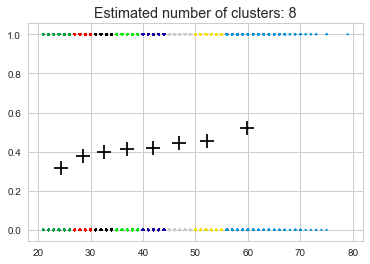

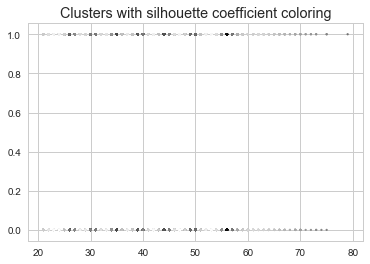

In [308]:
%%time 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

data = X3 
labels_true = df_copy1.default.values

n_clusters = 8
model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
# model = DBSCAN(eps=2.5, min_samples=700).fit(data)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data, labels))

silhouette_per_sample = metrics.silhouette_samples(data,labels)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):
    centroids.append( [np.mean(data[np.where(labels==lab),0]), np.mean(data[np.where(labels==lab),1])] )
centroids = np.array(centroids)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels,
                    cmap=plt.cm.spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
                cmap=plt.cm.gray, s=5, linewidths=0)
plt.title('Clusters with silhouette coefficient coloring')
plt.show() 

This time, we have 8 clusters with a much lower Silhoette coefficient of  0.479. All the other validity measures are about 0. This is an even worse measure and so we conclude this clustering is not ideal. 

In [315]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

data = X3 
labels_true = df_copy1.default.values

# n_clusters = 8
# model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
model = DBSCAN(eps=2.5, min_samples=700).fit(data)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data, labels))

# silhouette_per_sample = metrics.silhouette_samples(data,labels)

# # get the middle of each cluster
# centroids = []
# for lab in range(0,n_clusters_):
#     centroids.append( [np.mean(data[np.where(labels==lab),0]), np.mean(data[np.where(labels==lab),1])] )
# centroids = np.array(centroids)

# plt.figure()
# plt.scatter(data[:, 0], data[:, 1], c=labels,
#                     cmap=plt.cm.spectral, s=5, linewidths=0)

# if len(centroids)>0:
#     plt.scatter(centroids[:, 0], centroids[:, 1],
#                 marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
# plt.title('Estimated number of clusters: %d' % n_clusters_)

# plt.figure()
# plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
#                 cmap=plt.cm.gray, s=5, linewidths=0)
# plt.title('Clusters with silhouette coefficient coloring')
# plt.show()

Estimated number of clusters: 1
Homogeneity: 0.000
Completeness: 0.002
V-measure: 0.000
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.579


Again, lower Silhouette coefficient with 1 cluster. All the other validity measures are about 0. It took too long to generate the plot here. But looking at the data, all the values are very low, suggesting that for this is not a very good clustering method.

 <a href="#top">Back to top</a>

## Spectral Clustering:

Spectal clustering can be a powerful tool for clustering using many of the same methods we have already did above.
Becuase of the computer power, we cannot loop through the affinity and eigen_solver altogether. It also took a very long time to execute the  Spectral Clustering on X3 and X4. 
So, for the comparison purpose of this lab, we will perform Spectral Clustering on X2, which is a smaller set among X3 and X4. We will then try to loop through a range of n_clusters to find the best n_clusters for affinity = 'nearest_neighbors'.

We will start by visualize the X2 Spectral Clustering with n_clusters = 10, affinity = 'nearest_neighbors'.

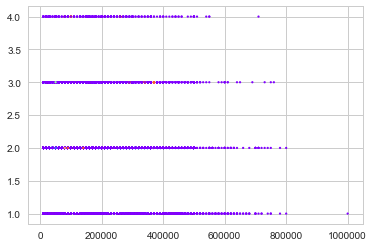

CPU times: user 29 s, sys: 507 ms, total: 29.5 s
Wall time: 15.7 s


In [465]:
%%time 
# The case of SpectralClustering which assumes that the graphical data needs to be calculated from the structure

from sklearn.cluster import SpectralClustering

X2 = df_copy1[[ 'LIMIT_BAL','EDUCATION']] #.values

X = X2.values
nclust = 10

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

Spectral Clustering does not look like Kmeans, HAC, or DBSCAN. They look much like the original data. 
We can see that among graduate school graduates (Education =1), the points are denser all the way to 800,000 while 'Others' group (Education = 4) tappers out starting around 500,000. Higher credit limit is distributed more among those with graduate school degree (EDUCATION = 1), next is among those with college degree (EDUCATION = 2). However, the range of credit limit of all the education class are very similar (below 600,000 NT dollars). Notice also a few outliers (but not invalid) among all the 4 levels of education.

### Find the best n_clusters for Spectral Clustering with affinity = 'nearest_neighbors'

Using the above information, we know that n_clusters for X2 is small. So we are going to loop the with n_clusters in the range (4,9)

In [462]:
%%time 

X2 = df_copy1[['EDUCATION','LIMIT_BAL']].values

for n_fare in range(4,10):
        # get the first clustering
        # cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare = SpectralClustering(n_clusters=n_fare, affinity = 'nearest_neighbors')
        cls_fare.fit(X2)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append 
        y = df_copy1['default']
        X = df_copy1[['IsMale', 'MARRIAGE', 'AGE', 
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!
  
        X = np.column_stack((X,pd.get_dummies(newfeature_fare)))

        # train the new dataset 
        y_hat = np.zeros(y.shape) # we will fill this with predictions

        # We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
        scl = StandardScaler()
        X = scl.fit_transform(X)

        # create cross validation iterator by by performing 10 fold cross validation
        cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
    
        # get a handle to the classifier object, which defines the type
        sp_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

        # iterate through and get predictions for each row in yhat
        for train, test in cv.split(X,y):
            sp_rf_task1.fit(X[train], y[train])
            y_pred_proba = sp_rf_task1.predict_proba(X[test])[:, 1]
            sp_fpr_rf_task1, sp_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
            y_hat[test] = sp_rf_task1.predict(X[test]) # y_pred is y_hat[test] 

        # with std 
        acc_std = cross_val_score(sp_rf_task1,X,y=y,cv=cv)
        # print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100)

#         acc = cross_val_score(clf,X,y=y,cv=cv)
#         params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

#         print ("Clusters",n_fare, "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("=============" )
        print ("Clusters",n_fare)
  
        # metrics
        acc = accuracy_score(y[test], y_hat[test]) 
        auc = roc_auc_score(y[test], y_pred_proba) 

#         print("-----------------------------------") 
#         print("RF - Baseline Classification Report") 
#         print("-----------------------------------") 
        print ("Average accuracy +/- std: ", acc_std.mean()*100, "+-", acc_std.std()*100) # from calling acc_std = cross_val_score(rf_task1,X,y=y,cv=cv)
        # print("Accuracy: %.4f" % accuracy_score(y[test], y_hat[test])) 
        print ('SP1 - RF, accuracy score: {0:.4f}%'.format(acc*100)) # instance acc score 
        # print("Metrics Accuracy: %.4f" % mt.accuracy_score(y, y_hat)) # .format(acc*100)) 
        # print(mt.confusion_matrix(y,y_hat))# confusion matrix  
        # print("AUC: %.4f" % roc_auc_score(y[test], y_pred_proba))
        print("AUC: {0:.4f}%" .format(auc*100))  
        # print(classification_report(y[test], y_hat[test])) 


Clusters 4
Average accuracy +/- std:  82.0702861782 +- 1.05683630734
SP1 - RF, accuracy score: 82.4275%
AUC: 78.8133%
Clusters 5
Average accuracy +/- std:  82.0269450637 +- 1.04293698331
SP1 - RF, accuracy score: 82.3608%
AUC: 79.0340%
Clusters 6
Average accuracy +/- std:  82.0869350685 +- 1.00496424404
SP1 - RF, accuracy score: 82.5942%
AUC: 78.9137%
Clusters 7
Average accuracy +/- std:  82.0435972878 +- 0.966236883709
SP1 - RF, accuracy score: 82.4942%
AUC: 79.0742%
Clusters 8
Average accuracy +/- std:  82.0136183993 +- 1.03709574854
SP1 - RF, accuracy score: 82.4942%
AUC: 79.0426%
Clusters 9
Average accuracy +/- std:  82.0436106211 +- 1.01412665652
SP1 - RF, accuracy score: 82.3941%
AUC: 79.0541%
CPU times: user 25min 48s, sys: 26.4 s, total: 26min 14s
Wall time: 10min 3s


Spectral Clustering has good clusterings but still does not help to increase accuracy or improving deviation and AUC. 
Again, the overall accuracy and AUC are similar to that of KMeans, HAC, DBSCAN methods. AUC and accuracy are stagnant through various n_clusters from 4 to 10. Based on our criteria of choosing the best AUC and accuracy, the best parameter is n_cluster = 7, which gives the best average accuracy = 82.04 +- 0.97 and AUC = 79.07%.

Next, we will run the algorithms with this best n_clusters = 7 and affinity = 'nearest_neighbors' and compare with X2 clustering of Kmeans, HAC, and DBSCAN.

In [463]:
%%time 

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X2 = df_copy1[['EDUCATION','LIMIT_BAL']].values
#nclust = 10
cls = SpectralClustering(n_clusters=7, affinity = 'nearest_neighbors')

cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_copy1['default']
X = df_copy1[['IsMale', 'MARRIAGE', 'AGE', 
       'Sept_Payment_Status','Aug_Payment_Status', 'Jul_Payment_Status', 
       'Jun_Payment_Status', 'May_Payment_Status', 'Apr_Payment_Status', 
       'Sept_Bill', 'Aug_Bill', 'Jul_Bill',
       'Jun_Bill', 'May_Bill', 'Apr_Bill', 
       'Sept_Amount_Paid','Aug_Amount_Paid', 'Jul_Amount_Paid', 
       'Jun_Amount_Paid','May_Amount_Paid', 'Apr_Amount_Paid']] # use everything else in the raw data to predict!

X = np.column_stack((X,pd.get_dummies(newfeature)))

# train the new dataset 
y_hat = np.zeros(y.shape) # we will fill this with predictions

# We don't have to normalize with RF, but for consistancy, we will normalize them. Accuracy and other metric result should not change
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator by by performing 10 fold cross validation
cv = StratifiedKFold(n_splits=10, random_state=None) # starting out with random_state=42 so that we will always get the same output the first time we make the split. We want reproducible results.
                     
# print (cv)
# print (cv.get_n_splits(X,y)) # should be 10 here

# set up arrays to store data
sp_accuracy_task1_anova = [] 
sp_conf_task1_anova = [] 
sp_recall_task1_anova = [] 
sp_precision_task1_anova = [] 
sp_fmeasure_task1_anova = [] 
sp_auc_task1_anova = []  


# get a handle to the classifier object, which defines the type
sp_rf_task1 = RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1) 

# iterate through and get predictions for each row in yhat
for train, test in cv.split(X,y):
    sp_rf_task1.fit(X[train], y[train])
    y_pred_proba = sp_rf_task1.predict_proba(X[test])[:, 1]
    sp_fpr_rf_task1, sp_tpr_rf_task1, _ = roc_curve(y[test], y_pred_proba)
    y_hat[test] = sp_rf_task1.predict(X[test]) # y_pred is y_hat[test] 

    # get the metrics each time: 
    acc = accuracy_score(y[test], y_hat[test])
    conf = mt.confusion_matrix(y[test],y_hat[test]) # confusion matrix 
    recall = mt.recall_score(y[test], y_hat[test])
    precision = mt.precision_score(y[test], y_hat[test])
    f = mt.f1_score(y[test], y_hat[test])
    auc_score = roc_auc_score(y[test], y_pred_proba)

#     add metrics to metric lists 
    sp_accuracy_task1_anova.append(acc)
    sp_conf_task1_anova.append([conf])
    sp_recall_task1_anova.append(recall)
    sp_precision_task1_anova.append(precision)
    sp_fmeasure_task1_anova.append(f)
    sp_auc_task1_anova.append(auc_score) 

print ("acc", np.mean(sp_accuracy_task1_anova), "+-", np.std(sp_accuracy_task1_anova))
print ("auc", np.mean(sp_auc_task1_anova)) 

#         acc_std = cross_val_score(dbs_rf_task3,X,y=y,cv=cv)
#         params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

#         # metrics
#         auc = roc_auc_score(y[test], y_pred_proba) 
#         print (eps,mpts,"Average accuracy = ", acc_std.mean()*100, "+-", acc_std.std()*100, "AUC = ", auc*100 )

# #         print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


acc 0.819902650578 +- 0.00991267509319
auc 0.773968675376
CPU times: user 2min 12s, sys: 2.49 s, total: 2min 14s
Wall time: 54.2 s


It seems that Spectral Clustering has good clusterings but does not help to increase accuracy or improving deviation and AUC. Again, the overall accuracy and AUC are similar to that of KMeans, Agglomerative Clustering, DBSCAN and full model RF methods for X2. Executing time for Spetral is similar that of Agglomerative Clustering, which is slightly longer than executing time for KMeans, but better than RF of the full model. 

## Plot ROC of X2 cluster with Spectral vs. Kmean, HAC, DBSCAN models, and Baseline RF.

 <a href="#top">Back to top</a>

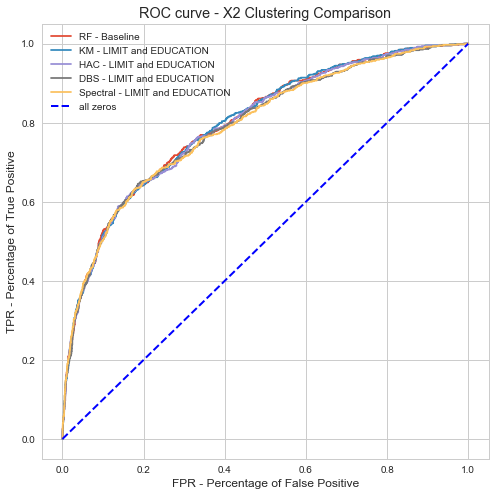

In [471]:
# adding ROC of Spectral 
# ROC for RF Baseline, HAC clusters. 
plt.figure(figsize=(8,8))
plt.plot(fpr_rf_task1, tpr_rf_task1, label='RF - Baseline')
plt.plot(km_fpr_rf_task1, km_tpr_rf_task1, label='KM - LIMIT and EDUCATION') 
#plt.plot(km_fpr_rf_task2, km_tpr_rf_task2, label='KM - AGE, MARRIAGE, and IsMale')
plt.plot(hac_fpr_rf_task1, hac_tpr_rf_task1, label='HAC - LIMIT and EDUCATION')
#plt.plot(hac_fpr_rf_task2, hac_tpr_rf_task2, label='HAC - AGE, MARRIAGE, and IsMale')
plt.plot(dbs_fpr_rf_task1, dbs_tpr_rf_task1, label='DBS - LIMIT and EDUCATION') 
#plt.plot(dbs_fpr_rf_task2, dbs_tpr_rf_task2, label='DBS - AGE, MARRIAGE, and IsMale') 
plt.plot(sp_fpr_rf_task1, sp_tpr_rf_task1, label='Spectral - LIMIT and EDUCATION') 


## Draw the diagonal line 
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='all zeros') # diagonal line

##Title, label, and legend 
plt.xlabel('FPR - Percentage of False Positive')
plt.ylabel('TPR - Percentage of True Positive')
plt.title('ROC curve - X2 Clustering Comparison')
plt.legend(loc="upper left")
plt.show()

# This discretization does not help to increase the accuracy or AUC on average. It neither help to lower the deviation from the mean. 
# Next, we will try to combine different clusterings.

DBSCAN has good clusterings for this dataset but it was not able to capture some of the nuances for the attributes. This is a spatial data, so it is expected that contiguous clustering helps discretize the data a bit. Even so, the center based clustering also tend to do well with best accuracy is around 80% and AUC is around 80%. X2 and X3 have better clusterings than X4.

Due to computer power limitation, we unsuccessfully attempted to loop with ranges of n_clusters and affinity 'nearest_neighbors' and 'precomputed' at the same time to find the best n_clusters and affinity combination parameters. 
We also attempted to use the best n_clusters = 7, founded above, to loop through affinity 'nearest_neighbors' and 'precomputed', but it's not successful.


[Our attempt to run Spectral Clusting for affinity = 'precomputed']

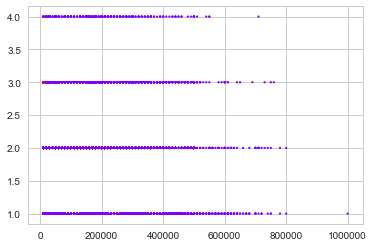

CPU times: user 20.5 s, sys: 418 ms, total: 20.9 s
Wall time: 11.3 s


In [422]:
%%time 
# an example using precomputed affinity, which uses the actual proximity graph
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph

# X2 = df_copy1[[ 'LIMIT_BAL','EDUCATION']] #.values

X = X2.values
nclust = 3
Xknn = kneighbors_graph(X, 10) 

spc = SpectralClustering(n_clusters=nclust, affinity = 'precomputed')
labels = spc.fit_predict(Xknn) 

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

This very similar to the above Spectral Clustering with affinity = 'nearest_neighbors'. 
due to computer limitation, we unsuccesfully attempted to run Spectral Clusting for affinity = 'precomputed'with nclust = 8, or to run the classification with Spetral Clustering with affinity = 'precomputed'. 

In [482]:
# %%time

# from sklearn.metrics.pairwise import pairwise_distances
# # X2 = df_copy1[[ 'LIMIT_BAL','EDUCATION']][:30000] #.values

# X = X2.values
# nclust = 4

# d = pairwise_distances(X, metric='euclidean')
# d = np.exp(- d**2 / (2.* 0.1**2)) # convert from euclidean distance to similarity
# # this is Eric's function, empirically it works

# spc = SpectralClustering(n_clusters=nclust, affinity = 'precomputed', eigen_solver = 'arpack')
# labels = spc.fit_predict(d) 

# plt.scatter(X[:, 0], X[:, 1], c=labels,
#                     cmap=plt.cm.rainbow, s=5, linewidths=0)

# plt.show()

<a href='#top'> Back to Top </a>

<div id='ref'> 
Reference: 

1. https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset 
2. https://github.com/eclarson/DataMiningNotebooks
3. https://pandas.pydata.org/pandas-docs/stable/visualization.html
4. http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html
5. https://jmetzen.github.io/2015-01-29/ml_advice.html
6. https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
7. http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
8. https://www.youtube.com/watch?v=E8OQAdQlljE
9. https://stackoverflow.com/questions/21892570/ipython-notebook-align-table-to-the-left-of-cell
10. http://datascience.ibm.com/blog/markdown-for-jupyter-notebooks-cheatsheet/
11. http://www.ritchieng.com/machine-learning-evaluate-classification-model/
12. https://www.quora.com/Machine-Learning/How-does-one-decide-on-which-kernel-to-choose-for-an-SVM-RBF-vs-linear-vs-poly-kernel http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
13. http://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html
14. https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit

15. https://chrisalbon.com/machine-learning/cross_validation_parameter_tuning_grid_search.html
16. https://www.openml.org/a/estimation-procedures/1

17. https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/

18. https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

19. http://bigdata-madesimple.com/k-nearest-neighbors-curse-dimensionality-python-scikit-learn/

20. https://stackoverflow.com/questions/28064634/random-state-pseudo-random-numberin-scikit-learn
21. https://www3.nd.edu/~dial/publications/chawla2005data.pdf
22. https://machinelearningmastery.com/data-leakage-machine-learning/
23. http://www2.cs.uregina.ca/~dbd/cs831/notes/confusion_matrix/confusion_matrix.html
24. http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
25. http://enhancedatascience.com/2017/04/23/tutorial-logistic-regression-python/
26. http://gim.unmc.edu/dxtests/roc2.htm
27. http://genomicsclass.github.io/book/pages/crossvalidation.html
28. https://stackoverflow.com/questions/35815992/how-to-find-out-weights-of-attributes-in-k-nearest-neighbors-algorithm
29. https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
30. http://blog.yhat.com/posts/roc-curves.html
31. http://python-for-multivariate-analysis.readthedocs.io/a_little_book_of_python_for_multivariate_analysis.html#between-groups-variance-and-within-groups-variance-for-a-variable
32. http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html
33. http://blog.yhat.com/posts/logistic-regression-and-python.html
34. https://people.richland.edu/james/lecture/m170/ch13-2wy.html
35. https://stats.stackexchange.com/questions/45851/how-to-statistically-compare-the-performance-of-machine-learning-classifiers
36. http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=21D16E681FF16B0BA91D741A63806A31?doi=10.1.1.29.5194&rep=rep1&type=pdf
37. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.37.3325&rep=rep1&type=pdf
38. http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html
39. https://github.com/JosPolfliet/pandas-profiling
40. http://scikit-learn.org/stable/modules/clustering.html#clustering
41. http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
42. https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/
43. https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn
44. https://stackoverflow.com/questions/22842880/different-results-with-stratifiedshufflesplit-function-scikit-learn-when-rando
45. https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/
46. https://www.naftaliharris.com/blog/visualizing-k-means-clustering/
47. A Dynamic Method for Discovering Density Varied Clusters. Mohammed T. H. Elbatta and Wesam M. Ashour. avail: http://www.sersc.org/journals/IJSIP/vol6_no1/9.pdf 
48. http://nebula.wsimg.com/b573f6daeaad3f38ead59a00eae13ffd?AccessKeyId=BDCFD2864AC62650B045&disposition=0&alloworigin=1
49. https://en.wikipedia.org/wiki/Silhouette_(clustering)
50. https://en.wikipedia.org/wiki/DBSCAN
51. http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html


 <a href="#top">Back to top</a>